## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imsave as mpsave
from matplotlib.image import imread as mpread
%matplotlib qt

def get_calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

### Computer camera calibration matrix, and store it

In [ ]:
%matplotlib qt
mtx, dist = get_calibration_mtx()

import pickle
with open('dump.pkl', 'wb') as f:
    pickle.dump(
        {
            'mtx': mtx,
            'dist': dist,
        }, f, pickle.HIGHEST_PROTOCOL)

### reload the previously loaded calibration result

In [2]:
import pickle
with open('dump.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    mtx = pickle_data['mtx']
    dist = pickle_data['dist']

## 2. use the calibration for new image testing  

In [3]:
%matplotlib inline
import numpy as np

def testimg_calibration(mtx, dist):
    images = glob.glob('../camera_cal/calibration*.jpg')
    testidx = np.random.randint(0, len(images))
    print('test on image file ', images[testidx])
    img = mpread(images[testidx])

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test on image file  ../camera_cal\calibration15.jpg


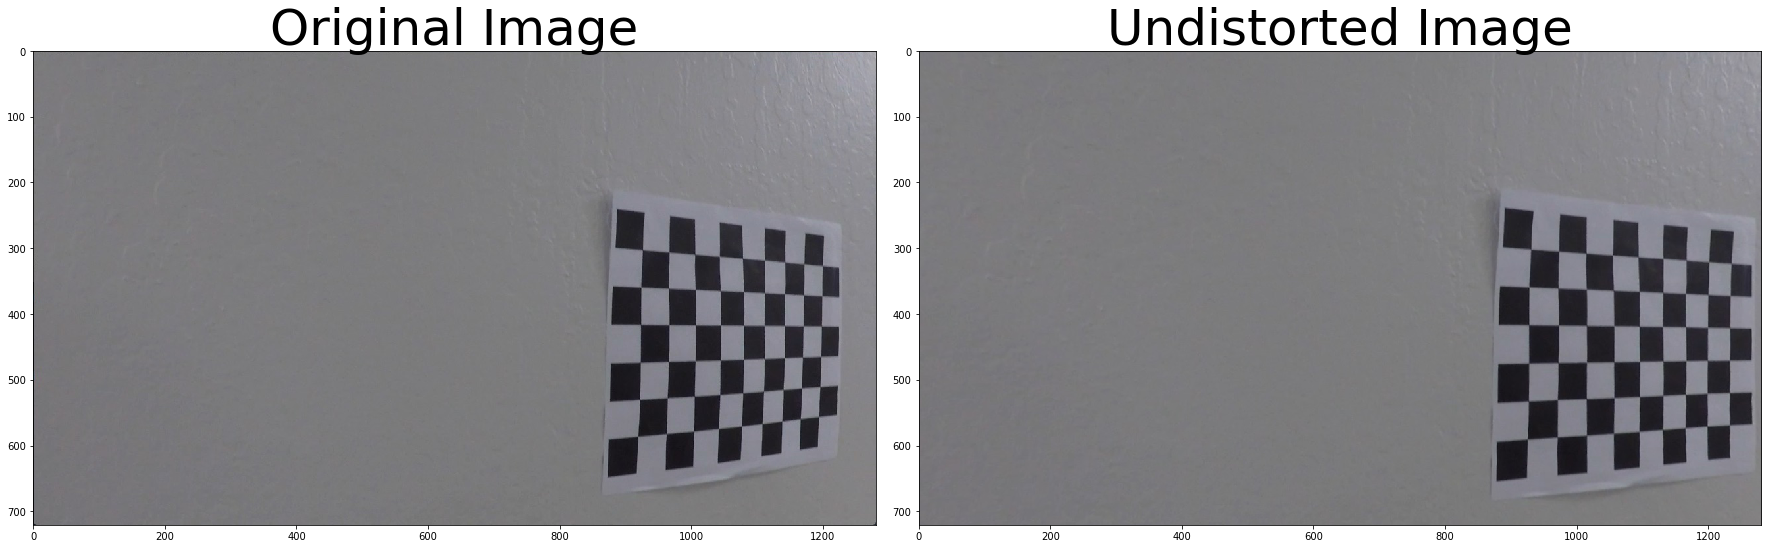

In [4]:
testimg_calibration(mtx, dist)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


In [5]:
import os
%matplotlib inline
def get_perspective_transform_mtx():
    pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    print(pers_img)
    img = mpread(pers_img)
    plt.imshow(img)
    src = np.float32([[560, 460], [720, 460], [1250, 720], [40, 720]])
    dst = np.float32([[100, 0], [1060, 0], [1060, 700], [100, 700]])
        
    src = np.float32([[490, 482],[810, 482], [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    '''
          0   1
           ---
          /   \
         /     \
        /       \
        ---------
       3         2 
    '''
    plt.plot(*src[0], '.', color = 'r')
    plt.plot(*src[1], '.', color = 'r')
    plt.plot(*src[2], '.', color = 'r')
    plt.plot(*src[3], '.', color = 'r')
    plt.plot(*dst[0], 'x', color = 'y')
    plt.plot(*dst[1], 'x', color = 'y')
    plt.plot(*dst[2], 'x', color = 'y')
    plt.plot(*dst[3], 'x', color = 'y')

    # computer the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


### calculate perspective transformation info and save them in a pickle file

..\test_images\straight_lines1.jpg


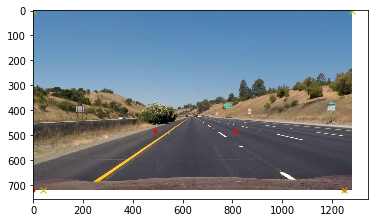

In [6]:
M, Minv = get_perspective_transform_mtx()

import pickle
with open('dump2.pkl', 'wb') as f:
    pickle.dump(
        {
            'M': M,
            'Minv': Minv,
        }, f, pickle.HIGHEST_PROTOCOL)

### reload perspective transformation info from previously saved pickle file


In [7]:
import pickle
with open('dump2.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    M = pickle_data['M']
    Minv = pickle_data['Minv']

test and check the perspective transformation

In [8]:
import os
def testimg_perspective_transform(m, imgidx = 1):
    # do transformation on the test image
    # check the final warped image after perspective transformation
    imgname = os.path.join('..', 'test_images', 'straight_lines' + str(imgidx) + '.jpg')
    print(imgname)
    img = mpread(imgname)    
    img_size = img.shape[1], img.shape[0]
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(warped)


..\test_images\straight_lines1.jpg


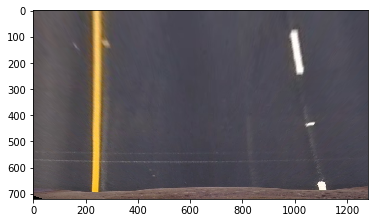

In [9]:
testimg_perspective_transform(M, imgidx = 1)   

..\test_images\straight_lines2.jpg


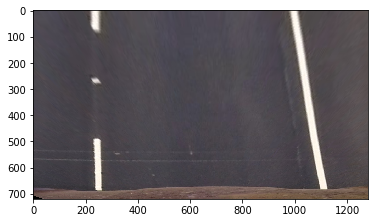

In [10]:
testimg_perspective_transform(M, imgidx = 2)  

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [11]:
from cv2 import Sobel
def build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = None, thresh = (170, 255)):
    if rawtype == 'rgb':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        rgb = img
        luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    elif rawtype == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    else:
        assert 0, 'rawtype should be bgr or rgb'
    
    channelname = channeltype.lower()
    if channelname ==  'gray':
        channel = gray
    elif channelname == 'rgb_r':
        channel = rgb[:,:,0]
    elif channelname == 'rgb_g':
        channel = rgb[:,:,1]
    elif channelname == 'rgb_b':
        channel = rgb[:,:,2]
    elif channelname == 'hls_h':
        channel = hls[:,:,0]
    elif channelname == 'hls_l':
        channel = hls[:,:,1]
    elif channelname == 'hls_s':
        channel = hls[:,:,2]
    elif channelname == 'luv_l':
        channel = luv[:, :, 0]
    elif channelname == 'luv_u':
        channel = luv[:, :, 1]
    elif channelname == 'luv_v':
        channel = luv[:, :, 2]
    elif channelname == 'lab_l':
        channel = lab[:, :, 0]
    elif channelname == 'lab_a':
        channel = lab[:, :, 1]
    elif channelname == 'lab_b':
        channel = lab[:,:,2]
    else:
        assert 0, 'channel name ' + channelname + ' not valid'
        
    if gradient != None:
        if gradient.lower() == 'x':
            newimg = Sobel(channel, cv2.CV_64F, 1, 0)
        else:
            newimg = Sobel(channel, cv2.CV_64F, 0, 1)
        newimg = np.absolute(newimg)
        newimg = np.int8(255 * newimg / np.max(newimg))
    else:
        newimg = channel
    
    result = np.zeros_like(newimg)
    result[(newimg >= thresh[0]) & (newimg <= thresh[1])] = 1
    return result


def combine_imgs(bin_img1, bin_img2):
    assert bin_img1.shape == bin_img2.shape
    combined = np.zeros_like(bin_img1)
    combined[(bin_img1 > 0) | (bin_img2 > 0)] = 1
    return combined

def gray_img(bin_img):
    return bin_img * 255

def build_gray_img(color_img, rawtype, channeltype ):
    assert rawtype == 'rgb' or rawtype == 'bgr', 'raw type should be rgb or bgr'
    if  channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'bgr':
        if channeltype == 'rgb_r':
            return color_img[:,:,2]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,0]
    elif channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'rgb':
        if channeltype == 'rgb_r':
            return color_img[:,:,0]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,2]
    elif channeltype in ['hls_h', 'hls_l', 'hls_s']:
        if rawtype == 'bgr':
            img = cv2.cvtColor(color_img, cv2.COLOR_BGR2HLS)
        elif rawtype == 'rgb':
            img = cv2.cvtColor(color_img, cv2.COLOR_RGB2HLS)
            
        if channeltype == 'hls_h':
            return img[:, :, 0]
        elif channeltype == 'hls_l':
            return img[:, :, 1]
        else:
            return img[:, :, 2]
    elif channeltype == 'gray':
        if rawtype == 'rgb':
            return cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
        elif rawtype == 'bgr':
            return cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)

### test build_binary_img function

In [12]:
import os
def testimg_build_binary(picidx = 6):
    
    imgname = os.path.join('..', 'test_images', 'test' + str(picidx)+'.jpg')
    print('testing the binary img build function on image: ', imgname)
    imgraw = mpread(imgname)
    
    img_undistort = cv2.undistort(imgraw, mtx, dist, None, mtx)
    img = cv2.warpPerspective(img_undistort, M, (img_undistort.shape[1], img_undistort.shape[0]), flags=cv2.INTER_LINEAR)
    
    img01 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', thresh = (210,255))
    img02 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = 'x', thresh= (50, 100))
    img03 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'gray')
    
    img04 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', thresh = (200, 255))
    img05 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', gradient = 'x', thresh= (40, 100))
    img06 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_r')
    
    img07 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g')
    img08 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g', gradient = 'x', thresh= (20, 100))
    img09 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_g')
    
    img10 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', thresh = (155, 200))
    img11 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', gradient = 'x', thresh= (20, 100))
    img12 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_b')
    
    img13 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h')
    img14 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h', gradient = 'x', thresh= (20, 100))
    img15 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_h')
    
    img16 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', thresh = (200, 255))
    img17 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', gradient = 'x', thresh= (20, 100))
    img18 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_l')
    
    img19 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', thresh = (180, 255))
    img20 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', gradient = 'x', thresh= (20, 100))
    img21 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_s')
    
    img22 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'luv_l', thresh = (225, 255))
    img23 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'lab_b', thresh = (155, 200))
    
    f, ax = plt.subplots(9, 3, figsize=(48, 98))
    f.tight_layout()
   
    
    ax[0][0].imshow(imgraw)
    ax[0][0].set_title('Original Image', fontsize=32)
    
    ax[0][1].imshow( img_undistort)
    ax[0][1].set_title('undistorted Image', fontsize=32)
    
    ax[0][2].imshow(img)
    ax[0][2].set_title('warp perspective img', fontsize=32)    


    ax[1][0].imshow(gray_img(img01), cmap = 'gray')
    ax[1][0].set_title('gray threshold img', fontsize = 32)
    
    ax[1][1].imshow(gray_img(img02), cmap = 'gray')
    ax[1][1].set_title('gray x sobel threshold img', fontsize = 32)
    
    ax[1][2].imshow(gray_img(img03), cmap = 'gray')
    ax[1][2].set_title('gray img', fontsize = 32)

    
    ax[2][0].imshow(gray_img(img04), cmap = 'gray')
    ax[2][0].set_title('r threshold img', fontsize = 32)
    
    ax[2][1].imshow(gray_img(img05), cmap = 'gray')
    ax[2][1].set_title('r x sobel threshold img', fontsize = 32)
    
    ax[2][2].imshow(img06, cmap = 'gray')
    ax[2][2].set_title('r img', fontsize = 32)
    
    
    ax[3][0].imshow(gray_img(img07), cmap = 'gray')
    ax[3][0].set_title('g threshold img', fontsize = 32)

    ax[3][1].imshow(gray_img(img08), cmap = 'gray')
    ax[3][1].set_title('g x sobel threshold img', fontsize = 32)
    
    ax[3][2].imshow(img09, cmap = 'gray')
    ax[3][2].set_title('g  img', fontsize = 32)
    
    
    ax[4][0].imshow(gray_img(img10), cmap = 'gray')
    ax[4][0].set_title('b threshold img', fontsize = 32)
    
    ax[4][1].imshow(gray_img(img11), cmap = 'gray')
    ax[4][1].set_title('b x sobel threshold img', fontsize = 32)
    
    ax[4][2].imshow(img12, cmap = 'gray')
    ax[4][2].set_title('b  img', fontsize = 32)
    
    
    ax[5][0].imshow(gray_img(img13), cmap = 'gray')
    ax[5][0].set_title('h threshold img', fontsize = 32)
    
    ax[5][1].imshow(gray_img(img14), cmap = 'gray')
    ax[5][1].set_title('h x sobel threshold img', fontsize = 32)
    
    ax[5][2].imshow(img15, cmap = 'gray')
    ax[5][2].set_title('h  img', fontsize = 32)
    
    
    ax[6][0].imshow(gray_img(img16), cmap = 'gray')
    ax[6][0].set_title('l threshold img', fontsize = 32)
    
    ax[6][1].imshow(gray_img(img17), cmap = 'gray')
    ax[6][1].set_title('l x sobel threshold img', fontsize = 32)
    
    ax[6][2].imshow(img18, cmap = 'gray')
    ax[6][2].set_title('l img', fontsize = 32)
    
    
    ax[7][0].imshow(gray_img(img19), cmap = 'gray')
    ax[7][0].set_title('s threshold img', fontsize = 32)
    
    ax[7][1].imshow(gray_img(img20), cmap = 'gray')
    ax[7][1].set_title('s x sobel threshold img', fontsize = 32)
    
    ax[7][2].imshow(img21, cmap = 'gray')
    ax[7][2].set_title('s  img', fontsize = 32)
    
    
    ax[8][0].imshow(gray_img(img22), cmap = 'gray')
    ax[8][0].set_title('luv l channel threshold img', fontsize = 32)
    
    ax[8][1].imshow(gray_img(img23), cmap = 'gray')
    ax[8][1].set_title('lab b channel threshold img', fontsize = 32)
    
    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)
    
    # return the raw input img, the img after undistortion and perspective transformation
    return imgraw, img

testing the binary img build function on image:  ..\test_images\test6.jpg


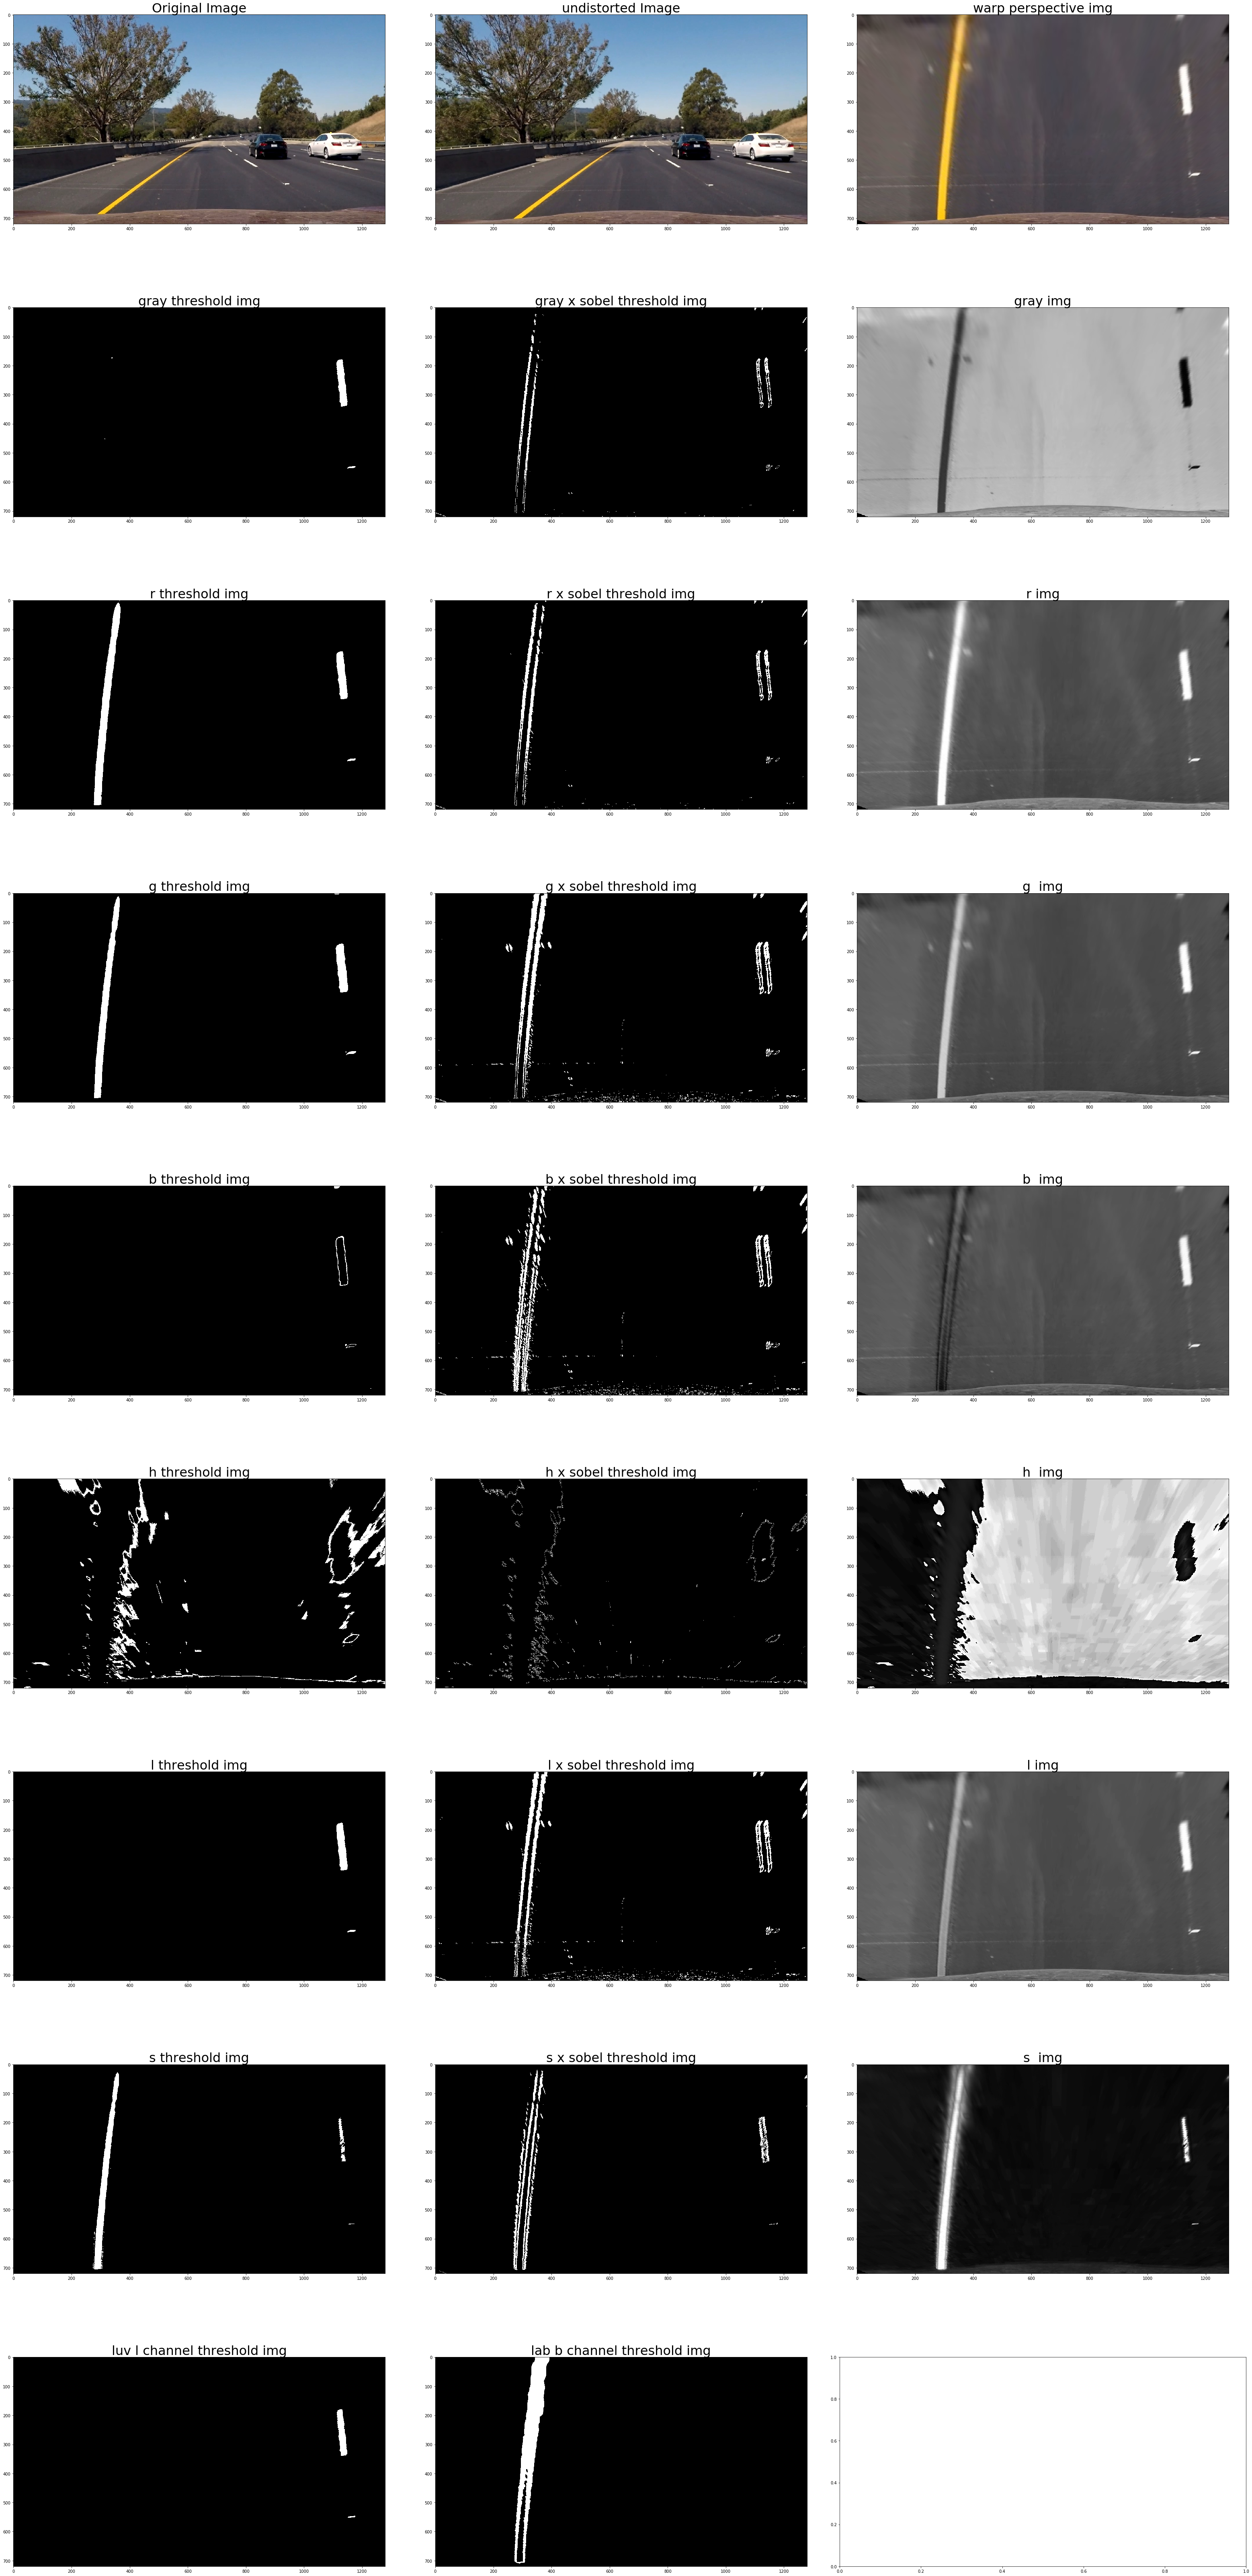

In [13]:
img_raw6, img_basic6 = testimg_build_binary(picidx = 6)

In [14]:
def get_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # as in the persepctive transformation, we have already changed the bottom half to the whole image,
    # then no need to only use the bottom half, just use the whole half
    # but actually when we detect the base lane x-position, we had better consider the bottom half as the lan maybe curving
    histogram = np.sum( img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img, img, img))   
    return histogram

In [15]:
# img_basic is the combined binary image we will do lane finding

# histogram = get_histogram(img_basic1)
# histogram = get_histogram(img_basic2)
# histogram = get_histogram(img_basic3)
# histogram = get_histogram(img_basic4)
# histogram = get_histogram(img_basic5)
histogram = get_histogram(img_basic6)

### using the binary image to get the xm_per_pix and ym_per_pix


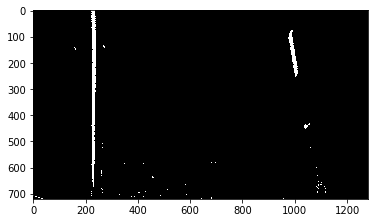

In [16]:
import os
def get_xm_per_pix():
    # we use a straight line img, e.g., test_imgs/straignt_lines1.jpg for calc
    # 1. do un-distortion
    # 2. perspective change
    # 3. get the left and right lane distance by pixel
    # 4. comparing with the real value, we assume 3.5m, 
    # return the xm_per_pix
    imgname = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    img = mpread(imgname)
    img_size = img.shape[1], img.shape[0]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    color_thresh = (170, 255)
    sobel_thresh = (20, 100)
    
    sobelx = Sobel(gray, cv2.CV_64F, 1, 0)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    sobel_bin = np.zeros_like(sobelx)
    sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 255

    
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    plt.imshow(sobel_bin, cmap = 'gray')
    hist = get_histogram(sobel_bin)
    
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    lane_line_pixel = rightx_base - leftx_base
    lane_line_meter = 3.7
    xm_per_pixel = lane_line_meter / lane_line_pixel
    return xm_per_pixel
xm_per_pixel = get_xm_per_pix()        

Sliding Window

### 7. Warp the detected lane boundaries back onto the original image.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function

# pipe line for video

In [17]:
def get_threshold_bin_img(img):
    # for video pipeline, the readin img is RGB format
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]  
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    return combined_binary

In [18]:
def blind_search(img, nwins):
    left_xvals = []
    left_yvals = []
    right_xvals = []
    right_yvals = []
    xsize, ysize = img.shape[1], img.shape[0]
    xmid = int(xsize/2)
    height = np.int(ysize /nwins) 
    x,y = np.nonzero(np.transpose(img))
    for win in range(nwins):
        # loop from img top to bottom
        histogram = np.sum(img[win * height: (win+1)*height, :], axis = 0)
        left_peak = np.argmax(histogram[:xmid])
        right_peak = np.argmax(histogram[xmid:]) + xmid

        left_x_idx = np.where((((left_peak - 25) < x) & 
                               (x < (left_peak + 25)) &
                               ((y > win*height) & (y < (win+1)* height))))
        right_x_idx = np.where((((right_peak - 25) < x) & 
                               (x < (right_peak + 25)) &
                               ((y > win*height) & (y < (win+1)* height))))
        left_x_window, left_y_window = x[left_x_idx], y[left_x_idx]
        right_x_window, right_y_window = x[right_x_idx], y[right_x_idx]
        if np.sum(left_x_window) != 0:
            left_xvals.extend(left_x_window)
            left_yvals.extend(left_y_window)
        if np.sum(right_x_window) != 0:
            right_xvals.extend(right_x_window)
            right_yvals.extend(right_y_window)

    # return the x points, y points, and a flag 
    return left_xvals, left_yvals, right_xvals, right_yvals

In [19]:
def based_on_previous_search(img, left_fittings, right_fittings, nwins):
    # here left_fittings[0], left_fittings[1], left_fittings[2] store previous fitting frame img value
    left_xvals = []
    left_yvals = []
    right_xvals = []
    right_yvals = []
    xsize, ysize = img.shape[1], img.shape[0]
    xmid = xsize/2
    height = np.int(ysize /nwins) 
    x,y = np.nonzero(np.transpose(img))
    for win in range(nwins):
        #loop from top to down
        ymid = np.mean([win * height, (win +1) * height])

        left_xmid = (np.mean(left_fittings[0]))*ymid**2 +(np.mean(left_fittings[1]))*ymid + (np.mean(left_fittings[2]))
        right_xmid = (np.mean(right_fittings[0]))*ymid**2 + (np.mean(right_fittings[1]))*ymid + (np.mean(right_fittings[2]))

        left_x_idx = np.where((((left_xmid - 25) < x) & (x < (left_xmid + 25))&((y > win*height) & (y < (win+1) * height))))
        right_x_idx = np.where((((right_xmid - 25) < x) & (x < (right_xmid + 25))&((y > win*height) & (y < (win+1) * height))))

        left_x_window, left_y_window = x[left_x_idx], y[left_x_idx]
        right_x_window, right_y_window = x[right_x_idx], y[right_x_idx]
        if np.sum(left_x_window) != 0:
            np.append(left_xvals, left_x_window)
            np.append(left_yvals, left_y_window)
        if np.sum(right_x_window) != 0:
            np.append(right_xvals, right_x_window)
            np.append(right_yvals, right_y_window)
    return left_xvals, left_yvals, right_xvals, right_yvals


In [28]:
# we use a class to collect all the variables together in a scope

# use it as global as it not changed [y_pixdels, x_pixels]
imgsize = img_basic6.shape[:2]
print(imgsize)

# the difference between LaneLineHandler2 and laneLineHandler is 
# LaneLineHander2 use the previous img left_x_base as the starting point for windows sliding
# while LaneLineHandler use histogram to detect the starting point
class LaneLineHandler2(object):
    def __init__(self, saved_dir = None):
        self.nwindows = 8
        self.window_height = np.int(imgsize[0]/self.nwindows)
        self.margin = 50
        # self.minpix = 50
        self.ym_per_pix = 30./720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700
    
        self.mtx = mtx
        self.dist = dist
        self.reuse_count = 0
        
        self.saved_dir = saved_dir
        self.img_count = 0
        self.nodata = False
        
        # for senalty check
        self.last_offset = None
        self.last_left_curvature_meter = None
        self.last_right_curvature_meter = None
        
        self.last_left_fittings = [[], [], [] ]
        self.last_right_fittings = [[], [], []]
        
        self.last_left_fittings_meter = [[], [], [] ]
        self.last_right_fittings_meter = [[], [], []]
        
    def run(self, img):
        self.readin(img)
        self.finding_pixels()
        self.fitting()
        result = self.drawBack()
        return result

        
    def readin(self, img, rawtype = 'rgb'):
        print('read in the img index:', self.img_count)
        # readin the raw color image taken from the camera
        self.img_count += 1
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        self.img_raw = img
        self.nodata = False
        
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
        
        self.img_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        self.img_basic = get_threshold_bin_img(self.img_warped)
        x, y = np.nonzero(np.transpose(self.img_basic))
        if len(x) == 0:
            print('no data for fitting, using previous img')
            self.nodata = True
        return

    
    def finding_pixels(self):
        # we use different strategy to do searching
        if self.nodata == True:
            self.leftx, self.lefty, self.rightx, self.righty = [], [], [], []
        elif self.reuse_count >= 6 or self.img_count == 1:
            # the first img or too many reuse
            self.leftx, self.lefty, self.rightx, self.righty = blind_search(self.img_basic, 
                                                                            self.nwindows)
        else:
            self.leftx, self.lefty, self.rightx, self.righty = based_on_previous_search(self.img_basic, 
                                                                                        self.last_left_fittings,
                                                                                        self.last_right_fittings,
                                                                                        self.nwindows)
            if len(self.leftx) == 0 or len(self.rightx) == 0:
                self.leftx, self.lefty, self.rightx, self.righty = blind_search(self.img_basic,
                                                                               self.nwindows)
            
    def senaltyCheck(self):
        if self.reuse_count > 6:
            reuse = False
        elif self.last_offset == None:
            reuse = False
        else:
            reuse = False
            if self.nodata == True:
                print('no data, reuse previous data')
                reuse = True
            elif abs(self.last_offset - self.offset) > 0.2:
                print('resue previous, as last_offset =', self.last_offset, ' this offset =', self.offset )
                resue = True
#             elif abs(self.last_left_curvature_meter - self.left_curvature_meter) > 500:
#                 print('last left curvature meter = ', self.last_left_curvature_meter, 
#                       ' this is=', self.left_curvature_meter)
#                 reuse = True
#             elif abs(self.last_right_curvature_meter - self.right_curvature_meter) > 500:
#                 print('last right curvature meter =', self.last_right_curvature_meter, 
#                       ' this is=', self.right_curvature_meter)
#                 reuse = True
                
        if reuse == True:
            print('reusing: reuse_count = ', self.reuse_count)
            self.reuse_count += 1
            self.offset = self.last_offset
            self.left_curvature_meter = self.last_left_curvature_meter
            self.right_curvature_meter = self.last_right_curvature_meter
            assert len(self.last_left_fittings[0]) >= 1
            assert len(self.last_right_fittings[0]) >= 1
            self.left_fit = [ self.last_left_fittings[0][-1],
                            self.last_left_fittings[1][-1],
                            self.last_left_fittings[2][-1]]
            
            self.right_fit = [ self.last_right_fittings[0][-1],
                             self.last_right_fittings[1][-1],
                             self.last_right_fittings[2][-1]]
            self.left_fit_meter = [ self.last_left_fittings_meter[0][-1],
                                   self.last_left_fittings_meter[1][-1],
                                   self.last_left_fittings_meter[2][-1]]
            
            self.right_fit_meter = [ self.last_right_fittings_meter[0][-1],
                                    self.last_right_fittings_meter[1][-1],
                                    self.last_right_fittings_meter[2][-1]]
                
        else:
            self.reuse_count = 0
            self.last_offset = self.offset
            self.last_left_curvature_meter = self.left_curvature_meter
            self.last_right_curvature_meter = self.right_curvature_meter
            self.last_leftx = self.leftx
            self.last_lefty = slef.lefty
            self.last_rightx = self.rightx
            self.last_righty = self.righty
            for i in range(3):
                self.last_left_fittings[i].append(self.left_fit[i])
                self.last_right_fittings[i].append(self.right_fit[i])
                if len(self.last_left_fittings[i]) > 4:
                    self.last_left_fittings[i] = self.last_left_fittings[i][-4:]
                if len(self.last_right_fittings[i]) > 4:
                    self.last_right_fittings[i] = self.last_right_fittings[i][-4:]
                
                self.last_left_fittings_meter[i].append(self.left_fit_meter[i])
                self.last_right_fittings_meter[i].append(self.right_fit_meter[i])
                if len(self.last_left_fittings_meter[i]) > 4:
                    self.last_left_fittings_meter[i] = self.last_left_fittings_meter[i][-4:]
                if len(self.last_right_fittings_meter[i]) > 4:
                    self.last_right_fittings_meter[i] = self.last_right_fittings_meter[i][-4:]
                    

        
    def fitting(self):
        # no data for current, then do re-use previous frame img pixels
        if len(self.leftx) == 0:
            self.leftx = self.last_leftx
            self.lefty = self.last_lefty
        if len(self.rightx) == 0:
            self.rightx = self.last_rightx
            self.righty = self.last_righty
                
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        
        # self.left_fit_meter = np.polyfit(self.lefty * self.ym_per_pix, self.leftx * self.xm_per_pix, 2)
        # self.right_fit_meter = np.polyfit(self.righty * self.ym_per_pix, self.rightx * self.xm_per_pix, 2)
        self.left_fit_meter = np.polyfit([y * self.ym_per_pix for y in self.lefty],[x* self.xm_per_pix for x in self.leftx], 2)
        self.right_fit_meter = np.polyfit([y * self.ym_per_pix for y in self.righty], [x*self.xm_per_pix for x in self.rightx], 2)
        
    
    def calcOffset(self):
        car_left = self.left_fit[0]*720**2 + self.left_fit[1]*720 + self.left_fit[2]
        car_right = self.right_fit[0]*720**2 + self.right_fit[1]*720 + self.right_fit[2]
        car_center = (car_left + car_right) /2.0
        self.offset = (car_center - 640)* self.xm_per_pix
        
    def calcCurvature(self):
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )

        y_eval = np.max(ploty)
        # calc the curvature at the bottom,e.g., close to the car
        # x = a*y^2 + b*y + c 
        # R_curve = [1 + (2a+b)^2]^(3/2)/ |2a|


        self.left_curvature = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curvature= ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        
        left_fitting0 = np.mean(self.last_left_fittings[0])
        left_fitting1 = np.mean(self.last_left_fittings[1])
        left_fitting2 = np.mean(self.last_left_fittings[2])
        right_fitting0 = np.mean(self.last_right_fittings[0])
        right_fitting1 = np.mean(self.last_right_fittings[1])
        right_fitting2 = np.mean(self.last_right_fittings[2])
        
        self.left_curvature = ((1 + (2*left_fitting0*y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature= ((1 + (2*right_fitting0*y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
        y_eval = y_eval * self.ym_per_pix
        self.left_curvature_meter =((1 + (2*self.left_fit_meter[0]* y_eval + self.left_fit_meter[1])**2)**1.5) / np.absolute(2*self.left_fit_meter[0])
        self.right_curvature_meter = ((1 + (2*self.right_fit_meter[0] * y_eval + self.right_fit_meter[1])**2)**1.5) / np.absolute(2*self.right_fit_meter[0])
        
        left_fitting0 = np.mean(self.last_left_fittings_meter[0])
        left_fitting1 = np.mean(self.last_left_fittings_meter[1])
        left_fitting2 = np.mean(self.last_left_fittings_meter[2])
        right_fitting0 = np.mean(self.last_right_fittings_meter[0])
        right_fitting1 = np.mean(self.last_right_fittings_meter[1])
        right_fitting2 = np.mean(self.last_right_fittings_meter[2])
        
        self.left_curvature_meter =((1 + (2*left_fitting0* y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature_meter = ((1 + (2*right_fitting0 * y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
    
    def drawBack(self):
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
            

        # Create an image to draw the lines on
        color_warp = np.zeros_like(self.img_raw).astype(np.uint8)
        
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )
        
        self.calcOffset()
        self.calcCurvature()
        self.senaltyCheck()

        left_fitting0 = np.mean(self.last_left_fittings[0])
        left_fitting1 = np.mean(self.last_left_fittings[1])
        left_fitting2 = np.mean(self.last_left_fittings[2])
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        left_fitx = left_fitting0*ploty**2 + left_fitting1*ploty + left_fitting2
        
        right_fitting0 = np.mean(self.last_right_fittings[0])
        right_fitting1 = np.mean(self.last_right_fittings[1])
        right_fitting2 = np.mean(self.last_right_fittings[2])
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        right_fitx = right_fitting0 * ploty**2 + right_fitting1*ploty + right_fitting2


        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.img_basic.shape[1], self.img_basic.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.img_raw, 1, newwarp, 0.3, 0)
        # plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        
        # write the curvature and position information
        font = cv2.FONT_HERSHEY_SIMPLEX
                
        text = 'Curvature Radius: '+ '{0:.1f}'.format(self.left_curvature_meter/2.0 + self.right_curvature_meter/2.0 ) + ' m'
        cv2.putText(result, text, (50,100), font, 1.5, (255,255,255),2, cv2.LINE_AA)

    
        if self.offset > 0:
            text = 'Vehicle is ' + '{0:.2f}'.format(self.offset) + ' m left of center'
        else:
            text = 'Vehicle is ' + '{0:.2f}'.format(- self.offset) + ' m right of center' 
        cv2.putText(result, text, (50,200), font, 1.5, (255,255,255),2, cv2.LINE_AA)
        
        if self.reuse_count == 0:
            text = 'result from this img calculation'
        else:
            text = 'reuse previous img info, reuse count = ' + str(self.reuse_count)
        cv2.putText(result, text, (50, 300), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)

        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_1warped.jpg'
            cv2.imwrite(filename, self.img_warped)
            filename = self.saved_dir + str(self.img_count) + '_2basic.jpg'
            cv2.imwrite(filename, self.img_basic)
            filename = self.saved_dir + str(self.img_count) + '_3fitting.jpg'
            cv2.imwrite(filename, self.out_color)
            
        return result

(720, 1280)


In [29]:
g_handler2 = LaneLineHandler2()
def get_handler2():
    return g_handler2

In [30]:
def process_image2(img):
    handler = get_handler2()
    result = handler.run(img)
    return result

In [29]:
from moviepy.editor import VideoFileClip
video_input = '../project_video.mp4'
video_output = '../project_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

# g_handler2 = LaneLineHandler2('../videoimg_project/')
g_handler2 = LaneLineHandler2()

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip1 = VideoFileClip(video_input)
# clip1 = VideoFileClip(video_input).subclip(0,1)
clip1 = VideoFileClip(video_input)
challenge_clip = clip1.fl_image(process_image2)
%time challenge_clip.write_videofile(video_output, audio=False)

read in the img index: 0
[MoviePy] >>>> Building video ../project_solution.mp4
[MoviePy] Writing video ../project_solution.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

read in the img index: 1


  0%|                                                                                 | 1/1261 [00:00<05:30,  3.81it/s]

read in the img index: 2


  0%|▏                                                                                | 2/1261 [00:00<05:17,  3.97it/s]

read in the img index: 3
last left curvature meter =  8254.19203387  this is= 6794.16664458


  0%|▏                                                                                | 3/1261 [00:00<05:17,  3.97it/s]

read in the img index: 4
last left curvature meter =  8254.19203387  this is= 6794.16664458


  0%|▎                                                                                | 4/1261 [00:00<05:17,  3.95it/s]

read in the img index: 5
last left curvature meter =  8254.19203387  this is= 6794.16664458


  0%|▎                                                                                | 5/1261 [00:01<05:17,  3.96it/s]

read in the img index: 6
last left curvature meter =  8254.19203387  this is= 6794.16664458


  0%|▍                                                                                | 6/1261 [00:01<05:32,  3.78it/s]

read in the img index: 7
last left curvature meter =  8254.19203387  this is= 6794.16664458


  1%|▍                                                                                | 7/1261 [00:01<05:24,  3.86it/s]

read in the img index: 8
last left curvature meter =  8254.19203387  this is= 6794.16664458


  1%|▌                                                                                | 8/1261 [00:02<05:17,  3.95it/s]

read in the img index: 9
last left curvature meter =  8254.19203387  this is= 6794.16664458


  1%|▌                                                                                | 9/1261 [00:02<05:07,  4.07it/s]

read in the img index: 10


  1%|▋                                                                               | 10/1261 [00:02<04:44,  4.39it/s]

read in the img index: 11
last left curvature meter =  6794.16664458  this is= 5772.34905412


  1%|▋                                                                               | 11/1261 [00:02<04:50,  4.30it/s]

read in the img index: 12
last left curvature meter =  6794.16664458  this is= 5772.34905412


  1%|▊                                                                               | 12/1261 [00:02<04:58,  4.19it/s]

read in the img index: 13
last left curvature meter =  6794.16664458  this is= 5772.34905412


  1%|▊                                                                               | 13/1261 [00:03<05:18,  3.92it/s]

read in the img index: 14
last left curvature meter =  6794.16664458  this is= 5772.34905412


  1%|▉                                                                               | 14/1261 [00:03<05:16,  3.95it/s]

read in the img index: 15
last left curvature meter =  6794.16664458  this is= 5772.34905412


  1%|▉                                                                               | 15/1261 [00:03<05:31,  3.76it/s]

read in the img index: 16
last left curvature meter =  6794.16664458  this is= 5772.34905412


  1%|█                                                                               | 16/1261 [00:04<05:43,  3.63it/s]

read in the img index: 17
last left curvature meter =  6794.16664458  this is= 5772.34905412


  1%|█                                                                               | 17/1261 [00:04<05:37,  3.68it/s]

read in the img index: 18


  1%|█▏                                                                              | 18/1261 [00:04<05:12,  3.98it/s]

read in the img index: 19
last left curvature meter =  5772.34905412  this is= 3647.20409528


  2%|█▏                                                                              | 19/1261 [00:04<05:10,  4.00it/s]

read in the img index: 20
last left curvature meter =  5772.34905412  this is= 3647.20409528


  2%|█▎                                                                              | 20/1261 [00:05<05:06,  4.05it/s]

read in the img index: 21
last left curvature meter =  5772.34905412  this is= 3647.20409528


  2%|█▎                                                                              | 21/1261 [00:05<05:09,  4.00it/s]

read in the img index: 22
last left curvature meter =  5772.34905412  this is= 3647.20409528


  2%|█▍                                                                              | 22/1261 [00:05<05:03,  4.08it/s]

read in the img index: 23
last left curvature meter =  5772.34905412  this is= 3647.20409528


  2%|█▍                                                                              | 23/1261 [00:05<05:14,  3.94it/s]

read in the img index: 24
last left curvature meter =  5772.34905412  this is= 3647.20409528


  2%|█▌                                                                              | 24/1261 [00:06<05:23,  3.82it/s]

read in the img index: 25
last left curvature meter =  5772.34905412  this is= 3647.20409528


  2%|█▌                                                                              | 25/1261 [00:06<05:27,  3.77it/s]

read in the img index: 26


  2%|█▋                                                                              | 26/1261 [00:06<05:17,  3.89it/s]

read in the img index: 27
last left curvature meter =  3647.20409528  this is= 5886.76893764


  2%|█▋                                                                              | 27/1261 [00:06<05:12,  3.95it/s]

read in the img index: 28
last left curvature meter =  3647.20409528  this is= 5886.76893764


  2%|█▊                                                                              | 28/1261 [00:07<05:25,  3.79it/s]

read in the img index: 29
last left curvature meter =  3647.20409528  this is= 5886.76893764


  2%|█▊                                                                              | 29/1261 [00:07<05:29,  3.73it/s]

read in the img index: 30
last left curvature meter =  3647.20409528  this is= 5886.76893764


  2%|█▉                                                                              | 30/1261 [00:07<05:31,  3.72it/s]

read in the img index: 31
last left curvature meter =  3647.20409528  this is= 5886.76893764


  2%|█▉                                                                              | 31/1261 [00:07<05:36,  3.66it/s]

read in the img index: 32
last left curvature meter =  3647.20409528  this is= 5886.76893764


  3%|██                                                                              | 32/1261 [00:08<05:26,  3.77it/s]

read in the img index: 33
last left curvature meter =  3647.20409528  this is= 5886.76893764


  3%|██                                                                              | 33/1261 [00:08<05:08,  3.98it/s]

read in the img index: 34


  3%|██▏                                                                             | 34/1261 [00:08<04:52,  4.20it/s]

read in the img index: 35
last left curvature meter =  5886.76893764  this is= 4861.54967435


  3%|██▏                                                                             | 35/1261 [00:08<04:50,  4.22it/s]

read in the img index: 36
last left curvature meter =  5886.76893764  this is= 4861.54967435


  3%|██▎                                                                             | 36/1261 [00:09<04:51,  4.21it/s]

read in the img index: 37
last left curvature meter =  5886.76893764  this is= 4861.54967435


  3%|██▎                                                                             | 37/1261 [00:09<04:50,  4.21it/s]

read in the img index: 38
last left curvature meter =  5886.76893764  this is= 4861.54967435


  3%|██▍                                                                             | 38/1261 [00:09<04:54,  4.16it/s]

read in the img index: 39
last left curvature meter =  5886.76893764  this is= 4861.54967435


  3%|██▍                                                                             | 39/1261 [00:09<05:19,  3.82it/s]

read in the img index: 40
last left curvature meter =  5886.76893764  this is= 4861.54967435


  3%|██▌                                                                             | 40/1261 [00:10<05:17,  3.84it/s]

read in the img index: 41
last left curvature meter =  5886.76893764  this is= 4861.54967435


  3%|██▌                                                                             | 41/1261 [00:10<05:22,  3.79it/s]

read in the img index: 42


  3%|██▋                                                                             | 42/1261 [00:10<05:04,  4.00it/s]

read in the img index: 43
last left curvature meter =  4861.54967435  this is= 4170.07568189


  3%|██▋                                                                             | 43/1261 [00:10<05:26,  3.73it/s]

read in the img index: 44
last left curvature meter =  4861.54967435  this is= 4170.07568189


  3%|██▊                                                                             | 44/1261 [00:11<05:20,  3.79it/s]

read in the img index: 45
last left curvature meter =  4861.54967435  this is= 4170.07568189


  4%|██▊                                                                             | 45/1261 [00:11<05:09,  3.93it/s]

read in the img index: 46
last left curvature meter =  4861.54967435  this is= 4170.07568189


  4%|██▉                                                                             | 46/1261 [00:11<05:06,  3.96it/s]

read in the img index: 47
last left curvature meter =  4861.54967435  this is= 4170.07568189


  4%|██▉                                                                             | 47/1261 [00:11<05:17,  3.82it/s]

read in the img index: 48
last left curvature meter =  4861.54967435  this is= 4170.07568189


  4%|███                                                                             | 48/1261 [00:12<05:32,  3.65it/s]

read in the img index: 49
last left curvature meter =  4861.54967435  this is= 4170.07568189


  4%|███                                                                             | 49/1261 [00:12<05:30,  3.67it/s]

read in the img index: 50


  4%|███▏                                                                            | 50/1261 [00:12<05:10,  3.90it/s]

read in the img index: 51
last right curvature meter = 3146.63631968  this is= 4968.73907454


  4%|███▏                                                                            | 51/1261 [00:13<05:06,  3.94it/s]

read in the img index: 52
last right curvature meter = 3146.63631968  this is= 4968.73907454


  4%|███▎                                                                            | 52/1261 [00:13<05:07,  3.93it/s]

read in the img index: 53
last right curvature meter = 3146.63631968  this is= 4968.73907454


  4%|███▎                                                                            | 53/1261 [00:13<05:05,  3.95it/s]

read in the img index: 54
last right curvature meter = 3146.63631968  this is= 4968.73907454


  4%|███▍                                                                            | 54/1261 [00:13<05:09,  3.90it/s]

read in the img index: 55
last right curvature meter = 3146.63631968  this is= 4968.73907454


  4%|███▍                                                                            | 55/1261 [00:14<05:11,  3.87it/s]

read in the img index: 56
last right curvature meter = 3146.63631968  this is= 4968.73907454


  4%|███▌                                                                            | 56/1261 [00:14<05:10,  3.88it/s]

read in the img index: 57
last right curvature meter = 3146.63631968  this is= 4968.73907454


  5%|███▌                                                                            | 57/1261 [00:14<05:04,  3.96it/s]

read in the img index: 58


  5%|███▋                                                                            | 58/1261 [00:14<04:40,  4.29it/s]

read in the img index: 59
last left curvature meter =  4012.08520276  this is= 2370.39565383


  5%|███▋                                                                            | 59/1261 [00:14<04:45,  4.21it/s]

read in the img index: 60
last left curvature meter =  4012.08520276  this is= 2370.39565383


  5%|███▊                                                                            | 60/1261 [00:15<04:49,  4.15it/s]

read in the img index: 61
last left curvature meter =  4012.08520276  this is= 2370.39565383


  5%|███▊                                                                            | 61/1261 [00:15<04:48,  4.16it/s]

read in the img index: 62
last left curvature meter =  4012.08520276  this is= 2370.39565383


  5%|███▉                                                                            | 62/1261 [00:15<04:58,  4.02it/s]

read in the img index: 63
last left curvature meter =  4012.08520276  this is= 2370.39565383


  5%|███▉                                                                            | 63/1261 [00:15<04:52,  4.10it/s]

read in the img index: 64
last left curvature meter =  4012.08520276  this is= 2370.39565383


  5%|████                                                                            | 64/1261 [00:16<04:47,  4.16it/s]

read in the img index: 65
last left curvature meter =  4012.08520276  this is= 2370.39565383


  5%|████                                                                            | 65/1261 [00:16<04:41,  4.25it/s]

read in the img index: 66


  5%|████▏                                                                           | 66/1261 [00:16<04:30,  4.41it/s]

read in the img index: 67
last left curvature meter =  2370.39565383  this is= 3229.41191938


  5%|████▎                                                                           | 67/1261 [00:16<04:45,  4.18it/s]

read in the img index: 68
last left curvature meter =  2370.39565383  this is= 3229.41191938


  5%|████▎                                                                           | 68/1261 [00:17<04:44,  4.19it/s]

read in the img index: 69
last left curvature meter =  2370.39565383  this is= 3229.41191938


  5%|████▍                                                                           | 69/1261 [00:17<04:49,  4.12it/s]

read in the img index: 70
last left curvature meter =  2370.39565383  this is= 3229.41191938


  6%|████▍                                                                           | 70/1261 [00:17<04:49,  4.12it/s]

read in the img index: 71
last left curvature meter =  2370.39565383  this is= 3229.41191938


  6%|████▌                                                                           | 71/1261 [00:17<04:42,  4.21it/s]

read in the img index: 72
last left curvature meter =  2370.39565383  this is= 3229.41191938


  6%|████▌                                                                           | 72/1261 [00:18<04:43,  4.20it/s]

read in the img index: 73
last left curvature meter =  2370.39565383  this is= 3229.41191938


  6%|████▋                                                                           | 73/1261 [00:18<04:38,  4.26it/s]

read in the img index: 74


  6%|████▋                                                                           | 74/1261 [00:18<04:29,  4.40it/s]

read in the img index: 75
last right curvature meter = 2054.70865204  this is= 4792.20488061


  6%|████▊                                                                           | 75/1261 [00:18<04:35,  4.30it/s]

read in the img index: 76
last right curvature meter = 2054.70865204  this is= 4792.20488061


  6%|████▊                                                                           | 76/1261 [00:19<04:41,  4.22it/s]

read in the img index: 77
last right curvature meter = 2054.70865204  this is= 4792.20488061


  6%|████▉                                                                           | 77/1261 [00:19<04:45,  4.14it/s]

read in the img index: 78
last right curvature meter = 2054.70865204  this is= 4792.20488061


  6%|████▉                                                                           | 78/1261 [00:19<04:47,  4.12it/s]

read in the img index: 79
last right curvature meter = 2054.70865204  this is= 4792.20488061


  6%|█████                                                                           | 79/1261 [00:19<04:55,  4.00it/s]

read in the img index: 80
last right curvature meter = 2054.70865204  this is= 4792.20488061


  6%|█████                                                                           | 80/1261 [00:20<04:49,  4.08it/s]

read in the img index: 81
last right curvature meter = 2054.70865204  this is= 4792.20488061


  6%|█████▏                                                                          | 81/1261 [00:20<05:13,  3.76it/s]

read in the img index: 82


  7%|█████▏                                                                          | 82/1261 [00:20<05:11,  3.78it/s]

read in the img index: 83
last left curvature meter =  2814.02235278  this is= 5556.3660108


  7%|█████▎                                                                          | 83/1261 [00:20<05:13,  3.76it/s]

read in the img index: 84
last left curvature meter =  2814.02235278  this is= 5556.3660108


  7%|█████▎                                                                          | 84/1261 [00:21<04:59,  3.93it/s]

read in the img index: 85
last left curvature meter =  2814.02235278  this is= 5556.3660108


  7%|█████▍                                                                          | 85/1261 [00:21<04:58,  3.93it/s]

read in the img index: 86
last left curvature meter =  2814.02235278  this is= 5556.3660108


  7%|█████▍                                                                          | 86/1261 [00:21<04:53,  4.01it/s]

read in the img index: 87
last left curvature meter =  2814.02235278  this is= 5556.3660108


  7%|█████▌                                                                          | 87/1261 [00:21<04:48,  4.07it/s]

read in the img index: 88
last left curvature meter =  2814.02235278  this is= 5556.3660108


  7%|█████▌                                                                          | 88/1261 [00:22<04:43,  4.14it/s]

read in the img index: 89
last left curvature meter =  2814.02235278  this is= 5556.3660108


  7%|█████▋                                                                          | 89/1261 [00:22<04:33,  4.29it/s]

read in the img index: 90


  7%|█████▋                                                                          | 90/1261 [00:22<04:21,  4.47it/s]

read in the img index: 91
last left curvature meter =  5556.3660108  this is= 16672.5565292


  7%|█████▊                                                                          | 91/1261 [00:22<04:30,  4.33it/s]

read in the img index: 92
last left curvature meter =  5556.3660108  this is= 16672.5565292


  7%|█████▊                                                                          | 92/1261 [00:22<04:37,  4.21it/s]

read in the img index: 93
last left curvature meter =  5556.3660108  this is= 16672.5565292


  7%|█████▉                                                                          | 93/1261 [00:23<04:39,  4.18it/s]

read in the img index: 94
last left curvature meter =  5556.3660108  this is= 16672.5565292


  7%|█████▉                                                                          | 94/1261 [00:23<04:38,  4.19it/s]

read in the img index: 95
last left curvature meter =  5556.3660108  this is= 16672.5565292


  8%|██████                                                                          | 95/1261 [00:23<04:37,  4.20it/s]

read in the img index: 96
last left curvature meter =  5556.3660108  this is= 16672.5565292


  8%|██████                                                                          | 96/1261 [00:23<04:36,  4.22it/s]

read in the img index: 97
last left curvature meter =  5556.3660108  this is= 16672.5565292


  8%|██████▏                                                                         | 97/1261 [00:24<04:27,  4.35it/s]

read in the img index: 98


  8%|██████▏                                                                         | 98/1261 [00:24<04:17,  4.52it/s]

read in the img index: 99
last left curvature meter =  16672.5565292  this is= 5966.65443567


  8%|██████▎                                                                         | 99/1261 [00:24<04:21,  4.44it/s]

read in the img index: 100
last left curvature meter =  16672.5565292  this is= 5966.65443567


  8%|██████▎                                                                        | 100/1261 [00:24<04:28,  4.33it/s]

read in the img index: 101
last left curvature meter =  16672.5565292  this is= 5966.65443567


  8%|██████▎                                                                        | 101/1261 [00:25<04:29,  4.31it/s]

read in the img index: 102
last left curvature meter =  16672.5565292  this is= 5966.65443567


  8%|██████▍                                                                        | 102/1261 [00:25<04:30,  4.29it/s]

read in the img index: 103
last left curvature meter =  16672.5565292  this is= 5966.65443567


  8%|██████▍                                                                        | 103/1261 [00:25<04:31,  4.27it/s]

read in the img index: 104
last left curvature meter =  16672.5565292  this is= 5966.65443567


  8%|██████▌                                                                        | 104/1261 [00:25<04:33,  4.24it/s]

read in the img index: 105
last left curvature meter =  16672.5565292  this is= 5966.65443567


  8%|██████▌                                                                        | 105/1261 [00:26<04:37,  4.16it/s]

read in the img index: 106


  8%|██████▋                                                                        | 106/1261 [00:26<04:33,  4.22it/s]

read in the img index: 107
last left curvature meter =  5966.65443567  this is= 12278.4877647


  8%|██████▋                                                                        | 107/1261 [00:26<04:33,  4.22it/s]

read in the img index: 108
last left curvature meter =  5966.65443567  this is= 12278.4877647


  9%|██████▊                                                                        | 108/1261 [00:26<04:31,  4.25it/s]

read in the img index: 109
last left curvature meter =  5966.65443567  this is= 12278.4877647


  9%|██████▊                                                                        | 109/1261 [00:26<04:33,  4.22it/s]

read in the img index: 110
last left curvature meter =  5966.65443567  this is= 12278.4877647


  9%|██████▉                                                                        | 110/1261 [00:27<04:31,  4.24it/s]

read in the img index: 111
last left curvature meter =  5966.65443567  this is= 12278.4877647


  9%|██████▉                                                                        | 111/1261 [00:27<04:32,  4.22it/s]

read in the img index: 112
last left curvature meter =  5966.65443567  this is= 12278.4877647


  9%|███████                                                                        | 112/1261 [00:27<04:31,  4.23it/s]

read in the img index: 113
last left curvature meter =  5966.65443567  this is= 12278.4877647


  9%|███████                                                                        | 113/1261 [00:27<04:26,  4.31it/s]

read in the img index: 114


  9%|███████▏                                                                       | 114/1261 [00:28<04:12,  4.53it/s]

read in the img index: 115
last left curvature meter =  12278.4877647  this is= 6795.8503901


  9%|███████▏                                                                       | 115/1261 [00:28<04:21,  4.39it/s]

read in the img index: 116
last left curvature meter =  12278.4877647  this is= 6795.8503901


  9%|███████▎                                                                       | 116/1261 [00:28<04:21,  4.38it/s]

read in the img index: 117
last left curvature meter =  12278.4877647  this is= 6795.8503901


  9%|███████▎                                                                       | 117/1261 [00:28<04:28,  4.26it/s]

read in the img index: 118
last left curvature meter =  12278.4877647  this is= 6795.8503901


  9%|███████▍                                                                       | 118/1261 [00:29<04:28,  4.26it/s]

read in the img index: 119
last left curvature meter =  12278.4877647  this is= 6795.8503901


  9%|███████▍                                                                       | 119/1261 [00:29<04:31,  4.20it/s]

read in the img index: 120
last left curvature meter =  12278.4877647  this is= 6795.8503901


 10%|███████▌                                                                       | 120/1261 [00:29<04:29,  4.23it/s]

read in the img index: 121
last left curvature meter =  12278.4877647  this is= 6795.8503901


 10%|███████▌                                                                       | 121/1261 [00:29<04:25,  4.30it/s]

read in the img index: 122


 10%|███████▋                                                                       | 122/1261 [00:29<04:15,  4.45it/s]

read in the img index: 123
last left curvature meter =  6795.8503901  this is= 3830.60979222


 10%|███████▋                                                                       | 123/1261 [00:30<04:18,  4.41it/s]

read in the img index: 124
last left curvature meter =  6795.8503901  this is= 3830.60979222


 10%|███████▊                                                                       | 124/1261 [00:30<04:21,  4.35it/s]

read in the img index: 125
last left curvature meter =  6795.8503901  this is= 3830.60979222


 10%|███████▊                                                                       | 125/1261 [00:30<04:21,  4.34it/s]

read in the img index: 126
last left curvature meter =  6795.8503901  this is= 3830.60979222


 10%|███████▉                                                                       | 126/1261 [00:30<04:23,  4.30it/s]

read in the img index: 127
last left curvature meter =  6795.8503901  this is= 3830.60979222


 10%|███████▉                                                                       | 127/1261 [00:31<04:25,  4.27it/s]

read in the img index: 128
last left curvature meter =  6795.8503901  this is= 3830.60979222


 10%|████████                                                                       | 128/1261 [00:31<04:46,  3.95it/s]

read in the img index: 129
last left curvature meter =  6795.8503901  this is= 3830.60979222


 10%|████████                                                                       | 129/1261 [00:31<04:39,  4.05it/s]

read in the img index: 130


 10%|████████▏                                                                      | 130/1261 [00:31<04:27,  4.22it/s]

read in the img index: 131
last right curvature meter = 411362.153974  this is= 2689.83638384


 10%|████████▏                                                                      | 131/1261 [00:32<04:35,  4.10it/s]

read in the img index: 132
last right curvature meter = 411362.153974  this is= 2689.83638384


 10%|████████▎                                                                      | 132/1261 [00:32<04:40,  4.02it/s]

read in the img index: 133
last right curvature meter = 411362.153974  this is= 2689.83638384


 11%|████████▎                                                                      | 133/1261 [00:32<04:54,  3.82it/s]

read in the img index: 134
last right curvature meter = 411362.153974  this is= 2689.83638384


 11%|████████▍                                                                      | 134/1261 [00:32<04:49,  3.89it/s]

read in the img index: 135
last right curvature meter = 411362.153974  this is= 2689.83638384


 11%|████████▍                                                                      | 135/1261 [00:33<04:49,  3.89it/s]

read in the img index: 136
last right curvature meter = 411362.153974  this is= 2689.83638384


 11%|████████▌                                                                      | 136/1261 [00:33<04:47,  3.92it/s]

read in the img index: 137
last right curvature meter = 411362.153974  this is= 2689.83638384


 11%|████████▌                                                                      | 137/1261 [00:33<04:40,  4.01it/s]

read in the img index: 138


 11%|████████▋                                                                      | 138/1261 [00:33<04:34,  4.10it/s]

read in the img index: 139
last right curvature meter = 2689.83638384  this is= 4216.72211315


 11%|████████▋                                                                      | 139/1261 [00:34<04:49,  3.88it/s]

read in the img index: 140
last right curvature meter = 2689.83638384  this is= 4216.72211315


 11%|████████▊                                                                      | 140/1261 [00:34<04:45,  3.93it/s]

read in the img index: 141
last right curvature meter = 2689.83638384  this is= 4216.72211315


 11%|████████▊                                                                      | 141/1261 [00:34<04:58,  3.76it/s]

read in the img index: 142
last right curvature meter = 2689.83638384  this is= 4216.72211315


 11%|████████▉                                                                      | 142/1261 [00:34<04:52,  3.83it/s]

read in the img index: 143
last right curvature meter = 2689.83638384  this is= 4216.72211315


 11%|████████▉                                                                      | 143/1261 [00:35<05:03,  3.68it/s]

read in the img index: 144
last right curvature meter = 2689.83638384  this is= 4216.72211315


 11%|█████████                                                                      | 144/1261 [00:35<04:54,  3.79it/s]

read in the img index: 145
last right curvature meter = 2689.83638384  this is= 4216.72211315


 11%|█████████                                                                      | 145/1261 [00:35<04:41,  3.96it/s]

read in the img index: 146


 12%|█████████▏                                                                     | 146/1261 [00:35<04:26,  4.19it/s]

read in the img index: 147
last right curvature meter = 4216.72211315  this is= 1981.59459452


 12%|█████████▏                                                                     | 147/1261 [00:36<04:25,  4.20it/s]

read in the img index: 148
last right curvature meter = 4216.72211315  this is= 1981.59459452


 12%|█████████▎                                                                     | 148/1261 [00:36<04:24,  4.20it/s]

read in the img index: 149
last right curvature meter = 4216.72211315  this is= 1981.59459452


 12%|█████████▎                                                                     | 149/1261 [00:36<04:25,  4.19it/s]

read in the img index: 150
last right curvature meter = 4216.72211315  this is= 1981.59459452


 12%|█████████▍                                                                     | 150/1261 [00:36<04:38,  3.99it/s]

read in the img index: 151
last right curvature meter = 4216.72211315  this is= 1981.59459452


 12%|█████████▍                                                                     | 151/1261 [00:37<04:48,  3.85it/s]

read in the img index: 152
last right curvature meter = 4216.72211315  this is= 1981.59459452


 12%|█████████▌                                                                     | 152/1261 [00:37<04:40,  3.95it/s]

read in the img index: 153
last right curvature meter = 4216.72211315  this is= 1981.59459452


 12%|█████████▌                                                                     | 153/1261 [00:37<04:32,  4.07it/s]

read in the img index: 154


 12%|█████████▋                                                                     | 154/1261 [00:37<04:16,  4.32it/s]

read in the img index: 155
last left curvature meter =  2800.95352606  this is= 3878.39714525


 12%|█████████▋                                                                     | 155/1261 [00:38<04:21,  4.22it/s]

read in the img index: 156
last left curvature meter =  2800.95352606  this is= 3878.39714525


 12%|█████████▊                                                                     | 156/1261 [00:38<04:25,  4.16it/s]

read in the img index: 157
last left curvature meter =  2800.95352606  this is= 3878.39714525


 12%|█████████▊                                                                     | 157/1261 [00:38<04:35,  4.01it/s]

read in the img index: 158
last left curvature meter =  2800.95352606  this is= 3878.39714525


 13%|█████████▉                                                                     | 158/1261 [00:38<04:50,  3.80it/s]

read in the img index: 159
last left curvature meter =  2800.95352606  this is= 3878.39714525


 13%|█████████▉                                                                     | 159/1261 [00:39<04:48,  3.82it/s]

read in the img index: 160
last left curvature meter =  2800.95352606  this is= 3878.39714525


 13%|██████████                                                                     | 160/1261 [00:39<04:38,  3.95it/s]

read in the img index: 161
last left curvature meter =  2800.95352606  this is= 3878.39714525


 13%|██████████                                                                     | 161/1261 [00:39<04:38,  3.96it/s]

read in the img index: 162


 13%|██████████▏                                                                    | 162/1261 [00:39<04:18,  4.25it/s]

read in the img index: 163
last left curvature meter =  3878.39714525  this is= 5939.30396277


 13%|██████████▏                                                                    | 163/1261 [00:40<04:26,  4.12it/s]

read in the img index: 164
last left curvature meter =  3878.39714525  this is= 5939.30396277


 13%|██████████▎                                                                    | 164/1261 [00:40<04:31,  4.04it/s]

read in the img index: 165
last left curvature meter =  3878.39714525  this is= 5939.30396277


 13%|██████████▎                                                                    | 165/1261 [00:40<04:42,  3.88it/s]

read in the img index: 166
last left curvature meter =  3878.39714525  this is= 5939.30396277


 13%|██████████▍                                                                    | 166/1261 [00:40<04:43,  3.86it/s]

read in the img index: 167
last left curvature meter =  3878.39714525  this is= 5939.30396277


 13%|██████████▍                                                                    | 167/1261 [00:41<04:44,  3.84it/s]

read in the img index: 168
last left curvature meter =  3878.39714525  this is= 5939.30396277


 13%|██████████▌                                                                    | 168/1261 [00:41<04:38,  3.92it/s]

read in the img index: 169
last left curvature meter =  3878.39714525  this is= 5939.30396277


 13%|██████████▌                                                                    | 169/1261 [00:41<04:42,  3.86it/s]

read in the img index: 170


 13%|██████████▋                                                                    | 170/1261 [00:41<04:26,  4.09it/s]

read in the img index: 171
last left curvature meter =  5939.30396277  this is= 7542.24814498


 14%|██████████▋                                                                    | 171/1261 [00:42<04:40,  3.88it/s]

read in the img index: 172
last left curvature meter =  5939.30396277  this is= 7542.24814498


 14%|██████████▊                                                                    | 172/1261 [00:42<04:40,  3.88it/s]

read in the img index: 173
last left curvature meter =  5939.30396277  this is= 7542.24814498


 14%|██████████▊                                                                    | 173/1261 [00:42<04:49,  3.76it/s]

read in the img index: 174
last left curvature meter =  5939.30396277  this is= 7542.24814498


 14%|██████████▉                                                                    | 174/1261 [00:42<04:40,  3.88it/s]

read in the img index: 175
last left curvature meter =  5939.30396277  this is= 7542.24814498


 14%|██████████▉                                                                    | 175/1261 [00:43<04:39,  3.88it/s]

read in the img index: 176
last left curvature meter =  5939.30396277  this is= 7542.24814498


 14%|███████████                                                                    | 176/1261 [00:43<04:32,  3.98it/s]

read in the img index: 177
last left curvature meter =  5939.30396277  this is= 7542.24814498


 14%|███████████                                                                    | 177/1261 [00:43<04:22,  4.13it/s]

read in the img index: 178


 14%|███████████▏                                                                   | 178/1261 [00:43<04:10,  4.33it/s]

read in the img index: 179


 14%|███████████▏                                                                   | 179/1261 [00:44<04:10,  4.32it/s]

read in the img index: 180
last left curvature meter =  7376.66041935  this is= 5843.05497195


 14%|███████████▎                                                                   | 180/1261 [00:44<04:17,  4.20it/s]

read in the img index: 181
last left curvature meter =  7376.66041935  this is= 5843.05497195


 14%|███████████▎                                                                   | 181/1261 [00:44<04:19,  4.16it/s]

read in the img index: 182
last left curvature meter =  7376.66041935  this is= 5843.05497195


 14%|███████████▍                                                                   | 182/1261 [00:44<04:21,  4.13it/s]

read in the img index: 183
last left curvature meter =  7376.66041935  this is= 5843.05497195


 15%|███████████▍                                                                   | 183/1261 [00:45<04:19,  4.16it/s]

read in the img index: 184
last left curvature meter =  7376.66041935  this is= 5843.05497195


 15%|███████████▌                                                                   | 184/1261 [00:45<04:16,  4.20it/s]

read in the img index: 185
last left curvature meter =  7376.66041935  this is= 5843.05497195


 15%|███████████▌                                                                   | 185/1261 [00:45<04:13,  4.24it/s]

read in the img index: 186
last left curvature meter =  7376.66041935  this is= 5843.05497195


 15%|███████████▋                                                                   | 186/1261 [00:45<04:07,  4.34it/s]

read in the img index: 187


 15%|███████████▋                                                                   | 187/1261 [00:46<03:59,  4.48it/s]

read in the img index: 188
last left curvature meter =  5843.05497195  this is= 4044.14267348


 15%|███████████▊                                                                   | 188/1261 [00:46<04:07,  4.33it/s]

read in the img index: 189
last left curvature meter =  5843.05497195  this is= 4044.14267348


 15%|███████████▊                                                                   | 189/1261 [00:46<04:09,  4.30it/s]

read in the img index: 190
last left curvature meter =  5843.05497195  this is= 4044.14267348


 15%|███████████▉                                                                   | 190/1261 [00:46<04:11,  4.26it/s]

read in the img index: 191
last left curvature meter =  5843.05497195  this is= 4044.14267348


 15%|███████████▉                                                                   | 191/1261 [00:46<04:13,  4.22it/s]

read in the img index: 192
last left curvature meter =  5843.05497195  this is= 4044.14267348


 15%|████████████                                                                   | 192/1261 [00:47<04:15,  4.19it/s]

read in the img index: 193
last left curvature meter =  5843.05497195  this is= 4044.14267348


 15%|████████████                                                                   | 193/1261 [00:47<04:15,  4.18it/s]

read in the img index: 194
last left curvature meter =  5843.05497195  this is= 4044.14267348


 15%|████████████▏                                                                  | 194/1261 [00:47<04:16,  4.16it/s]

read in the img index: 195


 15%|████████████▏                                                                  | 195/1261 [00:47<04:06,  4.33it/s]

read in the img index: 196
last left curvature meter =  4044.14267348  this is= 3299.54715386


 16%|████████████▎                                                                  | 196/1261 [00:48<04:11,  4.24it/s]

read in the img index: 197
last left curvature meter =  4044.14267348  this is= 3299.54715386


 16%|████████████▎                                                                  | 197/1261 [00:48<04:09,  4.26it/s]

read in the img index: 198
last left curvature meter =  4044.14267348  this is= 3299.54715386


 16%|████████████▍                                                                  | 198/1261 [00:48<04:11,  4.23it/s]

read in the img index: 199
last left curvature meter =  4044.14267348  this is= 3299.54715386


 16%|████████████▍                                                                  | 199/1261 [00:48<04:17,  4.12it/s]

read in the img index: 200
last left curvature meter =  4044.14267348  this is= 3299.54715386


 16%|████████████▌                                                                  | 200/1261 [00:49<04:15,  4.16it/s]

read in the img index: 201
last left curvature meter =  4044.14267348  this is= 3299.54715386


 16%|████████████▌                                                                  | 201/1261 [00:49<04:18,  4.11it/s]

read in the img index: 202
last left curvature meter =  4044.14267348  this is= 3299.54715386


 16%|████████████▋                                                                  | 202/1261 [00:49<04:10,  4.23it/s]

read in the img index: 203


 16%|████████████▋                                                                  | 203/1261 [00:49<03:59,  4.42it/s]

read in the img index: 204


 16%|████████████▊                                                                  | 204/1261 [00:50<04:00,  4.39it/s]

read in the img index: 205
last left curvature meter =  3743.7361867  this is= 3026.92967206


 16%|████████████▊                                                                  | 205/1261 [00:50<04:09,  4.24it/s]

read in the img index: 206
last left curvature meter =  3743.7361867  this is= 3026.92967206


 16%|████████████▉                                                                  | 206/1261 [00:50<04:12,  4.17it/s]

read in the img index: 207
last left curvature meter =  3743.7361867  this is= 3026.92967206


 16%|████████████▉                                                                  | 207/1261 [00:50<04:13,  4.16it/s]

read in the img index: 208
last left curvature meter =  3743.7361867  this is= 3026.92967206


 16%|█████████████                                                                  | 208/1261 [00:51<04:11,  4.18it/s]

read in the img index: 209
last left curvature meter =  3743.7361867  this is= 3026.92967206


 17%|█████████████                                                                  | 209/1261 [00:51<04:25,  3.96it/s]

read in the img index: 210
last left curvature meter =  3743.7361867  this is= 3026.92967206


 17%|█████████████▏                                                                 | 210/1261 [00:51<04:37,  3.79it/s]

read in the img index: 211
last left curvature meter =  3743.7361867  this is= 3026.92967206


 17%|█████████████▏                                                                 | 211/1261 [00:51<04:41,  3.73it/s]

read in the img index: 212


 17%|█████████████▎                                                                 | 212/1261 [00:52<04:38,  3.76it/s]

read in the img index: 213
last left curvature meter =  3026.92967206  this is= 3949.33508477


 17%|█████████████▎                                                                 | 213/1261 [00:52<04:29,  3.88it/s]

read in the img index: 214
last left curvature meter =  3026.92967206  this is= 3949.33508477


 17%|█████████████▍                                                                 | 214/1261 [00:52<04:42,  3.71it/s]

read in the img index: 215
last left curvature meter =  3026.92967206  this is= 3949.33508477


 17%|█████████████▍                                                                 | 215/1261 [00:52<04:35,  3.79it/s]

read in the img index: 216
last left curvature meter =  3026.92967206  this is= 3949.33508477


 17%|█████████████▌                                                                 | 216/1261 [00:53<04:32,  3.83it/s]

read in the img index: 217
last left curvature meter =  3026.92967206  this is= 3949.33508477


 17%|█████████████▌                                                                 | 217/1261 [00:53<04:25,  3.93it/s]

read in the img index: 218
last left curvature meter =  3026.92967206  this is= 3949.33508477


 17%|█████████████▋                                                                 | 218/1261 [00:53<04:23,  3.96it/s]

read in the img index: 219
last left curvature meter =  3026.92967206  this is= 3949.33508477


 17%|█████████████▋                                                                 | 219/1261 [00:53<04:12,  4.12it/s]

read in the img index: 220


 17%|█████████████▊                                                                 | 220/1261 [00:54<03:58,  4.36it/s]

read in the img index: 221


 18%|█████████████▊                                                                 | 221/1261 [00:54<03:54,  4.44it/s]

read in the img index: 222
last left curvature meter =  3617.22704657  this is= 2881.21824379


 18%|█████████████▉                                                                 | 222/1261 [00:54<04:13,  4.10it/s]

read in the img index: 223
last left curvature meter =  3617.22704657  this is= 2881.21824379


 18%|█████████████▉                                                                 | 223/1261 [00:54<04:24,  3.93it/s]

read in the img index: 224
last left curvature meter =  3617.22704657  this is= 2881.21824379


 18%|██████████████                                                                 | 224/1261 [00:55<04:30,  3.83it/s]

read in the img index: 225
last left curvature meter =  3617.22704657  this is= 2881.21824379


 18%|██████████████                                                                 | 225/1261 [00:55<04:34,  3.77it/s]

read in the img index: 226
last left curvature meter =  3617.22704657  this is= 2881.21824379


 18%|██████████████▏                                                                | 226/1261 [00:55<04:42,  3.67it/s]

read in the img index: 227
last left curvature meter =  3617.22704657  this is= 2881.21824379


 18%|██████████████▏                                                                | 227/1261 [00:55<04:43,  3.65it/s]

read in the img index: 228
last left curvature meter =  3617.22704657  this is= 2881.21824379


 18%|██████████████▎                                                                | 228/1261 [00:56<04:29,  3.83it/s]

read in the img index: 229


 18%|██████████████▎                                                                | 229/1261 [00:56<04:11,  4.10it/s]

read in the img index: 230


 18%|██████████████▍                                                                | 230/1261 [00:56<04:02,  4.25it/s]

read in the img index: 231


 18%|██████████████▍                                                                | 231/1261 [00:56<04:02,  4.24it/s]

read in the img index: 232
last left curvature meter =  2940.0192123  this is= 4052.40341526


 18%|██████████████▌                                                                | 232/1261 [00:57<04:07,  4.16it/s]

read in the img index: 233
last left curvature meter =  2940.0192123  this is= 4052.40341526


 18%|██████████████▌                                                                | 233/1261 [00:57<04:09,  4.13it/s]

read in the img index: 234
last left curvature meter =  2940.0192123  this is= 4052.40341526


 19%|██████████████▋                                                                | 234/1261 [00:57<04:11,  4.09it/s]

read in the img index: 235
last left curvature meter =  2940.0192123  this is= 4052.40341526


 19%|██████████████▋                                                                | 235/1261 [00:57<04:13,  4.05it/s]

read in the img index: 236
last left curvature meter =  2940.0192123  this is= 4052.40341526


 19%|██████████████▊                                                                | 236/1261 [00:58<04:11,  4.07it/s]

read in the img index: 237
last left curvature meter =  2940.0192123  this is= 4052.40341526


 19%|██████████████▊                                                                | 237/1261 [00:58<04:12,  4.06it/s]

read in the img index: 238
last left curvature meter =  2940.0192123  this is= 4052.40341526


 19%|██████████████▉                                                                | 238/1261 [00:58<04:05,  4.18it/s]

read in the img index: 239


 19%|██████████████▉                                                                | 239/1261 [00:58<03:58,  4.29it/s]

read in the img index: 240
last left curvature meter =  4052.40341526  this is= 7058.4794355


 19%|███████████████                                                                | 240/1261 [00:59<04:02,  4.20it/s]

read in the img index: 241
last left curvature meter =  4052.40341526  this is= 7058.4794355


 19%|███████████████                                                                | 241/1261 [00:59<04:20,  3.91it/s]

read in the img index: 242
last left curvature meter =  4052.40341526  this is= 7058.4794355


 19%|███████████████▏                                                               | 242/1261 [00:59<04:27,  3.81it/s]

read in the img index: 243
last left curvature meter =  4052.40341526  this is= 7058.4794355


 19%|███████████████▏                                                               | 243/1261 [00:59<04:27,  3.81it/s]

read in the img index: 244
last left curvature meter =  4052.40341526  this is= 7058.4794355


 19%|███████████████▎                                                               | 244/1261 [01:00<04:23,  3.86it/s]

read in the img index: 245
last left curvature meter =  4052.40341526  this is= 7058.4794355


 19%|███████████████▎                                                               | 245/1261 [01:00<04:17,  3.94it/s]

read in the img index: 246
last left curvature meter =  4052.40341526  this is= 7058.4794355


 20%|███████████████▍                                                               | 246/1261 [01:00<04:12,  4.01it/s]

read in the img index: 247


 20%|███████████████▍                                                               | 247/1261 [01:00<04:01,  4.19it/s]

read in the img index: 248
last left curvature meter =  7058.4794355  this is= 10046.4819461


 20%|███████████████▌                                                               | 248/1261 [01:01<04:06,  4.11it/s]

read in the img index: 249
last left curvature meter =  7058.4794355  this is= 10046.4819461


 20%|███████████████▌                                                               | 249/1261 [01:01<04:05,  4.11it/s]

read in the img index: 250
last left curvature meter =  7058.4794355  this is= 10046.4819461


 20%|███████████████▋                                                               | 250/1261 [01:01<04:07,  4.09it/s]

read in the img index: 251
last left curvature meter =  7058.4794355  this is= 10046.4819461


 20%|███████████████▋                                                               | 251/1261 [01:01<04:02,  4.16it/s]

read in the img index: 252
last left curvature meter =  7058.4794355  this is= 10046.4819461


 20%|███████████████▊                                                               | 252/1261 [01:02<04:13,  3.98it/s]

read in the img index: 253
last left curvature meter =  7058.4794355  this is= 10046.4819461


 20%|███████████████▊                                                               | 253/1261 [01:02<04:15,  3.95it/s]

read in the img index: 254
last left curvature meter =  7058.4794355  this is= 10046.4819461


 20%|███████████████▉                                                               | 254/1261 [01:02<04:13,  3.97it/s]

read in the img index: 255


 20%|███████████████▉                                                               | 255/1261 [01:02<04:04,  4.11it/s]

read in the img index: 256
last left curvature meter =  10046.4819461  this is= 12424.0370606


 20%|████████████████                                                               | 256/1261 [01:03<04:02,  4.14it/s]

read in the img index: 257
last left curvature meter =  10046.4819461  this is= 12424.0370606


 20%|████████████████                                                               | 257/1261 [01:03<04:07,  4.06it/s]

read in the img index: 258
last left curvature meter =  10046.4819461  this is= 12424.0370606


 20%|████████████████▏                                                              | 258/1261 [01:03<04:04,  4.11it/s]

read in the img index: 259
last left curvature meter =  10046.4819461  this is= 12424.0370606


 21%|████████████████▏                                                              | 259/1261 [01:03<04:01,  4.14it/s]

read in the img index: 260
last left curvature meter =  10046.4819461  this is= 12424.0370606


 21%|████████████████▎                                                              | 260/1261 [01:04<03:59,  4.19it/s]

read in the img index: 261
last left curvature meter =  10046.4819461  this is= 12424.0370606


 21%|████████████████▎                                                              | 261/1261 [01:04<04:02,  4.13it/s]

read in the img index: 262
last left curvature meter =  10046.4819461  this is= 12424.0370606


 21%|████████████████▍                                                              | 262/1261 [01:04<03:59,  4.17it/s]

read in the img index: 263


 21%|████████████████▍                                                              | 263/1261 [01:04<03:51,  4.31it/s]

read in the img index: 264
last left curvature meter =  12424.0370606  this is= 17689.5411273


 21%|████████████████▌                                                              | 264/1261 [01:04<03:55,  4.23it/s]

read in the img index: 265
last left curvature meter =  12424.0370606  this is= 17689.5411273


 21%|████████████████▌                                                              | 265/1261 [01:05<03:59,  4.16it/s]

read in the img index: 266
last left curvature meter =  12424.0370606  this is= 17689.5411273


 21%|████████████████▋                                                              | 266/1261 [01:05<03:59,  4.15it/s]

read in the img index: 267
last left curvature meter =  12424.0370606  this is= 17689.5411273


 21%|████████████████▋                                                              | 267/1261 [01:05<04:04,  4.06it/s]

read in the img index: 268
last left curvature meter =  12424.0370606  this is= 17689.5411273


 21%|████████████████▊                                                              | 268/1261 [01:05<04:08,  4.00it/s]

read in the img index: 269
last left curvature meter =  12424.0370606  this is= 17689.5411273


 21%|████████████████▊                                                              | 269/1261 [01:06<04:23,  3.77it/s]

read in the img index: 270
last left curvature meter =  12424.0370606  this is= 17689.5411273


 21%|████████████████▉                                                              | 270/1261 [01:06<04:25,  3.73it/s]

read in the img index: 271


 21%|████████████████▉                                                              | 271/1261 [01:06<04:11,  3.93it/s]

read in the img index: 272
last left curvature meter =  17689.5411273  this is= 10090.2538306


 22%|█████████████████                                                              | 272/1261 [01:07<04:09,  3.97it/s]

read in the img index: 273
last left curvature meter =  17689.5411273  this is= 10090.2538306


 22%|█████████████████                                                              | 273/1261 [01:07<04:06,  4.02it/s]

read in the img index: 274
last left curvature meter =  17689.5411273  this is= 10090.2538306


 22%|█████████████████▏                                                             | 274/1261 [01:07<04:03,  4.05it/s]

read in the img index: 275
last left curvature meter =  17689.5411273  this is= 10090.2538306


 22%|█████████████████▏                                                             | 275/1261 [01:07<04:04,  4.03it/s]

read in the img index: 276
last left curvature meter =  17689.5411273  this is= 10090.2538306


 22%|█████████████████▎                                                             | 276/1261 [01:08<04:16,  3.83it/s]

read in the img index: 277
last left curvature meter =  17689.5411273  this is= 10090.2538306


 22%|█████████████████▎                                                             | 277/1261 [01:08<04:25,  3.71it/s]

read in the img index: 278
last left curvature meter =  17689.5411273  this is= 10090.2538306


 22%|█████████████████▍                                                             | 278/1261 [01:08<04:12,  3.90it/s]

read in the img index: 279


 22%|█████████████████▍                                                             | 279/1261 [01:08<04:17,  3.82it/s]

read in the img index: 280
last left curvature meter =  10090.2538306  this is= 6953.43537278


 22%|█████████████████▌                                                             | 280/1261 [01:09<04:16,  3.83it/s]

read in the img index: 281
last left curvature meter =  10090.2538306  this is= 6953.43537278


 22%|█████████████████▌                                                             | 281/1261 [01:09<04:30,  3.62it/s]

read in the img index: 282
last left curvature meter =  10090.2538306  this is= 6953.43537278


 22%|█████████████████▋                                                             | 282/1261 [01:09<04:20,  3.76it/s]

read in the img index: 283
last left curvature meter =  10090.2538306  this is= 6953.43537278


 22%|█████████████████▋                                                             | 283/1261 [01:09<04:11,  3.89it/s]

read in the img index: 284
last left curvature meter =  10090.2538306  this is= 6953.43537278


 23%|█████████████████▊                                                             | 284/1261 [01:10<04:04,  3.99it/s]

read in the img index: 285
last left curvature meter =  10090.2538306  this is= 6953.43537278


 23%|█████████████████▊                                                             | 285/1261 [01:10<04:00,  4.06it/s]

read in the img index: 286
last left curvature meter =  10090.2538306  this is= 6953.43537278


 23%|█████████████████▉                                                             | 286/1261 [01:10<03:59,  4.07it/s]

read in the img index: 287


 23%|█████████████████▉                                                             | 287/1261 [01:10<04:05,  3.97it/s]

read in the img index: 288


 23%|██████████████████                                                             | 288/1261 [01:11<04:15,  3.81it/s]

read in the img index: 289
last left curvature meter =  7235.91481097  this is= 8201.15078726


 23%|██████████████████                                                             | 289/1261 [01:11<04:12,  3.84it/s]

read in the img index: 290
last left curvature meter =  7235.91481097  this is= 8201.15078726


 23%|██████████████████▏                                                            | 290/1261 [01:11<04:28,  3.61it/s]

read in the img index: 291
last left curvature meter =  7235.91481097  this is= 8201.15078726


 23%|██████████████████▏                                                            | 291/1261 [01:11<04:20,  3.72it/s]

read in the img index: 292
last left curvature meter =  7235.91481097  this is= 8201.15078726


 23%|██████████████████▎                                                            | 292/1261 [01:12<04:22,  3.69it/s]

read in the img index: 293
last left curvature meter =  7235.91481097  this is= 8201.15078726


 23%|██████████████████▎                                                            | 293/1261 [01:12<04:27,  3.62it/s]

read in the img index: 294
last left curvature meter =  7235.91481097  this is= 8201.15078726


 23%|██████████████████▍                                                            | 294/1261 [01:12<04:16,  3.76it/s]

read in the img index: 295
last left curvature meter =  7235.91481097  this is= 8201.15078726


 23%|██████████████████▍                                                            | 295/1261 [01:12<04:03,  3.97it/s]

read in the img index: 296


 23%|██████████████████▌                                                            | 296/1261 [01:13<03:45,  4.27it/s]

read in the img index: 297
last left curvature meter =  8201.15078726  this is= 6818.68665213


 24%|██████████████████▌                                                            | 297/1261 [01:13<03:48,  4.22it/s]

read in the img index: 298
last left curvature meter =  8201.15078726  this is= 6818.68665213


 24%|██████████████████▋                                                            | 298/1261 [01:13<04:03,  3.96it/s]

read in the img index: 299
last left curvature meter =  8201.15078726  this is= 6818.68665213


 24%|██████████████████▋                                                            | 299/1261 [01:13<04:06,  3.90it/s]

read in the img index: 300
last left curvature meter =  8201.15078726  this is= 6818.68665213


 24%|██████████████████▊                                                            | 300/1261 [01:14<04:00,  3.99it/s]

read in the img index: 301
last left curvature meter =  8201.15078726  this is= 6818.68665213


 24%|██████████████████▊                                                            | 301/1261 [01:14<04:14,  3.77it/s]

read in the img index: 302
last left curvature meter =  8201.15078726  this is= 6818.68665213


 24%|██████████████████▉                                                            | 302/1261 [01:14<04:08,  3.86it/s]

read in the img index: 303
last left curvature meter =  8201.15078726  this is= 6818.68665213


 24%|██████████████████▉                                                            | 303/1261 [01:14<03:59,  4.01it/s]

read in the img index: 304


 24%|███████████████████                                                            | 304/1261 [01:15<03:58,  4.02it/s]

read in the img index: 305
last left curvature meter =  6818.68665213  this is= 13957.2517848


 24%|███████████████████                                                            | 305/1261 [01:15<04:02,  3.94it/s]

read in the img index: 306
last left curvature meter =  6818.68665213  this is= 13957.2517848


 24%|███████████████████▏                                                           | 306/1261 [01:15<03:58,  4.00it/s]

read in the img index: 307
last left curvature meter =  6818.68665213  this is= 13957.2517848


 24%|███████████████████▏                                                           | 307/1261 [01:15<03:55,  4.05it/s]

read in the img index: 308
last left curvature meter =  6818.68665213  this is= 13957.2517848


 24%|███████████████████▎                                                           | 308/1261 [01:16<03:51,  4.12it/s]

read in the img index: 309
last left curvature meter =  6818.68665213  this is= 13957.2517848


 25%|███████████████████▎                                                           | 309/1261 [01:16<03:50,  4.14it/s]

read in the img index: 310
last left curvature meter =  6818.68665213  this is= 13957.2517848


 25%|███████████████████▍                                                           | 310/1261 [01:16<03:49,  4.15it/s]

read in the img index: 311
last left curvature meter =  6818.68665213  this is= 13957.2517848


 25%|███████████████████▍                                                           | 311/1261 [01:16<03:42,  4.28it/s]

read in the img index: 312


 25%|███████████████████▌                                                           | 312/1261 [01:17<03:39,  4.32it/s]

read in the img index: 313
last left curvature meter =  13957.2517848  this is= 410930.067161


 25%|███████████████████▌                                                           | 313/1261 [01:17<03:43,  4.24it/s]

read in the img index: 314
last left curvature meter =  13957.2517848  this is= 410930.067161


 25%|███████████████████▋                                                           | 314/1261 [01:17<03:47,  4.16it/s]

read in the img index: 315
last left curvature meter =  13957.2517848  this is= 410930.067161


 25%|███████████████████▋                                                           | 315/1261 [01:17<03:48,  4.15it/s]

read in the img index: 316
last left curvature meter =  13957.2517848  this is= 410930.067161


 25%|███████████████████▊                                                           | 316/1261 [01:18<03:46,  4.18it/s]

read in the img index: 317
last left curvature meter =  13957.2517848  this is= 410930.067161


 25%|███████████████████▊                                                           | 317/1261 [01:18<03:49,  4.11it/s]

read in the img index: 318
last left curvature meter =  13957.2517848  this is= 410930.067161


 25%|███████████████████▉                                                           | 318/1261 [01:18<03:58,  3.96it/s]

read in the img index: 319
last left curvature meter =  13957.2517848  this is= 410930.067161


 25%|███████████████████▉                                                           | 319/1261 [01:18<04:03,  3.88it/s]

read in the img index: 320


 25%|████████████████████                                                           | 320/1261 [01:19<03:53,  4.02it/s]

read in the img index: 321
last left curvature meter =  410930.067161  this is= 245384.287506


 25%|████████████████████                                                           | 321/1261 [01:19<03:53,  4.02it/s]

read in the img index: 322
last left curvature meter =  410930.067161  this is= 245384.287506


 26%|████████████████████▏                                                          | 322/1261 [01:19<03:53,  4.02it/s]

read in the img index: 323
last left curvature meter =  410930.067161  this is= 245384.287506


 26%|████████████████████▏                                                          | 323/1261 [01:19<03:52,  4.03it/s]

read in the img index: 324
last left curvature meter =  410930.067161  this is= 245384.287506


 26%|████████████████████▎                                                          | 324/1261 [01:20<03:49,  4.09it/s]

read in the img index: 325
last left curvature meter =  410930.067161  this is= 245384.287506


 26%|████████████████████▎                                                          | 325/1261 [01:20<03:49,  4.08it/s]

read in the img index: 326
last left curvature meter =  410930.067161  this is= 245384.287506


 26%|████████████████████▍                                                          | 326/1261 [01:20<03:49,  4.08it/s]

read in the img index: 327
last left curvature meter =  410930.067161  this is= 245384.287506


 26%|████████████████████▍                                                          | 327/1261 [01:20<04:00,  3.88it/s]

read in the img index: 328


 26%|████████████████████▌                                                          | 328/1261 [01:21<04:00,  3.89it/s]

read in the img index: 329
last left curvature meter =  245384.287506  this is= 5809.94271489


 26%|████████████████████▌                                                          | 329/1261 [01:21<04:13,  3.68it/s]

read in the img index: 330
last left curvature meter =  245384.287506  this is= 5809.94271489


 26%|████████████████████▋                                                          | 330/1261 [01:21<03:58,  3.91it/s]

read in the img index: 331
last left curvature meter =  245384.287506  this is= 5809.94271489


 26%|████████████████████▋                                                          | 331/1261 [01:21<03:52,  4.01it/s]

read in the img index: 332
last left curvature meter =  245384.287506  this is= 5809.94271489


 26%|████████████████████▊                                                          | 332/1261 [01:22<03:43,  4.15it/s]

read in the img index: 333
last left curvature meter =  245384.287506  this is= 5809.94271489


 26%|████████████████████▊                                                          | 333/1261 [01:22<03:50,  4.03it/s]

read in the img index: 334
last left curvature meter =  245384.287506  this is= 5809.94271489


 26%|████████████████████▉                                                          | 334/1261 [01:22<04:07,  3.75it/s]

read in the img index: 335
last left curvature meter =  245384.287506  this is= 5809.94271489


 27%|████████████████████▉                                                          | 335/1261 [01:22<04:08,  3.72it/s]

read in the img index: 336


 27%|█████████████████████                                                          | 336/1261 [01:23<04:01,  3.83it/s]

read in the img index: 337
last left curvature meter =  5809.94271489  this is= 3846.8241016


 27%|█████████████████████                                                          | 337/1261 [01:23<04:09,  3.70it/s]

read in the img index: 338
last left curvature meter =  5809.94271489  this is= 3846.8241016


 27%|█████████████████████▏                                                         | 338/1261 [01:23<04:19,  3.56it/s]

read in the img index: 339
last left curvature meter =  5809.94271489  this is= 3846.8241016


 27%|█████████████████████▏                                                         | 339/1261 [01:24<04:28,  3.43it/s]

read in the img index: 340
last left curvature meter =  5809.94271489  this is= 3846.8241016


 27%|█████████████████████▎                                                         | 340/1261 [01:24<04:14,  3.62it/s]

read in the img index: 341
last left curvature meter =  5809.94271489  this is= 3846.8241016


 27%|█████████████████████▎                                                         | 341/1261 [01:24<04:05,  3.75it/s]

read in the img index: 342
last left curvature meter =  5809.94271489  this is= 3846.8241016


 27%|█████████████████████▍                                                         | 342/1261 [01:24<04:10,  3.67it/s]

read in the img index: 343
last left curvature meter =  5809.94271489  this is= 3846.8241016


 27%|█████████████████████▍                                                         | 343/1261 [01:25<04:10,  3.67it/s]

read in the img index: 344


 27%|█████████████████████▌                                                         | 344/1261 [01:25<04:09,  3.68it/s]

read in the img index: 345
last left curvature meter =  3846.8241016  this is= 4667.38586293


 27%|█████████████████████▌                                                         | 345/1261 [01:25<04:03,  3.76it/s]

read in the img index: 346
last left curvature meter =  3846.8241016  this is= 4667.38586293


 27%|█████████████████████▋                                                         | 346/1261 [01:25<03:57,  3.85it/s]

read in the img index: 347
last left curvature meter =  3846.8241016  this is= 4667.38586293


 28%|█████████████████████▋                                                         | 347/1261 [01:26<03:56,  3.87it/s]

read in the img index: 348
last left curvature meter =  3846.8241016  this is= 4667.38586293


 28%|█████████████████████▊                                                         | 348/1261 [01:26<03:55,  3.88it/s]

read in the img index: 349
last left curvature meter =  3846.8241016  this is= 4667.38586293


 28%|█████████████████████▊                                                         | 349/1261 [01:26<03:59,  3.80it/s]

read in the img index: 350
last left curvature meter =  3846.8241016  this is= 4667.38586293


 28%|█████████████████████▉                                                         | 350/1261 [01:27<04:09,  3.65it/s]

read in the img index: 351
last left curvature meter =  3846.8241016  this is= 4667.38586293


 28%|█████████████████████▉                                                         | 351/1261 [01:27<04:02,  3.76it/s]

read in the img index: 352


 28%|██████████████████████                                                         | 352/1261 [01:27<03:54,  3.88it/s]

read in the img index: 353
last left curvature meter =  4667.38586293  this is= 3317.97827564


 28%|██████████████████████                                                         | 353/1261 [01:27<03:47,  3.98it/s]

read in the img index: 354
last left curvature meter =  4667.38586293  this is= 3317.97827564


 28%|██████████████████████▏                                                        | 354/1261 [01:27<03:44,  4.04it/s]

read in the img index: 355
last left curvature meter =  4667.38586293  this is= 3317.97827564


 28%|██████████████████████▏                                                        | 355/1261 [01:28<03:40,  4.10it/s]

read in the img index: 356
last left curvature meter =  4667.38586293  this is= 3317.97827564


 28%|██████████████████████▎                                                        | 356/1261 [01:28<03:41,  4.08it/s]

read in the img index: 357
last left curvature meter =  4667.38586293  this is= 3317.97827564


 28%|██████████████████████▎                                                        | 357/1261 [01:28<03:41,  4.09it/s]

read in the img index: 358
last left curvature meter =  4667.38586293  this is= 3317.97827564


 28%|██████████████████████▍                                                        | 358/1261 [01:28<03:41,  4.08it/s]

read in the img index: 359
last left curvature meter =  4667.38586293  this is= 3317.97827564


 28%|██████████████████████▍                                                        | 359/1261 [01:29<03:35,  4.18it/s]

read in the img index: 360


 29%|██████████████████████▌                                                        | 360/1261 [01:29<03:27,  4.34it/s]

read in the img index: 361
last left curvature meter =  3317.97827564  this is= 4561.02362309


 29%|██████████████████████▌                                                        | 361/1261 [01:29<03:36,  4.15it/s]

read in the img index: 362
last left curvature meter =  3317.97827564  this is= 4561.02362309


 29%|██████████████████████▋                                                        | 362/1261 [01:29<03:38,  4.12it/s]

read in the img index: 363
last left curvature meter =  3317.97827564  this is= 4561.02362309


 29%|██████████████████████▋                                                        | 363/1261 [01:30<03:40,  4.07it/s]

read in the img index: 364
last left curvature meter =  3317.97827564  this is= 4561.02362309


 29%|██████████████████████▊                                                        | 364/1261 [01:30<04:09,  3.59it/s]

read in the img index: 365
last left curvature meter =  3317.97827564  this is= 4561.02362309


 29%|██████████████████████▊                                                        | 365/1261 [01:30<04:06,  3.63it/s]

read in the img index: 366
last left curvature meter =  3317.97827564  this is= 4561.02362309


 29%|██████████████████████▉                                                        | 366/1261 [01:31<03:57,  3.77it/s]

read in the img index: 367
last left curvature meter =  3317.97827564  this is= 4561.02362309


 29%|██████████████████████▉                                                        | 367/1261 [01:31<03:47,  3.93it/s]

read in the img index: 368


 29%|███████████████████████                                                        | 368/1261 [01:31<03:53,  3.83it/s]

read in the img index: 369
last left curvature meter =  4561.02362309  this is= 6294.1723276


 29%|███████████████████████                                                        | 369/1261 [01:31<03:51,  3.85it/s]

read in the img index: 370
resue previous, as last_offset = 0.553380167469  this offset = -0.897737837374


 29%|███████████████████████▏                                                       | 370/1261 [01:32<04:01,  3.69it/s]

read in the img index: 371
resue previous, as last_offset = -0.897737837374  this offset = 0.526010857717


 29%|███████████████████████▏                                                       | 371/1261 [01:32<03:52,  3.83it/s]

read in the img index: 372


 30%|███████████████████████▎                                                       | 372/1261 [01:32<03:53,  3.81it/s]

read in the img index: 373
last left curvature meter =  3112.98807798  this is= 2059.17437781


 30%|███████████████████████▎                                                       | 373/1261 [01:32<04:06,  3.60it/s]

read in the img index: 374
last left curvature meter =  3112.98807798  this is= 2059.17437781


 30%|███████████████████████▍                                                       | 374/1261 [01:33<03:57,  3.73it/s]

read in the img index: 375
last left curvature meter =  3112.98807798  this is= 2059.17437781


 30%|███████████████████████▍                                                       | 375/1261 [01:33<04:07,  3.57it/s]

read in the img index: 376
last left curvature meter =  3112.98807798  this is= 2059.17437781


 30%|███████████████████████▌                                                       | 376/1261 [01:33<04:07,  3.58it/s]

read in the img index: 377
last left curvature meter =  3112.98807798  this is= 2059.17437781


 30%|███████████████████████▌                                                       | 377/1261 [01:34<04:01,  3.66it/s]

read in the img index: 378
last left curvature meter =  3112.98807798  this is= 2059.17437781


 30%|███████████████████████▋                                                       | 378/1261 [01:34<03:51,  3.82it/s]

read in the img index: 379
last left curvature meter =  3112.98807798  this is= 2059.17437781


 30%|███████████████████████▋                                                       | 379/1261 [01:34<03:56,  3.73it/s]

read in the img index: 380


 30%|███████████████████████▊                                                       | 380/1261 [01:34<03:38,  4.03it/s]

read in the img index: 381


 30%|███████████████████████▊                                                       | 381/1261 [01:34<03:34,  4.11it/s]

read in the img index: 382
last right curvature meter = 108.852780196  this is= 6169.40271474


 30%|███████████████████████▉                                                       | 382/1261 [01:35<03:38,  4.03it/s]

read in the img index: 383
last right curvature meter = 108.852780196  this is= 6169.40271474


 30%|███████████████████████▉                                                       | 383/1261 [01:35<03:39,  3.99it/s]

read in the img index: 384
last right curvature meter = 108.852780196  this is= 6169.40271474


 30%|████████████████████████                                                       | 384/1261 [01:35<03:54,  3.75it/s]

read in the img index: 385
last right curvature meter = 108.852780196  this is= 6169.40271474


 31%|████████████████████████                                                       | 385/1261 [01:36<03:52,  3.77it/s]

read in the img index: 386
last right curvature meter = 108.852780196  this is= 6169.40271474


 31%|████████████████████████▏                                                      | 386/1261 [01:36<04:04,  3.58it/s]

read in the img index: 387
last right curvature meter = 108.852780196  this is= 6169.40271474


 31%|████████████████████████▏                                                      | 387/1261 [01:36<04:08,  3.52it/s]

read in the img index: 388
last right curvature meter = 108.852780196  this is= 6169.40271474


 31%|████████████████████████▎                                                      | 388/1261 [01:36<04:08,  3.51it/s]

read in the img index: 389


 31%|████████████████████████▎                                                      | 389/1261 [01:37<04:03,  3.59it/s]

read in the img index: 390
last left curvature meter =  1830.55999155  this is= 2775.0732652


 31%|████████████████████████▍                                                      | 390/1261 [01:37<04:07,  3.52it/s]

read in the img index: 391
last left curvature meter =  1830.55999155  this is= 2775.0732652


 31%|████████████████████████▍                                                      | 391/1261 [01:37<04:02,  3.58it/s]

read in the img index: 392
last left curvature meter =  1830.55999155  this is= 2775.0732652


 31%|████████████████████████▌                                                      | 392/1261 [01:38<03:55,  3.70it/s]

read in the img index: 393
last left curvature meter =  1830.55999155  this is= 2775.0732652


 31%|████████████████████████▌                                                      | 393/1261 [01:38<03:49,  3.78it/s]

read in the img index: 394
last left curvature meter =  1830.55999155  this is= 2775.0732652


 31%|████████████████████████▋                                                      | 394/1261 [01:38<03:44,  3.87it/s]

read in the img index: 395
last left curvature meter =  1830.55999155  this is= 2775.0732652


 31%|████████████████████████▋                                                      | 395/1261 [01:38<03:40,  3.92it/s]

read in the img index: 396
last left curvature meter =  1830.55999155  this is= 2775.0732652


 31%|████████████████████████▊                                                      | 396/1261 [01:38<03:35,  4.02it/s]

read in the img index: 397


 31%|████████████████████████▊                                                      | 397/1261 [01:39<03:26,  4.18it/s]

read in the img index: 398
last left curvature meter =  2775.0732652  this is= 3558.18831886


 32%|████████████████████████▉                                                      | 398/1261 [01:39<03:32,  4.07it/s]

read in the img index: 399
last left curvature meter =  2775.0732652  this is= 3558.18831886


 32%|████████████████████████▉                                                      | 399/1261 [01:39<03:35,  4.01it/s]

read in the img index: 400
last left curvature meter =  2775.0732652  this is= 3558.18831886


 32%|█████████████████████████                                                      | 400/1261 [01:39<03:41,  3.89it/s]

read in the img index: 401
last left curvature meter =  2775.0732652  this is= 3558.18831886


 32%|█████████████████████████                                                      | 401/1261 [01:40<03:50,  3.73it/s]

read in the img index: 402
last left curvature meter =  2775.0732652  this is= 3558.18831886


 32%|█████████████████████████▏                                                     | 402/1261 [01:40<03:45,  3.82it/s]

read in the img index: 403
last left curvature meter =  2775.0732652  this is= 3558.18831886


 32%|█████████████████████████▏                                                     | 403/1261 [01:40<03:40,  3.89it/s]

read in the img index: 404
resue previous, as last_offset = 0.461709846683  this offset = 0.13981562438


 32%|█████████████████████████▎                                                     | 404/1261 [01:41<03:33,  4.02it/s]

read in the img index: 405
resue previous, as last_offset = 0.13981562438  this offset = 0.45796069916


 32%|█████████████████████████▎                                                     | 405/1261 [01:41<03:30,  4.07it/s]

read in the img index: 406
resue previous, as last_offset = 0.45796069916  this offset = -0.22824268312


 32%|█████████████████████████▍                                                     | 406/1261 [01:41<03:32,  4.03it/s]

read in the img index: 407
last left curvature meter =  12288.8710181  this is= 7646.08037896


 32%|█████████████████████████▍                                                     | 407/1261 [01:41<03:33,  4.00it/s]

read in the img index: 408
resue previous, as last_offset = -0.22824268312  this offset = 0.38432294725


 32%|█████████████████████████▌                                                     | 408/1261 [01:42<03:34,  3.98it/s]

read in the img index: 409
last left curvature meter =  7646.08037896  this is= 20941.5194


 32%|█████████████████████████▌                                                     | 409/1261 [01:42<03:37,  3.92it/s]

read in the img index: 410
last left curvature meter =  7646.08037896  this is= 20941.5194


 33%|█████████████████████████▋                                                     | 410/1261 [01:42<03:34,  3.97it/s]

read in the img index: 411
last left curvature meter =  7646.08037896  this is= 20941.5194


 33%|█████████████████████████▋                                                     | 411/1261 [01:42<03:33,  3.99it/s]

read in the img index: 412
last left curvature meter =  7646.08037896  this is= 20941.5194


 33%|█████████████████████████▊                                                     | 412/1261 [01:43<03:34,  3.95it/s]

read in the img index: 413
last left curvature meter =  7646.08037896  this is= 20941.5194


 33%|█████████████████████████▊                                                     | 413/1261 [01:43<03:30,  4.02it/s]

read in the img index: 414
last left curvature meter =  7646.08037896  this is= 20941.5194


 33%|█████████████████████████▉                                                     | 414/1261 [01:43<03:53,  3.63it/s]

read in the img index: 415
last left curvature meter =  7646.08037896  this is= 20941.5194


 33%|█████████████████████████▉                                                     | 415/1261 [01:43<03:52,  3.63it/s]

read in the img index: 416


 33%|██████████████████████████                                                     | 416/1261 [01:44<03:52,  3.64it/s]

read in the img index: 417
last left curvature meter =  20941.5194  this is= 8980.25037387


 33%|██████████████████████████                                                     | 417/1261 [01:44<03:54,  3.60it/s]

read in the img index: 418
last left curvature meter =  20941.5194  this is= 8980.25037387


 33%|██████████████████████████▏                                                    | 418/1261 [01:44<04:01,  3.50it/s]

read in the img index: 419
last left curvature meter =  20941.5194  this is= 8980.25037387


 33%|██████████████████████████▏                                                    | 419/1261 [01:45<04:09,  3.38it/s]

read in the img index: 420
last left curvature meter =  20941.5194  this is= 8980.25037387


 33%|██████████████████████████▎                                                    | 420/1261 [01:45<04:08,  3.38it/s]

read in the img index: 421
last left curvature meter =  20941.5194  this is= 8980.25037387


 33%|██████████████████████████▍                                                    | 421/1261 [01:45<04:17,  3.26it/s]

read in the img index: 422
last left curvature meter =  20941.5194  this is= 8980.25037387


 33%|██████████████████████████▍                                                    | 422/1261 [01:46<04:22,  3.20it/s]

read in the img index: 423
last left curvature meter =  20941.5194  this is= 8980.25037387


 34%|██████████████████████████▌                                                    | 423/1261 [01:46<04:17,  3.25it/s]

read in the img index: 424


 34%|██████████████████████████▌                                                    | 424/1261 [01:46<04:03,  3.44it/s]

read in the img index: 425
last left curvature meter =  8980.25037387  this is= 10293.3479856


 34%|██████████████████████████▋                                                    | 425/1261 [01:46<04:02,  3.45it/s]

read in the img index: 426
last left curvature meter =  8980.25037387  this is= 10293.3479856


 34%|██████████████████████████▋                                                    | 426/1261 [01:47<04:04,  3.41it/s]

read in the img index: 427
last left curvature meter =  8980.25037387  this is= 10293.3479856


 34%|██████████████████████████▊                                                    | 427/1261 [01:47<04:07,  3.37it/s]

read in the img index: 428
last left curvature meter =  8980.25037387  this is= 10293.3479856


 34%|██████████████████████████▊                                                    | 428/1261 [01:47<04:07,  3.36it/s]

read in the img index: 429
last left curvature meter =  8980.25037387  this is= 10293.3479856


 34%|██████████████████████████▉                                                    | 429/1261 [01:48<04:02,  3.43it/s]

read in the img index: 430
last left curvature meter =  8980.25037387  this is= 10293.3479856


 34%|██████████████████████████▉                                                    | 430/1261 [01:48<04:09,  3.34it/s]

read in the img index: 431
last left curvature meter =  8980.25037387  this is= 10293.3479856


 34%|███████████████████████████                                                    | 431/1261 [01:48<03:57,  3.49it/s]

read in the img index: 432


 34%|███████████████████████████                                                    | 432/1261 [01:48<03:42,  3.72it/s]

read in the img index: 433
last left curvature meter =  10293.3479856  this is= 6109.787172


 34%|███████████████████████████▏                                                   | 433/1261 [01:49<03:41,  3.75it/s]

read in the img index: 434
last left curvature meter =  10293.3479856  this is= 6109.787172


 34%|███████████████████████████▏                                                   | 434/1261 [01:49<03:39,  3.76it/s]

read in the img index: 435
last left curvature meter =  10293.3479856  this is= 6109.787172


 34%|███████████████████████████▎                                                   | 435/1261 [01:49<03:37,  3.79it/s]

read in the img index: 436
last left curvature meter =  10293.3479856  this is= 6109.787172


 35%|███████████████████████████▎                                                   | 436/1261 [01:49<03:36,  3.80it/s]

read in the img index: 437
last left curvature meter =  10293.3479856  this is= 6109.787172


 35%|███████████████████████████▍                                                   | 437/1261 [01:50<03:36,  3.81it/s]

read in the img index: 438
last left curvature meter =  10293.3479856  this is= 6109.787172


 35%|███████████████████████████▍                                                   | 438/1261 [01:50<03:35,  3.83it/s]

read in the img index: 439
last left curvature meter =  10293.3479856  this is= 6109.787172


 35%|███████████████████████████▌                                                   | 439/1261 [01:50<03:24,  4.01it/s]

read in the img index: 440


 35%|███████████████████████████▌                                                   | 440/1261 [01:50<03:20,  4.09it/s]

read in the img index: 441
last left curvature meter =  6109.787172  this is= 4819.71888385


 35%|███████████████████████████▋                                                   | 441/1261 [01:51<03:24,  4.01it/s]

read in the img index: 442
last left curvature meter =  6109.787172  this is= 4819.71888385


 35%|███████████████████████████▋                                                   | 442/1261 [01:51<03:19,  4.10it/s]

read in the img index: 443
last left curvature meter =  6109.787172  this is= 4819.71888385


 35%|███████████████████████████▊                                                   | 443/1261 [01:51<03:20,  4.07it/s]

read in the img index: 444
last left curvature meter =  6109.787172  this is= 4819.71888385


 35%|███████████████████████████▊                                                   | 444/1261 [01:51<03:21,  4.06it/s]

read in the img index: 445
last left curvature meter =  6109.787172  this is= 4819.71888385


 35%|███████████████████████████▉                                                   | 445/1261 [01:52<03:19,  4.10it/s]

read in the img index: 446
last left curvature meter =  6109.787172  this is= 4819.71888385


 35%|███████████████████████████▉                                                   | 446/1261 [01:52<03:24,  3.98it/s]

read in the img index: 447
last left curvature meter =  6109.787172  this is= 4819.71888385


 35%|████████████████████████████                                                   | 447/1261 [01:52<03:21,  4.03it/s]

read in the img index: 448


 36%|████████████████████████████                                                   | 448/1261 [01:52<03:17,  4.12it/s]

read in the img index: 449
last left curvature meter =  4819.71888385  this is= 3751.04615953


 36%|████████████████████████████▏                                                  | 449/1261 [01:53<03:16,  4.13it/s]

read in the img index: 450
last left curvature meter =  4819.71888385  this is= 3751.04615953


 36%|████████████████████████████▏                                                  | 450/1261 [01:53<03:21,  4.03it/s]

read in the img index: 451
last left curvature meter =  4819.71888385  this is= 3751.04615953


 36%|████████████████████████████▎                                                  | 451/1261 [01:53<03:18,  4.07it/s]

read in the img index: 452
last left curvature meter =  4819.71888385  this is= 3751.04615953


 36%|████████████████████████████▎                                                  | 452/1261 [01:53<03:22,  4.00it/s]

read in the img index: 453
last left curvature meter =  4819.71888385  this is= 3751.04615953


 36%|████████████████████████████▍                                                  | 453/1261 [01:54<03:19,  4.05it/s]

read in the img index: 454
last left curvature meter =  4819.71888385  this is= 3751.04615953


 36%|████████████████████████████▍                                                  | 454/1261 [01:54<03:21,  4.00it/s]

read in the img index: 455
last left curvature meter =  4819.71888385  this is= 3751.04615953


 36%|████████████████████████████▌                                                  | 455/1261 [01:54<03:18,  4.06it/s]

read in the img index: 456


 36%|████████████████████████████▌                                                  | 456/1261 [01:54<03:15,  4.11it/s]

read in the img index: 457
last left curvature meter =  3751.04615953  this is= 2877.0425792


 36%|████████████████████████████▋                                                  | 457/1261 [01:55<03:13,  4.15it/s]

read in the img index: 458
last left curvature meter =  3751.04615953  this is= 2877.0425792


 36%|████████████████████████████▋                                                  | 458/1261 [01:55<03:17,  4.07it/s]

read in the img index: 459
last left curvature meter =  3751.04615953  this is= 2877.0425792


 36%|████████████████████████████▊                                                  | 459/1261 [01:55<03:18,  4.04it/s]

read in the img index: 460
last left curvature meter =  3751.04615953  this is= 2877.0425792


 36%|████████████████████████████▊                                                  | 460/1261 [01:55<03:21,  3.97it/s]

read in the img index: 461
last left curvature meter =  3751.04615953  this is= 2877.0425792


 37%|████████████████████████████▉                                                  | 461/1261 [01:56<03:17,  4.05it/s]

read in the img index: 462
last left curvature meter =  3751.04615953  this is= 2877.0425792


 37%|████████████████████████████▉                                                  | 462/1261 [01:56<03:16,  4.07it/s]

read in the img index: 463
last left curvature meter =  3751.04615953  this is= 2877.0425792


 37%|█████████████████████████████                                                  | 463/1261 [01:56<03:22,  3.95it/s]

read in the img index: 464


 37%|█████████████████████████████                                                  | 464/1261 [01:56<03:24,  3.90it/s]

read in the img index: 465
last right curvature meter = 14087.9145094  this is= 6009.10598142


 37%|█████████████████████████████▏                                                 | 465/1261 [01:57<03:31,  3.76it/s]

read in the img index: 466
last right curvature meter = 14087.9145094  this is= 6009.10598142


 37%|█████████████████████████████▏                                                 | 466/1261 [01:57<03:40,  3.60it/s]

read in the img index: 467
last right curvature meter = 14087.9145094  this is= 6009.10598142


 37%|█████████████████████████████▎                                                 | 467/1261 [01:57<03:39,  3.62it/s]

read in the img index: 468
last right curvature meter = 14087.9145094  this is= 6009.10598142


 37%|█████████████████████████████▎                                                 | 468/1261 [01:58<03:55,  3.37it/s]

read in the img index: 469
last right curvature meter = 14087.9145094  this is= 6009.10598142


 37%|█████████████████████████████▍                                                 | 469/1261 [01:58<04:08,  3.19it/s]

read in the img index: 470
last right curvature meter = 14087.9145094  this is= 6009.10598142


 37%|█████████████████████████████▍                                                 | 470/1261 [01:58<04:08,  3.18it/s]

read in the img index: 471
last right curvature meter = 14087.9145094  this is= 6009.10598142


 37%|█████████████████████████████▌                                                 | 471/1261 [01:58<04:02,  3.26it/s]

read in the img index: 472


 37%|█████████████████████████████▌                                                 | 472/1261 [01:59<03:43,  3.52it/s]

read in the img index: 473
last left curvature meter =  2875.16667152  this is= 3712.81527907


 38%|█████████████████████████████▋                                                 | 473/1261 [01:59<03:31,  3.72it/s]

read in the img index: 474
last left curvature meter =  2875.16667152  this is= 3712.81527907


 38%|█████████████████████████████▋                                                 | 474/1261 [01:59<03:26,  3.80it/s]

read in the img index: 475
last left curvature meter =  2875.16667152  this is= 3712.81527907


 38%|█████████████████████████████▊                                                 | 475/1261 [01:59<03:22,  3.88it/s]

read in the img index: 476
last left curvature meter =  2875.16667152  this is= 3712.81527907


 38%|█████████████████████████████▊                                                 | 476/1261 [02:00<03:28,  3.76it/s]

read in the img index: 477
last left curvature meter =  2875.16667152  this is= 3712.81527907


 38%|█████████████████████████████▉                                                 | 477/1261 [02:00<03:35,  3.64it/s]

read in the img index: 478
last left curvature meter =  2875.16667152  this is= 3712.81527907


 38%|█████████████████████████████▉                                                 | 478/1261 [02:00<03:43,  3.51it/s]

read in the img index: 479
last left curvature meter =  2875.16667152  this is= 3712.81527907


 38%|██████████████████████████████                                                 | 479/1261 [02:01<03:30,  3.72it/s]

read in the img index: 480


 38%|██████████████████████████████                                                 | 480/1261 [02:01<03:22,  3.86it/s]

read in the img index: 481
last left curvature meter =  3712.81527907  this is= 6083.68838173


 38%|██████████████████████████████▏                                                | 481/1261 [02:01<03:22,  3.85it/s]

read in the img index: 482
last left curvature meter =  3712.81527907  this is= 6083.68838173


 38%|██████████████████████████████▏                                                | 482/1261 [02:01<03:33,  3.65it/s]

read in the img index: 483
last left curvature meter =  3712.81527907  this is= 6083.68838173


 38%|██████████████████████████████▎                                                | 483/1261 [02:02<03:33,  3.64it/s]

read in the img index: 484
last left curvature meter =  3712.81527907  this is= 6083.68838173


 38%|██████████████████████████████▎                                                | 484/1261 [02:02<03:42,  3.49it/s]

read in the img index: 485
last left curvature meter =  3712.81527907  this is= 6083.68838173


 38%|██████████████████████████████▍                                                | 485/1261 [02:02<03:33,  3.64it/s]

read in the img index: 486
last left curvature meter =  3712.81527907  this is= 6083.68838173


 39%|██████████████████████████████▍                                                | 486/1261 [02:02<03:26,  3.76it/s]

read in the img index: 487
last left curvature meter =  3712.81527907  this is= 6083.68838173


 39%|██████████████████████████████▌                                                | 487/1261 [02:03<03:17,  3.92it/s]

read in the img index: 488


 39%|██████████████████████████████▌                                                | 488/1261 [02:03<03:05,  4.18it/s]

read in the img index: 489
last left curvature meter =  6083.68838173  this is= 5050.57679583


 39%|██████████████████████████████▋                                                | 489/1261 [02:03<03:18,  3.89it/s]

read in the img index: 490
last left curvature meter =  6083.68838173  this is= 5050.57679583


 39%|██████████████████████████████▋                                                | 490/1261 [02:03<03:30,  3.66it/s]

read in the img index: 491
last left curvature meter =  6083.68838173  this is= 5050.57679583


 39%|██████████████████████████████▊                                                | 491/1261 [02:04<03:37,  3.55it/s]

read in the img index: 492
last left curvature meter =  6083.68838173  this is= 5050.57679583


 39%|██████████████████████████████▊                                                | 492/1261 [02:04<03:33,  3.59it/s]

read in the img index: 493
last left curvature meter =  6083.68838173  this is= 5050.57679583


 39%|██████████████████████████████▉                                                | 493/1261 [02:04<03:27,  3.70it/s]

read in the img index: 494
last left curvature meter =  6083.68838173  this is= 5050.57679583


 39%|██████████████████████████████▉                                                | 494/1261 [02:05<03:25,  3.73it/s]

read in the img index: 495
last left curvature meter =  6083.68838173  this is= 5050.57679583


 39%|███████████████████████████████                                                | 495/1261 [02:05<03:14,  3.94it/s]

read in the img index: 496


 39%|███████████████████████████████                                                | 496/1261 [02:05<03:15,  3.91it/s]

read in the img index: 497
last left curvature meter =  5050.57679583  this is= 4155.888253


 39%|███████████████████████████████▏                                               | 497/1261 [02:05<03:08,  4.06it/s]

read in the img index: 498
last left curvature meter =  5050.57679583  this is= 4155.888253


 39%|███████████████████████████████▏                                               | 498/1261 [02:06<03:07,  4.06it/s]

read in the img index: 499
last left curvature meter =  5050.57679583  this is= 4155.888253


 40%|███████████████████████████████▎                                               | 499/1261 [02:06<03:03,  4.16it/s]

read in the img index: 500
last left curvature meter =  5050.57679583  this is= 4155.888253


 40%|███████████████████████████████▎                                               | 500/1261 [02:06<03:00,  4.21it/s]

read in the img index: 501
last left curvature meter =  5050.57679583  this is= 4155.888253


 40%|███████████████████████████████▍                                               | 501/1261 [02:06<03:01,  4.18it/s]

read in the img index: 502
last left curvature meter =  5050.57679583  this is= 4155.888253


 40%|███████████████████████████████▍                                               | 502/1261 [02:07<03:18,  3.83it/s]

read in the img index: 503
last left curvature meter =  5050.57679583  this is= 4155.888253


 40%|███████████████████████████████▌                                               | 503/1261 [02:07<03:07,  4.04it/s]

read in the img index: 504


 40%|███████████████████████████████▌                                               | 504/1261 [02:07<02:55,  4.31it/s]

read in the img index: 505
last left curvature meter =  4155.888253  this is= 2678.73142519


 40%|███████████████████████████████▋                                               | 505/1261 [02:07<03:08,  4.02it/s]

read in the img index: 506
last left curvature meter =  4155.888253  this is= 2678.73142519


 40%|███████████████████████████████▋                                               | 506/1261 [02:08<03:22,  3.72it/s]

read in the img index: 507
last left curvature meter =  4155.888253  this is= 2678.73142519


 40%|███████████████████████████████▊                                               | 507/1261 [02:08<03:16,  3.83it/s]

read in the img index: 508
last left curvature meter =  4155.888253  this is= 2678.73142519


 40%|███████████████████████████████▊                                               | 508/1261 [02:08<03:14,  3.87it/s]

read in the img index: 509
last left curvature meter =  4155.888253  this is= 2678.73142519


 40%|███████████████████████████████▉                                               | 509/1261 [02:08<03:13,  3.89it/s]

read in the img index: 510
last left curvature meter =  4155.888253  this is= 2678.73142519


 40%|███████████████████████████████▉                                               | 510/1261 [02:09<03:07,  4.00it/s]

read in the img index: 511
last left curvature meter =  4155.888253  this is= 2678.73142519


 41%|████████████████████████████████                                               | 511/1261 [02:09<03:09,  3.96it/s]

read in the img index: 512


 41%|████████████████████████████████                                               | 512/1261 [02:09<03:15,  3.84it/s]

read in the img index: 513
last right curvature meter = 42924.7499657  this is= 6270.33147363


 41%|████████████████████████████████▏                                              | 513/1261 [02:09<03:13,  3.86it/s]

read in the img index: 514
last right curvature meter = 42924.7499657  this is= 6270.33147363


 41%|████████████████████████████████▏                                              | 514/1261 [02:10<03:17,  3.79it/s]

read in the img index: 515
last right curvature meter = 42924.7499657  this is= 6270.33147363


 41%|████████████████████████████████▎                                              | 515/1261 [02:10<03:16,  3.79it/s]

read in the img index: 516
last right curvature meter = 42924.7499657  this is= 6270.33147363


 41%|████████████████████████████████▎                                              | 516/1261 [02:10<03:21,  3.70it/s]

read in the img index: 517
last right curvature meter = 42924.7499657  this is= 6270.33147363


 41%|████████████████████████████████▍                                              | 517/1261 [02:10<03:19,  3.73it/s]

read in the img index: 518
last right curvature meter = 42924.7499657  this is= 6270.33147363


 41%|████████████████████████████████▍                                              | 518/1261 [02:11<03:16,  3.78it/s]

read in the img index: 519
last right curvature meter = 42924.7499657  this is= 6270.33147363


 41%|████████████████████████████████▌                                              | 519/1261 [02:11<03:06,  3.98it/s]

read in the img index: 520


 41%|████████████████████████████████▌                                              | 520/1261 [02:11<02:57,  4.18it/s]

read in the img index: 521
last right curvature meter = 6270.33147363  this is= 12423.5189159


 41%|████████████████████████████████▋                                              | 521/1261 [02:11<02:52,  4.29it/s]

read in the img index: 522
last right curvature meter = 6270.33147363  this is= 12423.5189159


 41%|████████████████████████████████▋                                              | 522/1261 [02:12<02:48,  4.37it/s]

read in the img index: 523
last right curvature meter = 6270.33147363  this is= 12423.5189159


 41%|████████████████████████████████▊                                              | 523/1261 [02:12<02:48,  4.37it/s]

read in the img index: 524
last right curvature meter = 6270.33147363  this is= 12423.5189159


 42%|████████████████████████████████▊                                              | 524/1261 [02:12<02:49,  4.34it/s]

read in the img index: 525
last right curvature meter = 6270.33147363  this is= 12423.5189159


 42%|████████████████████████████████▉                                              | 525/1261 [02:12<02:50,  4.32it/s]

read in the img index: 526
last right curvature meter = 6270.33147363  this is= 12423.5189159


 42%|████████████████████████████████▉                                              | 526/1261 [02:12<02:50,  4.30it/s]

read in the img index: 527
last right curvature meter = 6270.33147363  this is= 12423.5189159


 42%|█████████████████████████████████                                              | 527/1261 [02:13<02:47,  4.38it/s]

read in the img index: 528


 42%|█████████████████████████████████                                              | 528/1261 [02:13<02:45,  4.43it/s]

read in the img index: 529
last right curvature meter = 12423.5189159  this is= 7433.84318885


 42%|█████████████████████████████████▏                                             | 529/1261 [02:13<02:47,  4.38it/s]

read in the img index: 530
last right curvature meter = 12423.5189159  this is= 7433.84318885


 42%|█████████████████████████████████▏                                             | 530/1261 [02:13<02:48,  4.35it/s]

read in the img index: 531
last right curvature meter = 12423.5189159  this is= 7433.84318885


 42%|█████████████████████████████████▎                                             | 531/1261 [02:14<02:52,  4.24it/s]

read in the img index: 532
last right curvature meter = 12423.5189159  this is= 7433.84318885


 42%|█████████████████████████████████▎                                             | 532/1261 [02:14<02:55,  4.16it/s]

read in the img index: 533
last right curvature meter = 12423.5189159  this is= 7433.84318885


 42%|█████████████████████████████████▍                                             | 533/1261 [02:14<02:53,  4.19it/s]

read in the img index: 534
last right curvature meter = 12423.5189159  this is= 7433.84318885


 42%|█████████████████████████████████▍                                             | 534/1261 [02:14<02:49,  4.30it/s]

read in the img index: 535
last right curvature meter = 12423.5189159  this is= 7433.84318885


 42%|█████████████████████████████████▌                                             | 535/1261 [02:15<02:49,  4.29it/s]

read in the img index: 536


 43%|█████████████████████████████████▌                                             | 536/1261 [02:15<02:42,  4.46it/s]

read in the img index: 537
last right curvature meter = 7433.84318885  this is= 4183.30479139


 43%|█████████████████████████████████▋                                             | 537/1261 [02:15<02:44,  4.40it/s]

read in the img index: 538
last right curvature meter = 7433.84318885  this is= 4183.30479139


 43%|█████████████████████████████████▋                                             | 538/1261 [02:15<02:49,  4.27it/s]

read in the img index: 539
last right curvature meter = 7433.84318885  this is= 4183.30479139


 43%|█████████████████████████████████▊                                             | 539/1261 [02:16<02:57,  4.06it/s]

read in the img index: 540
last right curvature meter = 7433.84318885  this is= 4183.30479139


 43%|█████████████████████████████████▊                                             | 540/1261 [02:16<03:02,  3.94it/s]

read in the img index: 541
last right curvature meter = 7433.84318885  this is= 4183.30479139


 43%|█████████████████████████████████▉                                             | 541/1261 [02:16<03:04,  3.90it/s]

read in the img index: 542
last right curvature meter = 7433.84318885  this is= 4183.30479139


 43%|█████████████████████████████████▉                                             | 542/1261 [02:16<03:07,  3.84it/s]

read in the img index: 543
last right curvature meter = 7433.84318885  this is= 4183.30479139


 43%|██████████████████████████████████                                             | 543/1261 [02:17<03:01,  3.95it/s]

read in the img index: 544


 43%|██████████████████████████████████                                             | 544/1261 [02:17<02:57,  4.04it/s]

read in the img index: 545
last left curvature meter =  2489.72096625  this is= 4295.0490025


 43%|██████████████████████████████████▏                                            | 545/1261 [02:17<02:52,  4.15it/s]

read in the img index: 546
last left curvature meter =  2489.72096625  this is= 4295.0490025


 43%|██████████████████████████████████▏                                            | 546/1261 [02:17<03:11,  3.74it/s]

read in the img index: 547
last left curvature meter =  2489.72096625  this is= 4295.0490025


 43%|██████████████████████████████████▎                                            | 547/1261 [02:18<03:07,  3.82it/s]

read in the img index: 548
last left curvature meter =  2489.72096625  this is= 4295.0490025


 43%|██████████████████████████████████▎                                            | 548/1261 [02:18<03:04,  3.87it/s]

read in the img index: 549
last left curvature meter =  2489.72096625  this is= 4295.0490025


 44%|██████████████████████████████████▍                                            | 549/1261 [02:18<03:00,  3.96it/s]

read in the img index: 550
last left curvature meter =  2489.72096625  this is= 4295.0490025


 44%|██████████████████████████████████▍                                            | 550/1261 [02:18<02:59,  3.97it/s]

read in the img index: 551
last left curvature meter =  2489.72096625  this is= 4295.0490025


 44%|██████████████████████████████████▌                                            | 551/1261 [02:19<02:58,  3.98it/s]

read in the img index: 552


 44%|██████████████████████████████████▌                                            | 552/1261 [02:19<03:14,  3.64it/s]

read in the img index: 553
last left curvature meter =  4295.0490025  this is= 12407.2674186


 44%|██████████████████████████████████▋                                            | 553/1261 [02:19<03:25,  3.44it/s]

read in the img index: 554
last left curvature meter =  4295.0490025  this is= 12407.2674186


 44%|██████████████████████████████████▋                                            | 554/1261 [02:20<03:26,  3.42it/s]

read in the img index: 555
last left curvature meter =  4295.0490025  this is= 12407.2674186


 44%|██████████████████████████████████▊                                            | 555/1261 [02:20<03:17,  3.57it/s]

read in the img index: 556
last left curvature meter =  4295.0490025  this is= 12407.2674186


 44%|██████████████████████████████████▊                                            | 556/1261 [02:20<03:14,  3.63it/s]

read in the img index: 557
last left curvature meter =  4295.0490025  this is= 12407.2674186


 44%|██████████████████████████████████▉                                            | 557/1261 [02:20<03:08,  3.73it/s]

read in the img index: 558
last left curvature meter =  4295.0490025  this is= 12407.2674186


 44%|██████████████████████████████████▉                                            | 558/1261 [02:21<03:14,  3.62it/s]

read in the img index: 559
last left curvature meter =  4295.0490025  this is= 12407.2674186


 44%|███████████████████████████████████                                            | 559/1261 [02:21<03:29,  3.36it/s]

read in the img index: 560


 44%|███████████████████████████████████                                            | 560/1261 [02:21<03:31,  3.31it/s]

read in the img index: 561
last left curvature meter =  12407.2674186  this is= 26901.3219666


 44%|███████████████████████████████████▏                                           | 561/1261 [02:22<03:40,  3.18it/s]

read in the img index: 562
last left curvature meter =  12407.2674186  this is= 26901.3219666


 45%|███████████████████████████████████▏                                           | 562/1261 [02:22<03:26,  3.39it/s]

read in the img index: 563
last left curvature meter =  12407.2674186  this is= 26901.3219666


 45%|███████████████████████████████████▎                                           | 563/1261 [02:22<03:16,  3.55it/s]

read in the img index: 564
last left curvature meter =  12407.2674186  this is= 26901.3219666


 45%|███████████████████████████████████▎                                           | 564/1261 [02:22<03:13,  3.61it/s]

read in the img index: 565
last left curvature meter =  12407.2674186  this is= 26901.3219666


 45%|███████████████████████████████████▍                                           | 565/1261 [02:23<03:03,  3.79it/s]

read in the img index: 566
last left curvature meter =  12407.2674186  this is= 26901.3219666


 45%|███████████████████████████████████▍                                           | 566/1261 [02:23<03:04,  3.78it/s]

read in the img index: 567
last left curvature meter =  12407.2674186  this is= 26901.3219666


 45%|███████████████████████████████████▌                                           | 567/1261 [02:23<02:50,  4.06it/s]

read in the img index: 568


 45%|███████████████████████████████████▌                                           | 568/1261 [02:23<02:44,  4.20it/s]

read in the img index: 569
last right curvature meter = 7584.26560794  this is= 5121.89571597


 45%|███████████████████████████████████▋                                           | 569/1261 [02:24<02:47,  4.14it/s]

read in the img index: 570
last right curvature meter = 7584.26560794  this is= 5121.89571597


 45%|███████████████████████████████████▋                                           | 570/1261 [02:24<02:45,  4.18it/s]

read in the img index: 571
last right curvature meter = 7584.26560794  this is= 5121.89571597


 45%|███████████████████████████████████▊                                           | 571/1261 [02:24<02:47,  4.13it/s]

read in the img index: 572
last right curvature meter = 7584.26560794  this is= 5121.89571597


 45%|███████████████████████████████████▊                                           | 572/1261 [02:24<02:45,  4.17it/s]

read in the img index: 573
last right curvature meter = 7584.26560794  this is= 5121.89571597


 45%|███████████████████████████████████▉                                           | 573/1261 [02:25<03:03,  3.75it/s]

read in the img index: 574
last right curvature meter = 7584.26560794  this is= 5121.89571597


 46%|███████████████████████████████████▉                                           | 574/1261 [02:25<03:06,  3.69it/s]

read in the img index: 575
last right curvature meter = 7584.26560794  this is= 5121.89571597


 46%|████████████████████████████████████                                           | 575/1261 [02:25<02:58,  3.85it/s]

read in the img index: 576


 46%|████████████████████████████████████                                           | 576/1261 [02:25<02:46,  4.12it/s]

read in the img index: 577
last left curvature meter =  27137.2763168  this is= 5952.49409715


 46%|████████████████████████████████████▏                                          | 577/1261 [02:26<02:47,  4.08it/s]

read in the img index: 578
last left curvature meter =  27137.2763168  this is= 5952.49409715


 46%|████████████████████████████████████▏                                          | 578/1261 [02:26<02:48,  4.05it/s]

read in the img index: 579
last left curvature meter =  27137.2763168  this is= 5952.49409715


 46%|████████████████████████████████████▎                                          | 579/1261 [02:26<02:42,  4.19it/s]

read in the img index: 580
last left curvature meter =  27137.2763168  this is= 5952.49409715


 46%|████████████████████████████████████▎                                          | 580/1261 [02:26<02:44,  4.13it/s]

read in the img index: 581
last left curvature meter =  27137.2763168  this is= 5952.49409715


 46%|████████████████████████████████████▍                                          | 581/1261 [02:27<02:42,  4.17it/s]

read in the img index: 582
last left curvature meter =  27137.2763168  this is= 5952.49409715


 46%|████████████████████████████████████▍                                          | 582/1261 [02:27<02:51,  3.97it/s]

read in the img index: 583
last left curvature meter =  27137.2763168  this is= 5952.49409715


 46%|████████████████████████████████████▌                                          | 583/1261 [02:27<02:47,  4.05it/s]

read in the img index: 584


 46%|████████████████████████████████████▌                                          | 584/1261 [02:27<02:41,  4.19it/s]

read in the img index: 585
last left curvature meter =  5952.49409715  this is= 4189.9371489


 46%|████████████████████████████████████▋                                          | 585/1261 [02:28<02:43,  4.13it/s]

read in the img index: 586
last left curvature meter =  5952.49409715  this is= 4189.9371489


 46%|████████████████████████████████████▋                                          | 586/1261 [02:28<02:51,  3.94it/s]

read in the img index: 587
last left curvature meter =  5952.49409715  this is= 4189.9371489


 47%|████████████████████████████████████▊                                          | 587/1261 [02:28<03:02,  3.68it/s]

read in the img index: 588
last left curvature meter =  5952.49409715  this is= 4189.9371489


 47%|████████████████████████████████████▊                                          | 588/1261 [02:28<03:10,  3.52it/s]

read in the img index: 589
last left curvature meter =  5952.49409715  this is= 4189.9371489


 47%|████████████████████████████████████▉                                          | 589/1261 [02:29<03:13,  3.48it/s]

read in the img index: 590
last left curvature meter =  5952.49409715  this is= 4189.9371489


 47%|████████████████████████████████████▉                                          | 590/1261 [02:29<03:30,  3.19it/s]

read in the img index: 591
last left curvature meter =  5952.49409715  this is= 4189.9371489


 47%|█████████████████████████████████████                                          | 591/1261 [02:29<03:30,  3.19it/s]

read in the img index: 592


 47%|█████████████████████████████████████                                          | 592/1261 [02:30<03:13,  3.45it/s]

read in the img index: 593
last left curvature meter =  4189.9371489  this is= 7722.38330727


 47%|█████████████████████████████████████▏                                         | 593/1261 [02:30<03:02,  3.66it/s]

read in the img index: 594
last left curvature meter =  4189.9371489  this is= 7722.38330727


 47%|█████████████████████████████████████▏                                         | 594/1261 [02:30<02:54,  3.82it/s]

read in the img index: 595
last left curvature meter =  4189.9371489  this is= 7722.38330727


 47%|█████████████████████████████████████▎                                         | 595/1261 [02:30<02:55,  3.81it/s]

read in the img index: 596
last left curvature meter =  4189.9371489  this is= 7722.38330727


 47%|█████████████████████████████████████▎                                         | 596/1261 [02:31<03:01,  3.66it/s]

read in the img index: 597
last left curvature meter =  4189.9371489  this is= 7722.38330727


 47%|█████████████████████████████████████▍                                         | 597/1261 [02:31<02:59,  3.69it/s]

read in the img index: 598
last left curvature meter =  4189.9371489  this is= 7722.38330727


 47%|█████████████████████████████████████▍                                         | 598/1261 [02:31<03:01,  3.65it/s]

read in the img index: 599
last left curvature meter =  4189.9371489  this is= 7722.38330727


 48%|█████████████████████████████████████▌                                         | 599/1261 [02:31<02:50,  3.88it/s]

read in the img index: 600


 48%|█████████████████████████████████████▌                                         | 600/1261 [02:32<02:42,  4.07it/s]

read in the img index: 601
last right curvature meter = 3972.62028817  this is= 6460.84522752


 48%|█████████████████████████████████████▋                                         | 601/1261 [02:32<02:36,  4.21it/s]

read in the img index: 602
last right curvature meter = 3972.62028817  this is= 6460.84522752


 48%|█████████████████████████████████████▋                                         | 602/1261 [02:32<02:36,  4.22it/s]

read in the img index: 603
last right curvature meter = 3972.62028817  this is= 6460.84522752


 48%|█████████████████████████████████████▊                                         | 603/1261 [02:32<02:35,  4.24it/s]

read in the img index: 604
last right curvature meter = 3972.62028817  this is= 6460.84522752


 48%|█████████████████████████████████████▊                                         | 604/1261 [02:33<02:37,  4.16it/s]

read in the img index: 605
last right curvature meter = 3972.62028817  this is= 6460.84522752


 48%|█████████████████████████████████████▉                                         | 605/1261 [02:33<02:33,  4.28it/s]

read in the img index: 606
last right curvature meter = 3972.62028817  this is= 6460.84522752


 48%|█████████████████████████████████████▉                                         | 606/1261 [02:33<02:36,  4.19it/s]

read in the img index: 607
last right curvature meter = 3972.62028817  this is= 6460.84522752


 48%|██████████████████████████████████████                                         | 607/1261 [02:33<02:35,  4.21it/s]

read in the img index: 608


 48%|██████████████████████████████████████                                         | 608/1261 [02:34<02:28,  4.40it/s]

read in the img index: 609
last left curvature meter =  7292.1677474  this is= 5395.43971815


 48%|██████████████████████████████████████▏                                        | 609/1261 [02:34<02:29,  4.36it/s]

read in the img index: 610
last left curvature meter =  7292.1677474  this is= 5395.43971815


 48%|██████████████████████████████████████▏                                        | 610/1261 [02:34<02:30,  4.33it/s]

read in the img index: 611
last left curvature meter =  7292.1677474  this is= 5395.43971815


 48%|██████████████████████████████████████▎                                        | 611/1261 [02:34<02:30,  4.31it/s]

read in the img index: 612
last left curvature meter =  7292.1677474  this is= 5395.43971815


 49%|██████████████████████████████████████▎                                        | 612/1261 [02:34<02:27,  4.39it/s]

read in the img index: 613
last left curvature meter =  7292.1677474  this is= 5395.43971815


 49%|██████████████████████████████████████▍                                        | 613/1261 [02:35<02:28,  4.35it/s]

read in the img index: 614
last left curvature meter =  7292.1677474  this is= 5395.43971815


 49%|██████████████████████████████████████▍                                        | 614/1261 [02:35<02:29,  4.32it/s]

read in the img index: 615
last left curvature meter =  7292.1677474  this is= 5395.43971815


 49%|██████████████████████████████████████▌                                        | 615/1261 [02:35<02:30,  4.31it/s]

read in the img index: 616


 49%|██████████████████████████████████████▌                                        | 616/1261 [02:35<02:27,  4.38it/s]

read in the img index: 617
last left curvature meter =  5395.43971815  this is= 2077.69924493


 49%|██████████████████████████████████████▋                                        | 617/1261 [02:36<02:34,  4.18it/s]

read in the img index: 618
last left curvature meter =  5395.43971815  this is= 2077.69924493


 49%|██████████████████████████████████████▋                                        | 618/1261 [02:36<02:40,  4.00it/s]

read in the img index: 619
last left curvature meter =  5395.43971815  this is= 2077.69924493


 49%|██████████████████████████████████████▊                                        | 619/1261 [02:36<02:36,  4.11it/s]

read in the img index: 620
last left curvature meter =  5395.43971815  this is= 2077.69924493


 49%|██████████████████████████████████████▊                                        | 620/1261 [02:36<02:37,  4.08it/s]

read in the img index: 621
last left curvature meter =  5395.43971815  this is= 2077.69924493


 49%|██████████████████████████████████████▉                                        | 621/1261 [02:37<02:36,  4.08it/s]

read in the img index: 622
last left curvature meter =  5395.43971815  this is= 2077.69924493


 49%|██████████████████████████████████████▉                                        | 622/1261 [02:37<02:39,  4.02it/s]

read in the img index: 623
last left curvature meter =  5395.43971815  this is= 2077.69924493


 49%|███████████████████████████████████████                                        | 623/1261 [02:37<02:41,  3.96it/s]

read in the img index: 624


 49%|███████████████████████████████████████                                        | 624/1261 [02:37<02:33,  4.15it/s]

read in the img index: 625


 50%|███████████████████████████████████████▏                                       | 625/1261 [02:38<02:32,  4.17it/s]

read in the img index: 626


 50%|███████████████████████████████████████▏                                       | 626/1261 [02:38<02:35,  4.09it/s]

read in the img index: 627


 50%|███████████████████████████████████████▎                                       | 627/1261 [02:38<02:30,  4.21it/s]

read in the img index: 628
last right curvature meter = 1843.60304256  this is= 2592.78729034


 50%|███████████████████████████████████████▎                                       | 628/1261 [02:38<02:36,  4.05it/s]

read in the img index: 629
last right curvature meter = 1843.60304256  this is= 2592.78729034


 50%|███████████████████████████████████████▍                                       | 629/1261 [02:39<02:44,  3.84it/s]

read in the img index: 630
last right curvature meter = 1843.60304256  this is= 2592.78729034


 50%|███████████████████████████████████████▍                                       | 630/1261 [02:39<02:58,  3.53it/s]

read in the img index: 631
last right curvature meter = 1843.60304256  this is= 2592.78729034


 50%|███████████████████████████████████████▌                                       | 631/1261 [02:39<03:03,  3.42it/s]

read in the img index: 632
last right curvature meter = 1843.60304256  this is= 2592.78729034


 50%|███████████████████████████████████████▌                                       | 632/1261 [02:40<03:05,  3.38it/s]

read in the img index: 633
last right curvature meter = 1843.60304256  this is= 2592.78729034


 50%|███████████████████████████████████████▋                                       | 633/1261 [02:40<03:09,  3.31it/s]

read in the img index: 634
last right curvature meter = 1843.60304256  this is= 2592.78729034


 50%|███████████████████████████████████████▋                                       | 634/1261 [02:40<03:05,  3.38it/s]

read in the img index: 635


 50%|███████████████████████████████████████▊                                       | 635/1261 [02:41<03:13,  3.24it/s]

read in the img index: 636
last right curvature meter = 2592.78729034  this is= 4387.97240587


 50%|███████████████████████████████████████▊                                       | 636/1261 [02:41<03:05,  3.37it/s]

read in the img index: 637
last right curvature meter = 2592.78729034  this is= 4387.97240587


 51%|███████████████████████████████████████▉                                       | 637/1261 [02:41<02:58,  3.51it/s]

read in the img index: 638
last right curvature meter = 2592.78729034  this is= 4387.97240587


 51%|███████████████████████████████████████▉                                       | 638/1261 [02:41<02:54,  3.58it/s]

read in the img index: 639
last right curvature meter = 2592.78729034  this is= 4387.97240587


 51%|████████████████████████████████████████                                       | 639/1261 [02:42<03:00,  3.44it/s]

read in the img index: 640
last right curvature meter = 2592.78729034  this is= 4387.97240587


 51%|████████████████████████████████████████                                       | 640/1261 [02:42<03:01,  3.43it/s]

read in the img index: 641
last right curvature meter = 2592.78729034  this is= 4387.97240587


 51%|████████████████████████████████████████▏                                      | 641/1261 [02:42<02:54,  3.55it/s]

read in the img index: 642
resue previous, as last_offset = 0.0913923934884  this offset = 0.308106119108


 51%|████████████████████████████████████████▏                                      | 642/1261 [02:42<02:50,  3.63it/s]

read in the img index: 643
last right curvature meter = 4387.97240587  this is= 8493.99185682


 51%|████████████████████████████████████████▎                                      | 643/1261 [02:43<03:01,  3.40it/s]

read in the img index: 644
last right curvature meter = 4387.97240587  this is= 8493.99185682


 51%|████████████████████████████████████████▎                                      | 644/1261 [02:43<03:03,  3.36it/s]

read in the img index: 645
last right curvature meter = 4387.97240587  this is= 8493.99185682


 51%|████████████████████████████████████████▍                                      | 645/1261 [02:43<03:06,  3.30it/s]

read in the img index: 646
last right curvature meter = 4387.97240587  this is= 8493.99185682


 51%|████████████████████████████████████████▍                                      | 646/1261 [02:44<03:09,  3.24it/s]

read in the img index: 647
resue previous, as last_offset = 0.308106119108  this offset = 0.064110108587


 51%|████████████████████████████████████████▌                                      | 647/1261 [02:44<03:09,  3.24it/s]

read in the img index: 648
resue previous, as last_offset = 0.064110108587  this offset = 0.300604261531


 51%|████████████████████████████████████████▌                                      | 648/1261 [02:44<03:08,  3.25it/s]

read in the img index: 649
last left curvature meter =  1595.98394306  this is= 2169.68945717


 51%|████████████████████████████████████████▋                                      | 649/1261 [02:45<03:08,  3.25it/s]

read in the img index: 650
last left curvature meter =  1595.98394306  this is= 2169.68945717


 52%|████████████████████████████████████████▋                                      | 650/1261 [02:45<03:10,  3.21it/s]

read in the img index: 651
last left curvature meter =  1595.98394306  this is= 2169.68945717


 52%|████████████████████████████████████████▊                                      | 651/1261 [02:45<03:12,  3.17it/s]

read in the img index: 652
last left curvature meter =  1595.98394306  this is= 2169.68945717


 52%|████████████████████████████████████████▊                                      | 652/1261 [02:46<03:14,  3.14it/s]

read in the img index: 653
last left curvature meter =  1595.98394306  this is= 2169.68945717


 52%|████████████████████████████████████████▉                                      | 653/1261 [02:46<03:12,  3.17it/s]

read in the img index: 654
last left curvature meter =  1595.98394306  this is= 2169.68945717


 52%|████████████████████████████████████████▉                                      | 654/1261 [02:46<03:08,  3.21it/s]

read in the img index: 655
last left curvature meter =  1595.98394306  this is= 2169.68945717


 52%|█████████████████████████████████████████                                      | 655/1261 [02:46<03:00,  3.35it/s]

read in the img index: 656


 52%|█████████████████████████████████████████                                      | 656/1261 [02:47<02:57,  3.42it/s]

read in the img index: 657
last left curvature meter =  2169.68945717  this is= 2854.702289


 52%|█████████████████████████████████████████▏                                     | 657/1261 [02:47<02:55,  3.44it/s]

read in the img index: 658
last left curvature meter =  2169.68945717  this is= 2854.702289


 52%|█████████████████████████████████████████▏                                     | 658/1261 [02:47<02:56,  3.41it/s]

read in the img index: 659
resue previous, as last_offset = 0.39218241473  this offset = 0.0790785678846


 52%|█████████████████████████████████████████▎                                     | 659/1261 [02:48<02:54,  3.45it/s]

read in the img index: 660
resue previous, as last_offset = 0.0790785678846  this offset = 0.355337830209


 52%|█████████████████████████████████████████▎                                     | 660/1261 [02:48<02:55,  3.42it/s]

read in the img index: 661


 52%|█████████████████████████████████████████▍                                     | 661/1261 [02:48<02:50,  3.52it/s]

read in the img index: 662


 52%|█████████████████████████████████████████▍                                     | 662/1261 [02:48<02:53,  3.45it/s]

read in the img index: 663
last left curvature meter =  2253.4603689  this is= 1608.11343957


 53%|█████████████████████████████████████████▌                                     | 663/1261 [02:49<02:54,  3.43it/s]

read in the img index: 664
last left curvature meter =  2253.4603689  this is= 1608.11343957


 53%|█████████████████████████████████████████▌                                     | 664/1261 [02:49<02:59,  3.33it/s]

read in the img index: 665
last left curvature meter =  2253.4603689  this is= 1608.11343957


 53%|█████████████████████████████████████████▋                                     | 665/1261 [02:49<02:56,  3.37it/s]

read in the img index: 666
last left curvature meter =  2253.4603689  this is= 1608.11343957


 53%|█████████████████████████████████████████▋                                     | 666/1261 [02:50<02:55,  3.38it/s]

read in the img index: 667
last left curvature meter =  2253.4603689  this is= 1608.11343957


 53%|█████████████████████████████████████████▊                                     | 667/1261 [02:50<02:59,  3.31it/s]

read in the img index: 668
last left curvature meter =  2253.4603689  this is= 1608.11343957


 53%|█████████████████████████████████████████▊                                     | 668/1261 [02:50<03:03,  3.23it/s]

read in the img index: 669
last left curvature meter =  2253.4603689  this is= 1608.11343957


 53%|█████████████████████████████████████████▉                                     | 669/1261 [02:51<03:01,  3.27it/s]

read in the img index: 670


 53%|█████████████████████████████████████████▉                                     | 670/1261 [02:51<03:00,  3.28it/s]

read in the img index: 671
last right curvature meter = 626.829549297  this is= 2378.07061278


 53%|██████████████████████████████████████████                                     | 671/1261 [02:51<03:01,  3.26it/s]

read in the img index: 672
resue previous, as last_offset = 0.460864313515  this offset = 0.237989539529


 53%|██████████████████████████████████████████                                     | 672/1261 [02:52<03:01,  3.25it/s]

read in the img index: 673
last right curvature meter = 2378.07061278  this is= 1254.79753158


 53%|██████████████████████████████████████████▏                                    | 673/1261 [02:52<03:05,  3.16it/s]

read in the img index: 674
last right curvature meter = 2378.07061278  this is= 1254.79753158


 53%|██████████████████████████████████████████▏                                    | 674/1261 [02:52<03:15,  3.00it/s]

read in the img index: 675
last right curvature meter = 2378.07061278  this is= 1254.79753158


 54%|██████████████████████████████████████████▎                                    | 675/1261 [02:53<03:19,  2.94it/s]

read in the img index: 676
last right curvature meter = 2378.07061278  this is= 1254.79753158


 54%|██████████████████████████████████████████▎                                    | 676/1261 [02:53<03:03,  3.18it/s]

read in the img index: 677
resue previous, as last_offset = 0.237989539529  this offset = 0.441840379178


 54%|██████████████████████████████████████████▍                                    | 677/1261 [02:53<02:58,  3.27it/s]

read in the img index: 678


 54%|██████████████████████████████████████████▍                                    | 678/1261 [02:53<02:41,  3.61it/s]

read in the img index: 679


 54%|██████████████████████████████████████████▌                                    | 679/1261 [02:54<02:32,  3.81it/s]

read in the img index: 680


 54%|██████████████████████████████████████████▌                                    | 680/1261 [02:54<02:28,  3.90it/s]

read in the img index: 681
last right curvature meter = 1002.15098249  this is= 2799.52491367


 54%|██████████████████████████████████████████▋                                    | 681/1261 [02:54<02:34,  3.76it/s]

read in the img index: 682
last right curvature meter = 1002.15098249  this is= 2799.52491367


 54%|██████████████████████████████████████████▋                                    | 682/1261 [02:54<02:28,  3.90it/s]

read in the img index: 683
last right curvature meter = 1002.15098249  this is= 2799.52491367


 54%|██████████████████████████████████████████▊                                    | 683/1261 [02:55<02:25,  3.98it/s]

read in the img index: 684
last right curvature meter = 1002.15098249  this is= 2799.52491367


 54%|██████████████████████████████████████████▊                                    | 684/1261 [02:55<02:20,  4.11it/s]

read in the img index: 685
last right curvature meter = 1002.15098249  this is= 2799.52491367


 54%|██████████████████████████████████████████▉                                    | 685/1261 [02:55<02:18,  4.16it/s]

read in the img index: 686
last right curvature meter = 1002.15098249  this is= 2799.52491367


 54%|██████████████████████████████████████████▉                                    | 686/1261 [02:55<02:14,  4.27it/s]

read in the img index: 687
last right curvature meter = 1002.15098249  this is= 2799.52491367


 54%|███████████████████████████████████████████                                    | 687/1261 [02:56<02:14,  4.27it/s]

read in the img index: 688


 55%|███████████████████████████████████████████                                    | 688/1261 [02:56<02:11,  4.36it/s]

read in the img index: 689


 55%|███████████████████████████████████████████▏                                   | 689/1261 [02:56<02:06,  4.52it/s]

read in the img index: 690


 55%|███████████████████████████████████████████▏                                   | 690/1261 [02:56<02:05,  4.53it/s]

read in the img index: 691


 55%|███████████████████████████████████████████▎                                   | 691/1261 [02:56<02:02,  4.64it/s]

read in the img index: 692


 55%|███████████████████████████████████████████▎                                   | 692/1261 [02:57<02:03,  4.62it/s]

read in the img index: 693
last right curvature meter = 2564.54124291  this is= 3312.10217629


 55%|███████████████████████████████████████████▍                                   | 693/1261 [02:57<02:05,  4.51it/s]

read in the img index: 694
last right curvature meter = 2564.54124291  this is= 3312.10217629


 55%|███████████████████████████████████████████▍                                   | 694/1261 [02:57<02:05,  4.53it/s]

read in the img index: 695
last right curvature meter = 2564.54124291  this is= 3312.10217629


 55%|███████████████████████████████████████████▌                                   | 695/1261 [02:57<02:07,  4.43it/s]

read in the img index: 696
last right curvature meter = 2564.54124291  this is= 3312.10217629


 55%|███████████████████████████████████████████▌                                   | 696/1261 [02:57<02:03,  4.56it/s]

read in the img index: 697
last right curvature meter = 2564.54124291  this is= 3312.10217629


 55%|███████████████████████████████████████████▋                                   | 697/1261 [02:58<02:06,  4.47it/s]

read in the img index: 698
last right curvature meter = 2564.54124291  this is= 3312.10217629


 55%|███████████████████████████████████████████▋                                   | 698/1261 [02:58<02:07,  4.41it/s]

read in the img index: 699
last right curvature meter = 2564.54124291  this is= 3312.10217629


 55%|███████████████████████████████████████████▊                                   | 699/1261 [02:58<02:06,  4.43it/s]

read in the img index: 700


 56%|███████████████████████████████████████████▊                                   | 700/1261 [02:58<02:02,  4.57it/s]

read in the img index: 701
last left curvature meter =  2437.57263279  this is= 1919.0972043


 56%|███████████████████████████████████████████▉                                   | 701/1261 [02:59<02:02,  4.57it/s]

read in the img index: 702
last left curvature meter =  2437.57263279  this is= 1919.0972043


 56%|███████████████████████████████████████████▉                                   | 702/1261 [02:59<02:02,  4.57it/s]

read in the img index: 703
last left curvature meter =  2437.57263279  this is= 1919.0972043


 56%|████████████████████████████████████████████                                   | 703/1261 [02:59<02:04,  4.47it/s]

read in the img index: 704
last left curvature meter =  2437.57263279  this is= 1919.0972043


 56%|████████████████████████████████████████████                                   | 704/1261 [02:59<02:03,  4.50it/s]

read in the img index: 705
last left curvature meter =  2437.57263279  this is= 1919.0972043


 56%|████████████████████████████████████████████▏                                  | 705/1261 [02:59<02:05,  4.43it/s]

read in the img index: 706
last left curvature meter =  2437.57263279  this is= 1919.0972043


 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:00<02:04,  4.47it/s]

read in the img index: 707
last left curvature meter =  2437.57263279  this is= 1919.0972043


 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:00<02:05,  4.41it/s]

read in the img index: 708


 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:00<02:01,  4.55it/s]

read in the img index: 709
last right curvature meter = 3683.38918039  this is= 2635.82363904


 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:00<02:01,  4.56it/s]

read in the img index: 710
last right curvature meter = 3683.38918039  this is= 2635.82363904


 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:01<02:05,  4.37it/s]

read in the img index: 711
last right curvature meter = 3683.38918039  this is= 2635.82363904


 56%|████████████████████████████████████████████▌                                  | 711/1261 [03:01<02:06,  4.34it/s]

read in the img index: 712
last right curvature meter = 3683.38918039  this is= 2635.82363904


 56%|████████████████████████████████████████████▌                                  | 712/1261 [03:01<02:07,  4.32it/s]

read in the img index: 713
last right curvature meter = 3683.38918039  this is= 2635.82363904


 57%|████████████████████████████████████████████▋                                  | 713/1261 [03:01<02:09,  4.22it/s]

read in the img index: 714
last right curvature meter = 3683.38918039  this is= 2635.82363904


 57%|████████████████████████████████████████████▋                                  | 714/1261 [03:02<02:09,  4.23it/s]

read in the img index: 715
last right curvature meter = 3683.38918039  this is= 2635.82363904


 57%|████████████████████████████████████████████▊                                  | 715/1261 [03:02<02:08,  4.24it/s]

read in the img index: 716


 57%|████████████████████████████████████████████▊                                  | 716/1261 [03:02<02:03,  4.43it/s]

read in the img index: 717
last right curvature meter = 2635.82363904  this is= 10382.2470555


 57%|████████████████████████████████████████████▉                                  | 717/1261 [03:02<02:01,  4.47it/s]

read in the img index: 718
last right curvature meter = 2635.82363904  this is= 10382.2470555


 57%|████████████████████████████████████████████▉                                  | 718/1261 [03:02<02:00,  4.50it/s]

read in the img index: 719
last right curvature meter = 2635.82363904  this is= 10382.2470555


 57%|█████████████████████████████████████████████                                  | 719/1261 [03:03<01:59,  4.52it/s]

read in the img index: 720
last right curvature meter = 2635.82363904  this is= 10382.2470555


 57%|█████████████████████████████████████████████                                  | 720/1261 [03:03<01:59,  4.53it/s]

read in the img index: 721
last right curvature meter = 2635.82363904  this is= 10382.2470555


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [03:03<02:01,  4.45it/s]

read in the img index: 722
last right curvature meter = 2635.82363904  this is= 10382.2470555


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [03:03<02:00,  4.49it/s]

read in the img index: 723
last right curvature meter = 2635.82363904  this is= 10382.2470555


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [03:04<02:01,  4.42it/s]

read in the img index: 724


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [03:04<01:55,  4.66it/s]

read in the img index: 725
last right curvature meter = 10382.2470555  this is= 5106.31322333


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [03:04<01:55,  4.63it/s]

read in the img index: 726
last right curvature meter = 10382.2470555  this is= 5106.31322333


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [03:04<01:58,  4.52it/s]

read in the img index: 727
last right curvature meter = 10382.2470555  this is= 5106.31322333


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [03:04<01:57,  4.53it/s]

read in the img index: 728
last right curvature meter = 10382.2470555  this is= 5106.31322333


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [03:05<01:57,  4.54it/s]

read in the img index: 729
last right curvature meter = 10382.2470555  this is= 5106.31322333


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [03:05<01:56,  4.55it/s]

read in the img index: 730
last right curvature meter = 10382.2470555  this is= 5106.31322333


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [03:05<01:59,  4.46it/s]

read in the img index: 731
last right curvature meter = 10382.2470555  this is= 5106.31322333


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [03:05<01:58,  4.49it/s]

read in the img index: 732


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [03:06<01:54,  4.61it/s]

read in the img index: 733
last right curvature meter = 5106.31322333  this is= 2893.66978182


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [03:06<02:00,  4.37it/s]

read in the img index: 734
last right curvature meter = 5106.31322333  this is= 2893.66978182


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [03:06<01:58,  4.46it/s]

read in the img index: 735
last right curvature meter = 5106.31322333  this is= 2893.66978182


 58%|██████████████████████████████████████████████                                 | 735/1261 [03:06<02:00,  4.36it/s]

read in the img index: 736
last right curvature meter = 5106.31322333  this is= 2893.66978182


 58%|██████████████████████████████████████████████                                 | 736/1261 [03:06<02:01,  4.31it/s]

read in the img index: 737
last right curvature meter = 5106.31322333  this is= 2893.66978182


 58%|██████████████████████████████████████████████▏                                | 737/1261 [03:07<02:00,  4.34it/s]

read in the img index: 738
last right curvature meter = 5106.31322333  this is= 2893.66978182


 59%|██████████████████████████████████████████████▏                                | 738/1261 [03:07<02:07,  4.09it/s]

read in the img index: 739
last right curvature meter = 5106.31322333  this is= 2893.66978182


 59%|██████████████████████████████████████████████▎                                | 739/1261 [03:07<02:12,  3.94it/s]

read in the img index: 740


 59%|██████████████████████████████████████████████▎                                | 740/1261 [03:07<02:04,  4.18it/s]

read in the img index: 741
last right curvature meter = 2893.66978182  this is= 5332.25758307


 59%|██████████████████████████████████████████████▍                                | 741/1261 [03:08<02:02,  4.25it/s]

read in the img index: 742
last right curvature meter = 2893.66978182  this is= 5332.25758307


 59%|██████████████████████████████████████████████▍                                | 742/1261 [03:08<02:06,  4.09it/s]

read in the img index: 743
last right curvature meter = 2893.66978182  this is= 5332.25758307


 59%|██████████████████████████████████████████████▌                                | 743/1261 [03:08<02:07,  4.06it/s]

read in the img index: 744
last right curvature meter = 2893.66978182  this is= 5332.25758307


 59%|██████████████████████████████████████████████▌                                | 744/1261 [03:08<02:07,  4.04it/s]

read in the img index: 745
last right curvature meter = 2893.66978182  this is= 5332.25758307


 59%|██████████████████████████████████████████████▋                                | 745/1261 [03:09<02:10,  3.95it/s]

read in the img index: 746
last right curvature meter = 2893.66978182  this is= 5332.25758307


 59%|██████████████████████████████████████████████▋                                | 746/1261 [03:09<02:26,  3.51it/s]

read in the img index: 747
last right curvature meter = 2893.66978182  this is= 5332.25758307


 59%|██████████████████████████████████████████████▊                                | 747/1261 [03:09<02:27,  3.48it/s]

read in the img index: 748


 59%|██████████████████████████████████████████████▊                                | 748/1261 [03:10<02:24,  3.55it/s]

read in the img index: 749
last right curvature meter = 5332.25758307  this is= 1967.52781036


 59%|██████████████████████████████████████████████▉                                | 749/1261 [03:10<02:32,  3.36it/s]

read in the img index: 750
last right curvature meter = 5332.25758307  this is= 1967.52781036


 59%|██████████████████████████████████████████████▉                                | 750/1261 [03:10<02:31,  3.37it/s]

read in the img index: 751
last right curvature meter = 5332.25758307  this is= 1967.52781036


 60%|███████████████████████████████████████████████                                | 751/1261 [03:11<02:22,  3.58it/s]

read in the img index: 752
last right curvature meter = 5332.25758307  this is= 1967.52781036


 60%|███████████████████████████████████████████████                                | 752/1261 [03:11<02:21,  3.61it/s]

read in the img index: 753
last right curvature meter = 5332.25758307  this is= 1967.52781036


 60%|███████████████████████████████████████████████▏                               | 753/1261 [03:11<02:16,  3.71it/s]

read in the img index: 754
last right curvature meter = 5332.25758307  this is= 1967.52781036


 60%|███████████████████████████████████████████████▏                               | 754/1261 [03:11<02:15,  3.74it/s]

read in the img index: 755
last right curvature meter = 5332.25758307  this is= 1967.52781036


 60%|███████████████████████████████████████████████▎                               | 755/1261 [03:12<02:08,  3.93it/s]

read in the img index: 756


 60%|███████████████████████████████████████████████▎                               | 756/1261 [03:12<01:59,  4.23it/s]

read in the img index: 757
last right curvature meter = 1967.52781036  this is= 1380.47307916


 60%|███████████████████████████████████████████████▍                               | 757/1261 [03:12<01:58,  4.24it/s]

read in the img index: 758
last right curvature meter = 1967.52781036  this is= 1380.47307916


 60%|███████████████████████████████████████████████▍                               | 758/1261 [03:12<01:56,  4.33it/s]

read in the img index: 759
last right curvature meter = 1967.52781036  this is= 1380.47307916


 60%|███████████████████████████████████████████████▌                               | 759/1261 [03:12<01:56,  4.31it/s]

read in the img index: 760
last right curvature meter = 1967.52781036  this is= 1380.47307916


 60%|███████████████████████████████████████████████▌                               | 760/1261 [03:13<01:54,  4.39it/s]

read in the img index: 761
last right curvature meter = 1967.52781036  this is= 1380.47307916


 60%|███████████████████████████████████████████████▋                               | 761/1261 [03:13<01:54,  4.38it/s]

read in the img index: 762
last right curvature meter = 1967.52781036  this is= 1380.47307916


 60%|███████████████████████████████████████████████▋                               | 762/1261 [03:13<01:52,  4.43it/s]

read in the img index: 763
last right curvature meter = 1967.52781036  this is= 1380.47307916


 61%|███████████████████████████████████████████████▊                               | 763/1261 [03:13<01:48,  4.57it/s]

read in the img index: 764


 61%|███████████████████████████████████████████████▊                               | 764/1261 [03:13<01:48,  4.57it/s]

read in the img index: 765


 61%|███████████████████████████████████████████████▉                               | 765/1261 [03:14<01:43,  4.77it/s]

read in the img index: 766


 61%|███████████████████████████████████████████████▉                               | 766/1261 [03:14<01:45,  4.71it/s]

read in the img index: 767


 61%|████████████████████████████████████████████████                               | 767/1261 [03:14<01:43,  4.77it/s]

read in the img index: 768


 61%|████████████████████████████████████████████████                               | 768/1261 [03:14<01:44,  4.71it/s]

read in the img index: 769
resue previous, as last_offset = 0.743043477029  this offset = 0.503085749404


 61%|████████████████████████████████████████████████▏                              | 769/1261 [03:15<01:45,  4.67it/s]

read in the img index: 770
last right curvature meter = 629.030504682  this is= 9949.17550035


 61%|████████████████████████████████████████████████▏                              | 770/1261 [03:15<01:48,  4.54it/s]

read in the img index: 771
resue previous, as last_offset = 0.503085749404  this offset = 0.727638302979


 61%|████████████████████████████████████████████████▎                              | 771/1261 [03:15<01:47,  4.55it/s]

read in the img index: 772
last right curvature meter = 9949.17550035  this is= 1985.1437848


 61%|████████████████████████████████████████████████▎                              | 772/1261 [03:15<01:47,  4.56it/s]

read in the img index: 773
last right curvature meter = 9949.17550035  this is= 1985.1437848


 61%|████████████████████████████████████████████████▍                              | 773/1261 [03:15<01:49,  4.46it/s]

read in the img index: 774
last right curvature meter = 9949.17550035  this is= 1985.1437848


 61%|████████████████████████████████████████████████▍                              | 774/1261 [03:16<01:49,  4.46it/s]

read in the img index: 775
last right curvature meter = 9949.17550035  this is= 1985.1437848


 61%|████████████████████████████████████████████████▌                              | 775/1261 [03:16<01:51,  4.35it/s]

read in the img index: 776
last right curvature meter = 9949.17550035  this is= 1985.1437848


 62%|████████████████████████████████████████████████▌                              | 776/1261 [03:16<01:48,  4.47it/s]

read in the img index: 777
last right curvature meter = 9949.17550035  this is= 1985.1437848


 62%|████████████████████████████████████████████████▋                              | 777/1261 [03:16<01:49,  4.41it/s]

read in the img index: 778
last right curvature meter = 9949.17550035  this is= 1985.1437848


 62%|████████████████████████████████████████████████▋                              | 778/1261 [03:17<01:48,  4.46it/s]

read in the img index: 779


 62%|████████████████████████████████████████████████▊                              | 779/1261 [03:17<01:45,  4.59it/s]

read in the img index: 780


 62%|████████████████████████████████████████████████▊                              | 780/1261 [03:17<01:44,  4.58it/s]

read in the img index: 781
resue previous, as last_offset = 0.78268003192  this offset = 0.536363459725


 62%|████████████████████████████████████████████████▉                              | 781/1261 [03:17<01:42,  4.68it/s]

read in the img index: 782
resue previous, as last_offset = 0.536363459725  this offset = 0.74765201148


 62%|████████████████████████████████████████████████▉                              | 782/1261 [03:17<01:43,  4.65it/s]

read in the img index: 783


 62%|█████████████████████████████████████████████████                              | 783/1261 [03:18<01:45,  4.52it/s]

read in the img index: 784


 62%|█████████████████████████████████████████████████                              | 784/1261 [03:18<01:42,  4.64it/s]

read in the img index: 785


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [03:18<01:45,  4.52it/s]

read in the img index: 786
last right curvature meter = 833.010926302  this is= 7142.99793546


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [03:18<01:44,  4.53it/s]

read in the img index: 787
last right curvature meter = 833.010926302  this is= 7142.99793546


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [03:19<01:45,  4.49it/s]

read in the img index: 788
last right curvature meter = 833.010926302  this is= 7142.99793546


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [03:19<01:44,  4.51it/s]

read in the img index: 789
last right curvature meter = 833.010926302  this is= 7142.99793546


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [03:19<01:45,  4.48it/s]

read in the img index: 790
last right curvature meter = 833.010926302  this is= 7142.99793546


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [03:19<01:44,  4.51it/s]

read in the img index: 791
last right curvature meter = 833.010926302  this is= 7142.99793546


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [03:19<01:43,  4.53it/s]

read in the img index: 792
last right curvature meter = 833.010926302  this is= 7142.99793546


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [03:20<01:43,  4.54it/s]

read in the img index: 793


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [03:20<01:42,  4.55it/s]

read in the img index: 794
last right curvature meter = 7142.99793546  this is= 3325.43473774


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [03:20<01:42,  4.56it/s]

read in the img index: 795
last right curvature meter = 7142.99793546  this is= 3325.43473774


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [03:20<01:44,  4.46it/s]

read in the img index: 796
last right curvature meter = 7142.99793546  this is= 3325.43473774


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [03:21<01:48,  4.29it/s]

read in the img index: 797
last right curvature meter = 7142.99793546  this is= 3325.43473774


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [03:21<01:46,  4.35it/s]

read in the img index: 798
last right curvature meter = 7142.99793546  this is= 3325.43473774


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [03:21<01:49,  4.24it/s]

read in the img index: 799
last right curvature meter = 7142.99793546  this is= 3325.43473774


 63%|██████████████████████████████████████████████████                             | 799/1261 [03:21<01:46,  4.33it/s]

read in the img index: 800
last right curvature meter = 7142.99793546  this is= 3325.43473774


 63%|██████████████████████████████████████████████████                             | 800/1261 [03:21<01:44,  4.40it/s]

read in the img index: 801


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [03:22<01:43,  4.45it/s]

read in the img index: 802
last right curvature meter = 3325.43473774  this is= 1901.66147476


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [03:22<01:53,  4.06it/s]

read in the img index: 803
last right curvature meter = 3325.43473774  this is= 1901.66147476


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [03:22<02:00,  3.80it/s]

read in the img index: 804
last right curvature meter = 3325.43473774  this is= 1901.66147476


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [03:23<01:56,  3.93it/s]

read in the img index: 805
last right curvature meter = 3325.43473774  this is= 1901.66147476


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [03:23<01:51,  4.10it/s]

read in the img index: 806
last right curvature meter = 3325.43473774  this is= 1901.66147476


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [03:23<01:51,  4.07it/s]

read in the img index: 807
last right curvature meter = 3325.43473774  this is= 1901.66147476


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [03:23<01:47,  4.21it/s]

read in the img index: 808
last right curvature meter = 3325.43473774  this is= 1901.66147476


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [03:23<01:45,  4.31it/s]

read in the img index: 809


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [03:24<01:41,  4.46it/s]

read in the img index: 810


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [03:24<01:38,  4.57it/s]

read in the img index: 811


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [03:24<01:36,  4.67it/s]

read in the img index: 812
last right curvature meter = 2220.39727228  this is= 3340.03342518


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [03:24<01:38,  4.54it/s]

read in the img index: 813
last right curvature meter = 2220.39727228  this is= 3340.03342518


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [03:25<01:38,  4.55it/s]

read in the img index: 814
last right curvature meter = 2220.39727228  this is= 3340.03342518


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [03:25<01:40,  4.46it/s]

read in the img index: 815
last right curvature meter = 2220.39727228  this is= 3340.03342518


 65%|███████████████████████████████████████████████████                            | 815/1261 [03:25<01:37,  4.56it/s]

read in the img index: 816
last right curvature meter = 2220.39727228  this is= 3340.03342518


 65%|███████████████████████████████████████████████████                            | 816/1261 [03:25<01:39,  4.47it/s]

read in the img index: 817
last right curvature meter = 2220.39727228  this is= 3340.03342518


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [03:25<01:40,  4.41it/s]

read in the img index: 818
last right curvature meter = 2220.39727228  this is= 3340.03342518


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [03:26<01:41,  4.36it/s]

read in the img index: 819


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [03:26<01:38,  4.50it/s]

read in the img index: 820
last right curvature meter = 3340.03342518  this is= 17411.3436587


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [03:26<01:37,  4.52it/s]

read in the img index: 821
last right curvature meter = 3340.03342518  this is= 17411.3436587


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [03:26<01:39,  4.44it/s]

read in the img index: 822
last right curvature meter = 3340.03342518  this is= 17411.3436587


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [03:27<01:37,  4.48it/s]

read in the img index: 823
last right curvature meter = 3340.03342518  this is= 17411.3436587


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [03:27<01:37,  4.51it/s]

read in the img index: 824
last right curvature meter = 3340.03342518  this is= 17411.3436587


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [03:27<01:38,  4.43it/s]

read in the img index: 825
last right curvature meter = 3340.03342518  this is= 17411.3436587


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [03:27<01:41,  4.29it/s]

read in the img index: 826
last right curvature meter = 3340.03342518  this is= 17411.3436587


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [03:27<01:37,  4.46it/s]

read in the img index: 827


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [03:28<01:32,  4.69it/s]

read in the img index: 828
last right curvature meter = 17411.3436587  this is= 3041.22636235


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [03:28<01:35,  4.56it/s]

read in the img index: 829
last right curvature meter = 17411.3436587  this is= 3041.22636235


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [03:28<01:36,  4.47it/s]

read in the img index: 830
last right curvature meter = 17411.3436587  this is= 3041.22636235


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [03:28<01:37,  4.40it/s]

read in the img index: 831
last right curvature meter = 17411.3436587  this is= 3041.22636235


 66%|████████████████████████████████████████████████████                           | 831/1261 [03:29<01:40,  4.27it/s]

read in the img index: 832
last right curvature meter = 17411.3436587  this is= 3041.22636235


 66%|████████████████████████████████████████████████████                           | 832/1261 [03:29<01:42,  4.19it/s]

read in the img index: 833
last right curvature meter = 17411.3436587  this is= 3041.22636235


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [03:29<01:41,  4.21it/s]

read in the img index: 834
last right curvature meter = 17411.3436587  this is= 3041.22636235


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [03:29<01:39,  4.31it/s]

read in the img index: 835


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [03:29<01:35,  4.48it/s]

read in the img index: 836
last right curvature meter = 3041.22636235  this is= 2002.26494096


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [03:30<01:34,  4.51it/s]

read in the img index: 837
last right curvature meter = 3041.22636235  this is= 2002.26494096


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [03:30<01:35,  4.43it/s]

read in the img index: 838
last right curvature meter = 3041.22636235  this is= 2002.26494096


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [03:30<01:32,  4.57it/s]

read in the img index: 839
last right curvature meter = 3041.22636235  this is= 2002.26494096


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [03:30<01:34,  4.47it/s]

read in the img index: 840
last right curvature meter = 3041.22636235  this is= 2002.26494096


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [03:31<01:33,  4.50it/s]

read in the img index: 841
last right curvature meter = 3041.22636235  this is= 2002.26494096


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [03:31<01:32,  4.52it/s]

read in the img index: 842
last right curvature meter = 3041.22636235  this is= 2002.26494096


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [03:31<01:31,  4.60it/s]

read in the img index: 843


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [03:31<01:29,  4.69it/s]

read in the img index: 844


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [03:31<01:29,  4.65it/s]

read in the img index: 845


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [03:32<01:29,  4.63it/s]

read in the img index: 846
last right curvature meter = 1478.15813378  this is= 2053.52103295


 67%|█████████████████████████████████████████████████████                          | 846/1261 [03:32<01:30,  4.61it/s]

read in the img index: 847
last right curvature meter = 1478.15813378  this is= 2053.52103295


 67%|█████████████████████████████████████████████████████                          | 847/1261 [03:32<01:33,  4.41it/s]

read in the img index: 848
last right curvature meter = 1478.15813378  this is= 2053.52103295


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [03:32<01:38,  4.19it/s]

read in the img index: 849
last right curvature meter = 1478.15813378  this is= 2053.52103295


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [03:33<01:39,  4.13it/s]

read in the img index: 850
last right curvature meter = 1478.15813378  this is= 2053.52103295


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [03:33<01:38,  4.17it/s]

read in the img index: 851
last right curvature meter = 1478.15813378  this is= 2053.52103295


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [03:33<01:35,  4.28it/s]

read in the img index: 852
last right curvature meter = 1478.15813378  this is= 2053.52103295


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [03:33<01:33,  4.37it/s]

read in the img index: 853


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [03:34<01:30,  4.52it/s]

read in the img index: 854


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [03:34<01:29,  4.53it/s]

read in the img index: 855


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [03:34<01:31,  4.45it/s]

read in the img index: 856


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [03:34<01:30,  4.49it/s]

read in the img index: 857
last right curvature meter = 3008.05923884  this is= 3597.14466881


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [03:34<01:31,  4.42it/s]

read in the img index: 858
last right curvature meter = 3008.05923884  this is= 3597.14466881


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [03:35<01:30,  4.46it/s]

read in the img index: 859
last right curvature meter = 3008.05923884  this is= 3597.14466881


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [03:35<01:29,  4.49it/s]

read in the img index: 860
last right curvature meter = 3008.05923884  this is= 3597.14466881


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [03:35<01:26,  4.61it/s]

read in the img index: 861
last right curvature meter = 3008.05923884  this is= 3597.14466881


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [03:35<01:28,  4.50it/s]

read in the img index: 862
last right curvature meter = 3008.05923884  this is= 3597.14466881


 68%|██████████████████████████████████████████████████████                         | 862/1261 [03:36<01:30,  4.43it/s]

read in the img index: 863
last right curvature meter = 3008.05923884  this is= 3597.14466881


 68%|██████████████████████████████████████████████████████                         | 863/1261 [03:36<01:29,  4.47it/s]

read in the img index: 864


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [03:36<01:24,  4.70it/s]

read in the img index: 865


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [03:36<01:23,  4.76it/s]

read in the img index: 866
last right curvature meter = 4054.85909898  this is= 2941.31510443


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [03:36<01:25,  4.60it/s]

read in the img index: 867
last right curvature meter = 4054.85909898  this is= 2941.31510443


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [03:37<01:27,  4.50it/s]

read in the img index: 868
last right curvature meter = 4054.85909898  this is= 2941.31510443


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [03:37<01:28,  4.46it/s]

read in the img index: 869
last right curvature meter = 4054.85909898  this is= 2941.31510443


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [03:37<01:28,  4.43it/s]

read in the img index: 870
last right curvature meter = 4054.85909898  this is= 2941.31510443


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [03:37<01:27,  4.47it/s]

read in the img index: 871
last right curvature meter = 4054.85909898  this is= 2941.31510443


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [03:38<01:28,  4.41it/s]

read in the img index: 872
last right curvature meter = 4054.85909898  this is= 2941.31510443


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [03:38<01:30,  4.32it/s]

read in the img index: 873


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [03:38<01:29,  4.34it/s]

read in the img index: 874
last right curvature meter = 2941.31510443  this is= 1873.48380693


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [03:38<01:29,  4.32it/s]

read in the img index: 875
last right curvature meter = 2941.31510443  this is= 1873.48380693


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [03:38<01:27,  4.39it/s]

read in the img index: 876
last right curvature meter = 2941.31510443  this is= 1873.48380693


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [03:39<01:28,  4.35it/s]

read in the img index: 877
last right curvature meter = 2941.31510443  this is= 1873.48380693


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [03:39<01:25,  4.47it/s]

read in the img index: 878
last right curvature meter = 2941.31510443  this is= 1873.48380693


 70%|███████████████████████████████████████████████████████                        | 878/1261 [03:39<01:25,  4.50it/s]

read in the img index: 879
last right curvature meter = 2941.31510443  this is= 1873.48380693


 70%|███████████████████████████████████████████████████████                        | 879/1261 [03:39<01:28,  4.34it/s]

read in the img index: 880
last right curvature meter = 2941.31510443  this is= 1873.48380693


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [03:40<01:26,  4.39it/s]

read in the img index: 881


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [03:40<01:23,  4.54it/s]

read in the img index: 882


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [03:40<01:25,  4.45it/s]

read in the img index: 883


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [03:40<01:22,  4.58it/s]

read in the img index: 884


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [03:40<01:22,  4.58it/s]

read in the img index: 885


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [03:41<01:20,  4.68it/s]

read in the img index: 886


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [03:41<01:20,  4.64it/s]

read in the img index: 887


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [03:41<01:20,  4.62it/s]

read in the img index: 888


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [03:41<01:20,  4.66it/s]

read in the img index: 889


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [03:42<01:20,  4.63it/s]

read in the img index: 890
last right curvature meter = 1582.82485256  this is= 2278.87653561


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [03:42<01:22,  4.51it/s]

read in the img index: 891
last right curvature meter = 1582.82485256  this is= 2278.87653561


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [03:42<01:23,  4.44it/s]

read in the img index: 892
last right curvature meter = 1582.82485256  this is= 2278.87653561


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [03:42<01:26,  4.28it/s]

read in the img index: 893
last right curvature meter = 1582.82485256  this is= 2278.87653561


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [03:42<01:24,  4.36it/s]

read in the img index: 894
last right curvature meter = 1582.82485256  this is= 2278.87653561


 71%|████████████████████████████████████████████████████████                       | 894/1261 [03:43<01:24,  4.33it/s]

read in the img index: 895
last right curvature meter = 1582.82485256  this is= 2278.87653561


 71%|████████████████████████████████████████████████████████                       | 895/1261 [03:43<01:24,  4.31it/s]

read in the img index: 896
last right curvature meter = 1582.82485256  this is= 2278.87653561


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [03:43<01:21,  4.48it/s]

read in the img index: 897


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [03:43<01:19,  4.60it/s]

read in the img index: 898
last right curvature meter = 2278.87653561  this is= 1549.92951718


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [03:44<01:17,  4.70it/s]

read in the img index: 899
last right curvature meter = 2278.87653561  this is= 1549.92951718


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [03:44<01:26,  4.17it/s]

read in the img index: 900
last right curvature meter = 2278.87653561  this is= 1549.92951718


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [03:44<01:26,  4.17it/s]

read in the img index: 901
last right curvature meter = 2278.87653561  this is= 1549.92951718


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [03:44<01:23,  4.32it/s]

read in the img index: 902
last right curvature meter = 2278.87653561  this is= 1549.92951718


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [03:45<01:23,  4.31it/s]

read in the img index: 903
last right curvature meter = 2278.87653561  this is= 1549.92951718


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [03:45<01:23,  4.29it/s]

read in the img index: 904
last right curvature meter = 2278.87653561  this is= 1549.92951718


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [03:45<01:21,  4.37it/s]

read in the img index: 905


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [03:45<01:19,  4.46it/s]

read in the img index: 906


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [03:45<01:15,  4.69it/s]

read in the img index: 907


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [03:46<01:16,  4.66it/s]

read in the img index: 908


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [03:46<01:14,  4.72it/s]

read in the img index: 909


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [03:46<01:13,  4.78it/s]

read in the img index: 910


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [03:46<01:12,  4.82it/s]

read in the img index: 911


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [03:46<01:13,  4.74it/s]

read in the img index: 912


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [03:47<01:12,  4.80it/s]

read in the img index: 913


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [03:47<01:13,  4.73it/s]

read in the img index: 914


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [03:47<01:14,  4.68it/s]

read in the img index: 915


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [03:47<01:14,  4.65it/s]

read in the img index: 916


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [03:47<01:13,  4.73it/s]

read in the img index: 917


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [03:48<01:15,  4.58it/s]

read in the img index: 918


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [03:48<01:13,  4.68it/s]

read in the img index: 919


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [03:48<01:13,  4.64it/s]

read in the img index: 920


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [03:48<01:13,  4.62it/s]

read in the img index: 921


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [03:49<01:12,  4.71it/s]

read in the img index: 922


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [03:49<01:12,  4.67it/s]

read in the img index: 923


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [03:49<01:09,  4.85it/s]

read in the img index: 924


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [03:49<01:10,  4.76it/s]

read in the img index: 925


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [03:49<01:09,  4.81it/s]

read in the img index: 926


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [03:50<01:10,  4.73it/s]

read in the img index: 927


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [03:50<01:11,  4.68it/s]

read in the img index: 928
last right curvature meter = 2243.69999763  this is= 3089.90603182


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [03:50<01:13,  4.55it/s]

read in the img index: 929
last right curvature meter = 2243.69999763  this is= 3089.90603182


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [03:50<01:14,  4.46it/s]

read in the img index: 930
last right curvature meter = 2243.69999763  this is= 3089.90603182


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [03:51<01:15,  4.40it/s]

read in the img index: 931
last right curvature meter = 2243.69999763  this is= 3089.90603182


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [03:51<01:14,  4.45it/s]

read in the img index: 932
last right curvature meter = 2243.69999763  this is= 3089.90603182


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [03:51<01:14,  4.39it/s]

read in the img index: 933
last right curvature meter = 2243.69999763  this is= 3089.90603182


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [03:51<01:13,  4.45it/s]

read in the img index: 934
last right curvature meter = 2243.69999763  this is= 3089.90603182


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [03:51<01:12,  4.48it/s]

read in the img index: 935


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [03:52<01:09,  4.66it/s]

read in the img index: 936
last right curvature meter = 3089.90603182  this is= 5780.38157904


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [03:52<01:11,  4.54it/s]

read in the img index: 937
last right curvature meter = 3089.90603182  this is= 5780.38157904


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [03:52<01:12,  4.45it/s]

read in the img index: 938
last right curvature meter = 3089.90603182  this is= 5780.38157904


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [03:52<01:13,  4.39it/s]

read in the img index: 939
last right curvature meter = 3089.90603182  this is= 5780.38157904


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [03:53<01:12,  4.45it/s]

read in the img index: 940
last right curvature meter = 3089.90603182  this is= 5780.38157904


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [03:53<01:13,  4.39it/s]

read in the img index: 941
last right curvature meter = 3089.90603182  this is= 5780.38157904


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [03:53<01:12,  4.44it/s]

read in the img index: 942
last right curvature meter = 3089.90603182  this is= 5780.38157904


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [03:53<01:09,  4.57it/s]

read in the img index: 943


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [03:53<01:08,  4.67it/s]

read in the img index: 944
last right curvature meter = 5780.38157904  this is= 2478.96710583


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [03:54<01:06,  4.74it/s]

read in the img index: 945
last right curvature meter = 5780.38157904  this is= 2478.96710583


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [03:54<01:07,  4.69it/s]

read in the img index: 946
last right curvature meter = 5780.38157904  this is= 2478.96710583


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [03:54<01:09,  4.55it/s]

read in the img index: 947
last right curvature meter = 5780.38157904  this is= 2478.96710583


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [03:54<01:09,  4.54it/s]

read in the img index: 948
last right curvature meter = 5780.38157904  this is= 2478.96710583


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [03:55<01:10,  4.45it/s]

read in the img index: 949
last right curvature meter = 5780.38157904  this is= 2478.96710583


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [03:55<01:09,  4.49it/s]

read in the img index: 950
last right curvature meter = 5780.38157904  this is= 2478.96710583


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [03:55<01:08,  4.51it/s]

read in the img index: 951


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [03:55<01:08,  4.53it/s]

read in the img index: 952


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [03:55<01:06,  4.62it/s]

read in the img index: 953


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [03:56<01:05,  4.70it/s]

read in the img index: 954
last right curvature meter = 2110.95534641  this is= 1204.85772507


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [03:56<01:05,  4.66it/s]

read in the img index: 955
last right curvature meter = 2110.95534641  this is= 1204.85772507


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [03:56<01:06,  4.64it/s]

read in the img index: 956
last right curvature meter = 2110.95534641  this is= 1204.85772507


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [03:56<01:06,  4.62it/s]

read in the img index: 957
last right curvature meter = 2110.95534641  this is= 1204.85772507


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [03:56<01:06,  4.60it/s]

read in the img index: 958
last right curvature meter = 2110.95534641  this is= 1204.85772507


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [03:57<01:09,  4.37it/s]

read in the img index: 959
last right curvature meter = 2110.95534641  this is= 1204.85772507


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [03:57<01:11,  4.22it/s]

read in the img index: 960
last right curvature meter = 2110.95534641  this is= 1204.85772507


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [03:57<01:08,  4.41it/s]

read in the img index: 961


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [03:57<01:05,  4.55it/s]

read in the img index: 962
last right curvature meter = 1204.85772507  this is= 1804.84140044


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [03:58<01:07,  4.46it/s]

read in the img index: 963
last right curvature meter = 1204.85772507  this is= 1804.84140044


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [03:58<01:06,  4.47it/s]

read in the img index: 964
last right curvature meter = 1204.85772507  this is= 1804.84140044


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [03:58<01:07,  4.41it/s]

read in the img index: 965
last right curvature meter = 1204.85772507  this is= 1804.84140044


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [03:58<01:07,  4.37it/s]

read in the img index: 966
last right curvature meter = 1204.85772507  this is= 1804.84140044


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [03:59<01:09,  4.25it/s]

read in the img index: 967
last right curvature meter = 1204.85772507  this is= 1804.84140044


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [03:59<01:07,  4.33it/s]

read in the img index: 968
last right curvature meter = 1204.85772507  this is= 1804.84140044


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [03:59<01:06,  4.40it/s]

read in the img index: 969


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [03:59<01:05,  4.45it/s]

read in the img index: 970


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [03:59<01:04,  4.49it/s]

read in the img index: 971


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [04:00<01:04,  4.51it/s]

read in the img index: 972
last right curvature meter = 1280.3218626  this is= 1853.21267486


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [04:00<01:06,  4.34it/s]

read in the img index: 973
last right curvature meter = 1280.3218626  this is= 1853.21267486


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [04:00<01:06,  4.32it/s]

read in the img index: 974
last right curvature meter = 1280.3218626  this is= 1853.21267486


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:00<01:06,  4.30it/s]

read in the img index: 975
last right curvature meter = 1280.3218626  this is= 1853.21267486


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:01<01:06,  4.29it/s]

read in the img index: 976
last right curvature meter = 1280.3218626  this is= 1853.21267486


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [04:01<01:06,  4.28it/s]

read in the img index: 977
last right curvature meter = 1280.3218626  this is= 1853.21267486


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [04:01<01:06,  4.28it/s]

read in the img index: 978
last right curvature meter = 1280.3218626  this is= 1853.21267486


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [04:01<01:04,  4.36it/s]

read in the img index: 979


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [04:01<01:02,  4.52it/s]

read in the img index: 980
last left curvature meter =  2069.4397454  this is= 3481.59142629


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [04:02<01:03,  4.44it/s]

read in the img index: 981
last left curvature meter =  2069.4397454  this is= 3481.59142629


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [04:02<01:03,  4.39it/s]

read in the img index: 982
last left curvature meter =  2069.4397454  this is= 3481.59142629


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [04:02<01:02,  4.44it/s]

read in the img index: 983
last left curvature meter =  2069.4397454  this is= 3481.59142629


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [04:02<01:04,  4.30it/s]

read in the img index: 984
last left curvature meter =  2069.4397454  this is= 3481.59142629


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [04:03<01:05,  4.20it/s]

read in the img index: 985
last left curvature meter =  2069.4397454  this is= 3481.59142629


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [04:03<01:14,  3.71it/s]

read in the img index: 986
last left curvature meter =  2069.4397454  this is= 3481.59142629


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [04:03<01:15,  3.66it/s]

read in the img index: 987


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [04:04<01:12,  3.76it/s]

read in the img index: 988
last right curvature meter = 1202.58846122  this is= 1936.2157284


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [04:04<01:10,  3.90it/s]

read in the img index: 989
last right curvature meter = 1202.58846122  this is= 1936.2157284


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [04:04<01:10,  3.86it/s]

read in the img index: 990
last right curvature meter = 1202.58846122  this is= 1936.2157284


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [04:04<01:06,  4.05it/s]

read in the img index: 991
last right curvature meter = 1202.58846122  this is= 1936.2157284


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [04:05<01:05,  4.11it/s]

read in the img index: 992
last right curvature meter = 1202.58846122  this is= 1936.2157284


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [04:05<01:05,  4.13it/s]

read in the img index: 993
last right curvature meter = 1202.58846122  this is= 1936.2157284


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [04:05<01:09,  3.88it/s]

read in the img index: 994
last right curvature meter = 1202.58846122  this is= 1936.2157284


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [04:05<01:05,  4.06it/s]

read in the img index: 995


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [04:05<01:04,  4.12it/s]

read in the img index: 996
last right curvature meter = 1936.2157284  this is= 1030.57791753


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [04:06<01:02,  4.22it/s]

read in the img index: 997
last right curvature meter = 1936.2157284  this is= 1030.57791753


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [04:06<01:02,  4.23it/s]

read in the img index: 998
last right curvature meter = 1936.2157284  this is= 1030.57791753


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [04:06<01:02,  4.24it/s]

read in the img index: 999
last right curvature meter = 1936.2157284  this is= 1030.57791753


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [04:06<01:01,  4.25it/s]

read in the img index: 1000
last right curvature meter = 1936.2157284  this is= 1030.57791753


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [04:07<01:01,  4.25it/s]

read in the img index: 1001
last right curvature meter = 1936.2157284  this is= 1030.57791753


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [04:07<01:03,  4.09it/s]

read in the img index: 1002
last right curvature meter = 1936.2157284  this is= 1030.57791753


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [04:07<01:03,  4.06it/s]

read in the img index: 1003


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [04:07<01:04,  3.97it/s]

read in the img index: 1004
last left curvature meter =  3579.65934379  this is= 2783.771109


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [04:08<01:03,  4.05it/s]

read in the img index: 1005
last left curvature meter =  3579.65934379  this is= 2783.771109


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [04:08<01:03,  4.04it/s]

read in the img index: 1006
last left curvature meter =  3579.65934379  this is= 2783.771109


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [04:08<01:04,  3.95it/s]

read in the img index: 1007
last left curvature meter =  3579.65934379  this is= 2783.771109


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [04:08<01:08,  3.71it/s]

read in the img index: 1008
last left curvature meter =  3579.65934379  this is= 2783.771109


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [04:09<01:06,  3.81it/s]

read in the img index: 1009
last left curvature meter =  3579.65934379  this is= 2783.771109


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [04:09<01:05,  3.86it/s]

read in the img index: 1010
last left curvature meter =  3579.65934379  this is= 2783.771109


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [04:09<01:05,  3.81it/s]

read in the img index: 1011


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [04:09<01:02,  4.01it/s]

read in the img index: 1012
last left curvature meter =  2783.771109  this is= 2109.89960268


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [04:10<01:01,  4.03it/s]

read in the img index: 1013
last left curvature meter =  2783.771109  this is= 2109.89960268


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [04:10<01:00,  4.10it/s]

read in the img index: 1014
last left curvature meter =  2783.771109  this is= 2109.89960268


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [04:10<01:00,  4.07it/s]

read in the img index: 1015
last left curvature meter =  2783.771109  this is= 2109.89960268


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [04:10<01:00,  4.05it/s]

read in the img index: 1016
last left curvature meter =  2783.771109  this is= 2109.89960268


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [04:11<00:58,  4.19it/s]

read in the img index: 1017
last left curvature meter =  2783.771109  this is= 2109.89960268


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [04:11<00:57,  4.21it/s]

read in the img index: 1018
last left curvature meter =  2783.771109  this is= 2109.89960268


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [04:11<00:57,  4.23it/s]

read in the img index: 1019


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [04:11<00:57,  4.24it/s]

read in the img index: 1020


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [04:12<00:55,  4.33it/s]

read in the img index: 1021


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [04:12<00:54,  4.40it/s]

read in the img index: 1022


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [04:12<00:54,  4.36it/s]

read in the img index: 1023


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [04:12<00:56,  4.25it/s]

read in the img index: 1024


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [04:13<00:54,  4.34it/s]

read in the img index: 1025
last right curvature meter = 1493.56467236  this is= 2172.4161551


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [04:13<00:55,  4.23it/s]

read in the img index: 1026
last right curvature meter = 1493.56467236  this is= 2172.4161551


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [04:13<00:55,  4.24it/s]

read in the img index: 1027
last right curvature meter = 1493.56467236  this is= 2172.4161551


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [04:13<00:56,  4.17it/s]

read in the img index: 1028
last right curvature meter = 1493.56467236  this is= 2172.4161551


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [04:13<00:55,  4.20it/s]

read in the img index: 1029
last right curvature meter = 1493.56467236  this is= 2172.4161551


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [04:14<00:57,  4.06it/s]

read in the img index: 1030
last right curvature meter = 1493.56467236  this is= 2172.4161551


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [04:14<00:56,  4.12it/s]

read in the img index: 1031
last right curvature meter = 1493.56467236  this is= 2172.4161551


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [04:14<00:55,  4.16it/s]

read in the img index: 1032


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [04:14<00:53,  4.28it/s]

read in the img index: 1033
last left curvature meter =  1966.69208338  this is= 1296.84072217


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [04:15<00:54,  4.19it/s]

read in the img index: 1034
last left curvature meter =  1966.69208338  this is= 1296.84072217


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [04:15<00:54,  4.13it/s]

read in the img index: 1035
last left curvature meter =  1966.69208338  this is= 1296.84072217


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [04:15<00:54,  4.17it/s]

read in the img index: 1036
last left curvature meter =  1966.69208338  this is= 1296.84072217


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [04:15<00:52,  4.28it/s]

read in the img index: 1037
last left curvature meter =  1966.69208338  this is= 1296.84072217


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [04:16<00:50,  4.46it/s]

read in the img index: 1038
last left curvature meter =  1966.69208338  this is= 1296.84072217


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [04:16<00:50,  4.40it/s]

read in the img index: 1039
last left curvature meter =  1966.69208338  this is= 1296.84072217


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [04:16<00:47,  4.64it/s]

read in the img index: 1040


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [04:16<00:44,  4.94it/s]

read in the img index: 1041
last right curvature meter = 4599.08096276  this is= 10877.2746354


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [04:16<00:44,  4.94it/s]

read in the img index: 1042
last right curvature meter = 4599.08096276  this is= 10877.2746354


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [04:17<00:44,  4.93it/s]

read in the img index: 1043
last right curvature meter = 4599.08096276  this is= 10877.2746354


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [04:17<00:44,  4.93it/s]

read in the img index: 1044
last right curvature meter = 4599.08096276  this is= 10877.2746354


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [04:17<00:43,  5.04it/s]

read in the img index: 1045
last right curvature meter = 4599.08096276  this is= 10877.2746354


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [04:17<00:42,  5.13it/s]

read in the img index: 1046
last right curvature meter = 4599.08096276  this is= 10877.2746354


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [04:17<00:42,  5.06it/s]

read in the img index: 1047
last right curvature meter = 4599.08096276  this is= 10877.2746354


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [04:18<00:41,  5.14it/s]

read in the img index: 1048


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [04:18<00:41,  5.15it/s]

read in the img index: 1049
last right curvature meter = 10877.2746354  this is= 7703.50360096


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [04:18<00:42,  5.03it/s]

read in the img index: 1050
last right curvature meter = 10877.2746354  this is= 7703.50360096


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [04:18<00:45,  4.67it/s]

read in the img index: 1051
last right curvature meter = 10877.2746354  this is= 7703.50360096


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [04:18<00:45,  4.64it/s]

read in the img index: 1052
last right curvature meter = 10877.2746354  this is= 7703.50360096


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [04:19<00:47,  4.43it/s]

read in the img index: 1053
last right curvature meter = 10877.2746354  this is= 7703.50360096


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [04:19<00:46,  4.47it/s]

read in the img index: 1054
last right curvature meter = 10877.2746354  this is= 7703.50360096


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [04:19<00:47,  4.32it/s]

read in the img index: 1055
last right curvature meter = 10877.2746354  this is= 7703.50360096


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [04:19<00:46,  4.39it/s]

read in the img index: 1056


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [04:20<00:48,  4.26it/s]

read in the img index: 1057
last right curvature meter = 7703.50360096  this is= 5772.69903393


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [04:20<00:51,  3.96it/s]

read in the img index: 1058
last right curvature meter = 7703.50360096  this is= 5772.69903393


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [04:20<00:51,  3.97it/s]

read in the img index: 1059
last right curvature meter = 7703.50360096  this is= 5772.69903393


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [04:20<00:49,  4.06it/s]

read in the img index: 1060
last right curvature meter = 7703.50360096  this is= 5772.69903393


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [04:21<00:50,  4.01it/s]

read in the img index: 1061
last right curvature meter = 7703.50360096  this is= 5772.69903393


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [04:21<00:48,  4.17it/s]

read in the img index: 1062
last right curvature meter = 7703.50360096  this is= 5772.69903393


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [04:21<00:49,  4.01it/s]

read in the img index: 1063
last right curvature meter = 7703.50360096  this is= 5772.69903393


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [04:21<00:49,  3.98it/s]

read in the img index: 1064


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [04:22<00:50,  3.93it/s]

read in the img index: 1065
last left curvature meter =  1141.49345562  this is= 1751.95438552


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [04:22<00:49,  3.95it/s]

read in the img index: 1066
last left curvature meter =  1141.49345562  this is= 1751.95438552


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [04:22<00:54,  3.56it/s]

read in the img index: 1067
last left curvature meter =  1141.49345562  this is= 1751.95438552


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [04:23<01:00,  3.20it/s]

read in the img index: 1068
last left curvature meter =  1141.49345562  this is= 1751.95438552


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [04:23<01:04,  2.97it/s]

read in the img index: 1069
last left curvature meter =  1141.49345562  this is= 1751.95438552


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [04:23<01:05,  2.94it/s]

read in the img index: 1070
last left curvature meter =  1141.49345562  this is= 1751.95438552


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [04:24<01:03,  2.99it/s]

read in the img index: 1071
last left curvature meter =  1141.49345562  this is= 1751.95438552


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [04:24<01:01,  3.11it/s]

read in the img index: 1072


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [04:24<00:57,  3.28it/s]

read in the img index: 1073
last right curvature meter = 4055.57669055  this is= 1881.91822556


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [04:25<00:57,  3.28it/s]

read in the img index: 1074
last right curvature meter = 4055.57669055  this is= 1881.91822556


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [04:25<00:57,  3.28it/s]

read in the img index: 1075
last right curvature meter = 4055.57669055  this is= 1881.91822556


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [04:25<00:56,  3.30it/s]

read in the img index: 1076
last right curvature meter = 4055.57669055  this is= 1881.91822556


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [04:26<00:57,  3.20it/s]

read in the img index: 1077
last right curvature meter = 4055.57669055  this is= 1881.91822556


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [04:26<00:57,  3.21it/s]

read in the img index: 1078
last right curvature meter = 4055.57669055  this is= 1881.91822556


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [04:26<00:56,  3.24it/s]

read in the img index: 1079
last right curvature meter = 4055.57669055  this is= 1881.91822556


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [04:26<00:55,  3.27it/s]

read in the img index: 1080


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [04:27<00:54,  3.32it/s]

read in the img index: 1081


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [04:27<00:53,  3.37it/s]

read in the img index: 1082
last left curvature meter =  2168.10561629  this is= 2753.34774639


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [04:27<00:53,  3.34it/s]

read in the img index: 1083
last left curvature meter =  2168.10561629  this is= 2753.34774639


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [04:28<00:52,  3.39it/s]

read in the img index: 1084
last left curvature meter =  2168.10561629  this is= 2753.34774639


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [04:28<00:52,  3.36it/s]

read in the img index: 1085
last left curvature meter =  2168.10561629  this is= 2753.34774639


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [04:28<00:52,  3.32it/s]

read in the img index: 1086
last left curvature meter =  2168.10561629  this is= 2753.34774639


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [04:28<00:51,  3.38it/s]

read in the img index: 1087
last left curvature meter =  2168.10561629  this is= 2753.34774639


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [04:29<00:51,  3.37it/s]

read in the img index: 1088
last left curvature meter =  2168.10561629  this is= 2753.34774639


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [04:29<00:50,  3.39it/s]

read in the img index: 1089


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [04:29<00:48,  3.52it/s]

read in the img index: 1090


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [04:30<00:48,  3.53it/s]

read in the img index: 1091
last right curvature meter = 2130.94027079  this is= 3309.67358054


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [04:30<00:49,  3.43it/s]

read in the img index: 1092
last right curvature meter = 2130.94027079  this is= 3309.67358054


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [04:30<00:49,  3.40it/s]

read in the img index: 1093
last right curvature meter = 2130.94027079  this is= 3309.67358054


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [04:31<00:50,  3.32it/s]

read in the img index: 1094
last right curvature meter = 2130.94027079  this is= 3309.67358054


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [04:31<00:50,  3.32it/s]

read in the img index: 1095
last right curvature meter = 2130.94027079  this is= 3309.67358054


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [04:31<00:49,  3.35it/s]

read in the img index: 1096
last right curvature meter = 2130.94027079  this is= 3309.67358054


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [04:31<00:49,  3.35it/s]

read in the img index: 1097
last right curvature meter = 2130.94027079  this is= 3309.67358054


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [04:32<00:48,  3.41it/s]

read in the img index: 1098


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [04:32<00:46,  3.49it/s]

read in the img index: 1099
last left curvature meter =  2602.16347217  this is= 1865.59148493


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [04:32<00:47,  3.42it/s]

read in the img index: 1100
last left curvature meter =  2602.16347217  this is= 1865.59148493


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [04:33<00:47,  3.35it/s]

read in the img index: 1101
last left curvature meter =  2602.16347217  this is= 1865.59148493


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [04:33<00:45,  3.52it/s]

read in the img index: 1102
last left curvature meter =  2602.16347217  this is= 1865.59148493


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [04:33<00:43,  3.63it/s]

read in the img index: 1103
last left curvature meter =  2602.16347217  this is= 1865.59148493


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [04:33<00:42,  3.71it/s]

read in the img index: 1104
last left curvature meter =  2602.16347217  this is= 1865.59148493


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [04:34<00:41,  3.78it/s]

read in the img index: 1105
last left curvature meter =  2602.16347217  this is= 1865.59148493


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [04:34<00:42,  3.71it/s]

read in the img index: 1106


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [04:34<00:41,  3.76it/s]

read in the img index: 1107


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [04:34<00:38,  3.97it/s]

read in the img index: 1108


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [04:35<00:37,  4.12it/s]

read in the img index: 1109


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [04:35<00:36,  4.14it/s]

read in the img index: 1110
last left curvature meter =  2472.1267438  this is= 3060.92075182


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [04:35<00:37,  4.02it/s]

read in the img index: 1111
last left curvature meter =  2472.1267438  this is= 3060.92075182


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [04:35<00:40,  3.69it/s]

read in the img index: 1112
last left curvature meter =  2472.1267438  this is= 3060.92075182


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [04:36<00:39,  3.75it/s]

read in the img index: 1113
last left curvature meter =  2472.1267438  this is= 3060.92075182


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [04:36<00:38,  3.86it/s]

read in the img index: 1114
last left curvature meter =  2472.1267438  this is= 3060.92075182


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [04:36<00:39,  3.72it/s]

read in the img index: 1115
last left curvature meter =  2472.1267438  this is= 3060.92075182


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [04:36<00:37,  3.84it/s]

read in the img index: 1116
last left curvature meter =  2472.1267438  this is= 3060.92075182


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [04:37<00:37,  3.91it/s]

read in the img index: 1117


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [04:37<00:34,  4.21it/s]

read in the img index: 1118
last left curvature meter =  3060.92075182  this is= 1987.3953306


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [04:37<00:35,  4.00it/s]

read in the img index: 1119
last left curvature meter =  3060.92075182  this is= 1987.3953306


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [04:37<00:35,  4.04it/s]

read in the img index: 1120
last left curvature meter =  3060.92075182  this is= 1987.3953306


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [04:38<00:35,  3.99it/s]

read in the img index: 1121
last left curvature meter =  3060.92075182  this is= 1987.3953306


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [04:38<00:34,  4.04it/s]

read in the img index: 1122
last left curvature meter =  3060.92075182  this is= 1987.3953306


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [04:38<00:34,  4.00it/s]

read in the img index: 1123
last left curvature meter =  3060.92075182  this is= 1987.3953306


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [04:38<00:34,  4.00it/s]

read in the img index: 1124
last left curvature meter =  3060.92075182  this is= 1987.3953306


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [04:39<00:33,  4.05it/s]

read in the img index: 1125


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [04:39<00:31,  4.27it/s]

read in the img index: 1126


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [04:39<00:31,  4.28it/s]

read in the img index: 1127


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [04:39<00:31,  4.28it/s]

read in the img index: 1128


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [04:40<00:31,  4.28it/s]

read in the img index: 1129


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [04:40<00:30,  4.29it/s]

read in the img index: 1130


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [04:40<00:32,  4.05it/s]

read in the img index: 1131
last right curvature meter = 2352.80041431  this is= 1757.78301842


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [04:40<00:33,  3.90it/s]

read in the img index: 1132
last right curvature meter = 2352.80041431  this is= 1757.78301842


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [04:41<00:32,  3.97it/s]

read in the img index: 1133
last right curvature meter = 2352.80041431  this is= 1757.78301842


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [04:41<00:32,  3.98it/s]

read in the img index: 1134
last right curvature meter = 2352.80041431  this is= 1757.78301842


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [04:41<00:31,  4.08it/s]

read in the img index: 1135
last right curvature meter = 2352.80041431  this is= 1757.78301842


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [04:41<00:30,  4.07it/s]

read in the img index: 1136
last right curvature meter = 2352.80041431  this is= 1757.78301842


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [04:42<00:30,  4.09it/s]

read in the img index: 1137
last right curvature meter = 2352.80041431  this is= 1757.78301842


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [04:42<00:30,  4.02it/s]

read in the img index: 1138


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [04:42<00:29,  4.13it/s]

read in the img index: 1139


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [04:42<00:29,  4.17it/s]

read in the img index: 1140


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [04:43<00:28,  4.30it/s]

read in the img index: 1141


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [04:43<00:27,  4.29it/s]

read in the img index: 1142
last right curvature meter = 2293.28690839  this is= 3147.93340474


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [04:43<00:28,  4.20it/s]

read in the img index: 1143
last right curvature meter = 2293.28690839  this is= 3147.93340474


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [04:43<00:28,  4.10it/s]

read in the img index: 1144
last right curvature meter = 2293.28690839  this is= 3147.93340474


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [04:43<00:28,  4.16it/s]

read in the img index: 1145
last right curvature meter = 2293.28690839  this is= 3147.93340474


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [04:44<00:28,  4.12it/s]

read in the img index: 1146
last right curvature meter = 2293.28690839  this is= 3147.93340474


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [04:44<00:27,  4.14it/s]

read in the img index: 1147
last right curvature meter = 2293.28690839  this is= 3147.93340474


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [04:44<00:27,  4.11it/s]

read in the img index: 1148
last right curvature meter = 2293.28690839  this is= 3147.93340474


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [04:44<00:27,  4.18it/s]

read in the img index: 1149


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [04:45<00:25,  4.40it/s]

read in the img index: 1150


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [04:45<00:25,  4.28it/s]

read in the img index: 1151


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [04:45<00:25,  4.36it/s]

read in the img index: 1152


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [04:45<00:25,  4.33it/s]

read in the img index: 1153
last right curvature meter = 2476.73862065  this is= 1835.23087745


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [04:46<00:25,  4.22it/s]

read in the img index: 1154
last right curvature meter = 2476.73862065  this is= 1835.23087745


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [04:46<00:25,  4.20it/s]

read in the img index: 1155
last right curvature meter = 2476.73862065  this is= 1835.23087745


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [04:46<00:25,  4.19it/s]

read in the img index: 1156
last right curvature meter = 2476.73862065  this is= 1835.23087745


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [04:46<00:25,  4.19it/s]

read in the img index: 1157
last right curvature meter = 2476.73862065  this is= 1835.23087745


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [04:47<00:24,  4.18it/s]

read in the img index: 1158
last right curvature meter = 2476.73862065  this is= 1835.23087745


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [04:47<00:24,  4.16it/s]

read in the img index: 1159
last right curvature meter = 2476.73862065  this is= 1835.23087745


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [04:47<00:24,  4.22it/s]

read in the img index: 1160


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [04:47<00:23,  4.32it/s]

read in the img index: 1161


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [04:47<00:23,  4.23it/s]

read in the img index: 1162


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [04:48<00:22,  4.33it/s]

read in the img index: 1163


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [04:48<00:22,  4.32it/s]

read in the img index: 1164
last right curvature meter = 1861.31736159  this is= 2653.10437215


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [04:48<00:23,  4.12it/s]

read in the img index: 1165
last right curvature meter = 1861.31736159  this is= 2653.10437215


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [04:48<00:23,  4.11it/s]

read in the img index: 1166
last right curvature meter = 1861.31736159  this is= 2653.10437215


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [04:49<00:22,  4.15it/s]

read in the img index: 1167
last right curvature meter = 1861.31736159  this is= 2653.10437215


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [04:49<00:22,  4.15it/s]

read in the img index: 1168
last right curvature meter = 1861.31736159  this is= 2653.10437215


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [04:49<00:22,  4.16it/s]

read in the img index: 1169
last right curvature meter = 1861.31736159  this is= 2653.10437215


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [04:49<00:21,  4.19it/s]

read in the img index: 1170
last right curvature meter = 1861.31736159  this is= 2653.10437215


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [04:50<00:21,  4.20it/s]

read in the img index: 1171


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [04:50<00:20,  4.31it/s]

read in the img index: 1172


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [04:50<00:21,  4.22it/s]

read in the img index: 1173


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [04:50<00:20,  4.31it/s]

read in the img index: 1174


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [04:51<00:20,  4.31it/s]

read in the img index: 1175


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [04:51<00:20,  4.30it/s]

read in the img index: 1176
last right curvature meter = 1848.30785887  this is= 1297.18434082


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [04:51<00:20,  4.17it/s]

read in the img index: 1177
last right curvature meter = 1848.30785887  this is= 1297.18434082


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [04:51<00:20,  4.20it/s]

read in the img index: 1178
last right curvature meter = 1848.30785887  this is= 1297.18434082


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [04:52<00:20,  4.12it/s]

read in the img index: 1179
last right curvature meter = 1848.30785887  this is= 1297.18434082


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [04:52<00:19,  4.10it/s]

read in the img index: 1180
last right curvature meter = 1848.30785887  this is= 1297.18434082


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [04:52<00:19,  4.11it/s]

read in the img index: 1181
last right curvature meter = 1848.30785887  this is= 1297.18434082


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [04:52<00:19,  4.16it/s]

read in the img index: 1182
last right curvature meter = 1848.30785887  this is= 1297.18434082


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [04:53<00:19,  4.15it/s]

read in the img index: 1183


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [04:53<00:18,  4.31it/s]

read in the img index: 1184


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [04:53<00:17,  4.31it/s]

read in the img index: 1185
last left curvature meter =  2038.36083507  this is= 2640.0417883


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [04:53<00:18,  4.21it/s]

read in the img index: 1186
last left curvature meter =  2038.36083507  this is= 2640.0417883


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [04:53<00:18,  4.15it/s]

read in the img index: 1187
last left curvature meter =  2038.36083507  this is= 2640.0417883


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [04:54<00:17,  4.15it/s]

read in the img index: 1188
last left curvature meter =  2038.36083507  this is= 2640.0417883


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [04:54<00:17,  4.16it/s]

read in the img index: 1189
last left curvature meter =  2038.36083507  this is= 2640.0417883


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [04:54<00:17,  4.17it/s]

read in the img index: 1190
last left curvature meter =  2038.36083507  this is= 2640.0417883


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [04:54<00:17,  4.13it/s]

read in the img index: 1191
last left curvature meter =  2038.36083507  this is= 2640.0417883


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [04:55<00:16,  4.19it/s]

read in the img index: 1192


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [04:55<00:16,  4.27it/s]

read in the img index: 1193


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [04:55<00:15,  4.28it/s]

read in the img index: 1194
last right curvature meter = 1928.50640413  this is= 2913.97032012


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [04:55<00:16,  4.02it/s]

read in the img index: 1195
last right curvature meter = 1928.50640413  this is= 2913.97032012


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [04:56<00:16,  4.03it/s]

read in the img index: 1196
last right curvature meter = 1928.50640413  this is= 2913.97032012


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [04:56<00:16,  4.04it/s]

read in the img index: 1197
last right curvature meter = 1928.50640413  this is= 2913.97032012


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [04:56<00:15,  4.08it/s]

read in the img index: 1198
last right curvature meter = 1928.50640413  this is= 2913.97032012


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [04:56<00:15,  4.06it/s]

read in the img index: 1199
last right curvature meter = 1928.50640413  this is= 2913.97032012


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [04:57<00:15,  4.08it/s]

read in the img index: 1200
last right curvature meter = 1928.50640413  this is= 2913.97032012


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [04:57<00:14,  4.16it/s]

read in the img index: 1201


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [04:57<00:13,  4.37it/s]

read in the img index: 1202
last right curvature meter = 2913.97032012  this is= 2223.21043925


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [04:57<00:14,  4.21it/s]

read in the img index: 1203
last right curvature meter = 2913.97032012  this is= 2223.21043925


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [04:58<00:14,  4.13it/s]

read in the img index: 1204
last right curvature meter = 2913.97032012  this is= 2223.21043925


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [04:58<00:13,  4.14it/s]

read in the img index: 1205
last right curvature meter = 2913.97032012  this is= 2223.21043925


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [04:58<00:13,  4.05it/s]

read in the img index: 1206
last right curvature meter = 2913.97032012  this is= 2223.21043925


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [04:58<00:13,  4.04it/s]

read in the img index: 1207
last right curvature meter = 2913.97032012  this is= 2223.21043925


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [04:59<00:13,  4.03it/s]

read in the img index: 1208
last right curvature meter = 2913.97032012  this is= 2223.21043925


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [04:59<00:12,  4.10it/s]

read in the img index: 1209


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [04:59<00:12,  4.29it/s]

read in the img index: 1210
last right curvature meter = 2223.21043925  this is= 1334.27246813


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [04:59<00:12,  4.14it/s]

read in the img index: 1211
last right curvature meter = 2223.21043925  this is= 1334.27246813


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [04:59<00:12,  4.12it/s]

read in the img index: 1212
last right curvature meter = 2223.21043925  this is= 1334.27246813


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [05:00<00:12,  4.06it/s]

read in the img index: 1213
last right curvature meter = 2223.21043925  this is= 1334.27246813


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [05:00<00:12,  3.97it/s]

read in the img index: 1214
last right curvature meter = 2223.21043925  this is= 1334.27246813


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [05:00<00:12,  3.90it/s]

read in the img index: 1215
last right curvature meter = 2223.21043925  this is= 1334.27246813


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [05:01<00:12,  3.83it/s]

read in the img index: 1216
last right curvature meter = 2223.21043925  this is= 1334.27246813


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [05:01<00:11,  3.88it/s]

read in the img index: 1217


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [05:01<00:11,  3.86it/s]

read in the img index: 1218


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [05:01<00:11,  3.90it/s]

read in the img index: 1219


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [05:02<00:10,  3.92it/s]

read in the img index: 1220


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [05:02<00:10,  3.83it/s]

read in the img index: 1221


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [05:02<00:10,  3.68it/s]

read in the img index: 1222


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [05:02<00:11,  3.42it/s]

read in the img index: 1223


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [05:03<00:11,  3.42it/s]

read in the img index: 1224


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [05:03<00:10,  3.44it/s]

read in the img index: 1225


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [05:03<00:10,  3.38it/s]

read in the img index: 1226


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [05:04<00:09,  3.52it/s]

read in the img index: 1227


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [05:04<00:09,  3.68it/s]

read in the img index: 1228
last right curvature meter = 1521.50038903  this is= 2225.94180468


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [05:04<00:08,  3.69it/s]

read in the img index: 1229
last right curvature meter = 1521.50038903  this is= 2225.94180468


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [05:04<00:09,  3.52it/s]

read in the img index: 1230
last right curvature meter = 1521.50038903  this is= 2225.94180468


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [05:05<00:09,  3.28it/s]

read in the img index: 1231
last right curvature meter = 1521.50038903  this is= 2225.94180468


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [05:05<00:09,  3.18it/s]

read in the img index: 1232
last right curvature meter = 1521.50038903  this is= 2225.94180468


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [05:05<00:09,  3.20it/s]

read in the img index: 1233
last right curvature meter = 1521.50038903  this is= 2225.94180468


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [05:06<00:08,  3.17it/s]

read in the img index: 1234
last right curvature meter = 1521.50038903  this is= 2225.94180468


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [05:06<00:08,  3.22it/s]

read in the img index: 1235


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [05:06<00:08,  3.23it/s]

read in the img index: 1236
last right curvature meter = 2225.94180468  this is= 1609.41826565


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [05:07<00:08,  3.11it/s]

read in the img index: 1237
last right curvature meter = 2225.94180468  this is= 1609.41826565


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [05:07<00:08,  2.94it/s]

read in the img index: 1238
last right curvature meter = 2225.94180468  this is= 1609.41826565


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [05:07<00:07,  2.89it/s]

read in the img index: 1239
last right curvature meter = 2225.94180468  this is= 1609.41826565


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [05:08<00:07,  2.76it/s]

read in the img index: 1240
last right curvature meter = 2225.94180468  this is= 1609.41826565


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [05:08<00:07,  2.71it/s]

read in the img index: 1241
last right curvature meter = 2225.94180468  this is= 1609.41826565


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [05:09<00:07,  2.69it/s]

read in the img index: 1242
last right curvature meter = 2225.94180468  this is= 1609.41826565


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [05:09<00:06,  2.87it/s]

read in the img index: 1243


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [05:09<00:05,  3.02it/s]

read in the img index: 1244
last left curvature meter =  1653.25936402  this is= 2280.2374614


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [05:10<00:05,  2.97it/s]

read in the img index: 1245
last left curvature meter =  1653.25936402  this is= 2280.2374614


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [05:10<00:05,  3.05it/s]

read in the img index: 1246
last left curvature meter =  1653.25936402  this is= 2280.2374614


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [05:10<00:04,  3.12it/s]

read in the img index: 1247
last left curvature meter =  1653.25936402  this is= 2280.2374614


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [05:10<00:04,  3.25it/s]

read in the img index: 1248
last left curvature meter =  1653.25936402  this is= 2280.2374614


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [05:11<00:04,  3.23it/s]

read in the img index: 1249
last left curvature meter =  1653.25936402  this is= 2280.2374614


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [05:11<00:03,  3.23it/s]

read in the img index: 1250
last left curvature meter =  1653.25936402  this is= 2280.2374614


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [05:11<00:03,  3.23it/s]

read in the img index: 1251


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [05:12<00:03,  3.32it/s]

read in the img index: 1252


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [05:12<00:02,  3.38it/s]

read in the img index: 1253
last left curvature meter =  2671.89623299  this is= 3560.1367741


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [05:12<00:02,  3.47it/s]

read in the img index: 1254
last left curvature meter =  2671.89623299  this is= 3560.1367741


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [05:12<00:01,  3.66it/s]

read in the img index: 1255
last left curvature meter =  2671.89623299  this is= 3560.1367741


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [05:13<00:01,  3.79it/s]

read in the img index: 1256
last left curvature meter =  2671.89623299  this is= 3560.1367741


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [05:13<00:01,  3.90it/s]

read in the img index: 1257
last left curvature meter =  2671.89623299  this is= 3560.1367741


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [05:13<00:01,  3.97it/s]

read in the img index: 1258
last left curvature meter =  2671.89623299  this is= 3560.1367741


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [05:13<00:00,  4.06it/s]

read in the img index: 1259
last left curvature meter =  2671.89623299  this is= 3560.1367741


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [05:14<00:00,  4.13it/s]

read in the img index: 1260


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:14<00:00,  4.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_solution.mp4 

Wall time: 5min 15s


In [31]:

from moviepy.editor import VideoFileClip
challenge_input = '../challenge_video.mp4'
challenge_output = '../challenge_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

# renew handler
# g_handler2 = LaneLineHandler2('../videoimg_challenge/')
g_handler2 = LaneLineHandler2()

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip2 = VideoFileClip(challenge_input)
clip2 = VideoFileClip(challenge_input).subclip(0, 2)
challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [ ]:
from moviepy.editor import VideoFileClip
harder_challenge_input = '../harder_challenge_video.mp4'
harder_challenge_output = '../harder_challenge_solution.mp4'

# renew handler
g_handler2 = LaneLineHandler2('../videoimg_harder/')

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip3 = VideoFileClip(harder_challenge_input)
clip3 = VideoFileClip(harder_challenge_input).subclip(24, 27)

challenge_clip = clip3.fl_image(process_image2)
%time challenge_clip.write_videofile(harder_challenge_output, audio=False)